# Phase 1: Residential Building Consent Dataset

## INPUTS
1.	Geocoded individual consent data  
Various information (specified below under OUTPUTS) need to be added to each observation in these two datasets 
-	csv file containing building consents for 2000 to 2020 [filename: BCs_issued_by_AUP_TLADCs_2021FEB.csv]
2.	LINZ spine from phase 0

## OUTPUTS
csv file of building consents with the data fields 1-9 above. The matching process for assigning each consent to a LINZ parcel is described below. 
The following additional data fields are added. These are flags to designate the match to the LINZ dataset.

10.	Ranged Address Indicator  
a.	Indicator (1 or 0) for LINZ parcel that is part of a ranged address consent Ranged_Address_indicator

In [1]:
#pragma nodebook off
#Use nodebook for better reproducibility https://github.com/uoa-eResearch/nodebook
%reload_ext nodebook.ipython
%nodebook disk phase1

<IPython.core.display.Javascript object>

In [ ]:
# load libraries
import geopandas as gpd # vector data
import pandas as pd # tabular data, loading CSVs
import numpy as np # numeric data
from util import *
import matplotlib # plotting
import contextily as ctx # Used for contextual basemaps
from scipy.spatial import cKDTree
from matplotlib_scalebar.scalebar import ScaleBar # scalebar for plot
import matplotlib.pyplot as plt # plotting
from tqdm.auto import tqdm # progress bars
tqdm.pandas()
import json
from shapely.geometry import Point, shape, LineString, MultiLineString, GeometryCollection, MultiPoint, Polygon  # creating points
plt.rcParams['figure.figsize'] = (20, 20)
pd.set_option('max_columns', None)
pd.set_option('max_rows', 300)

/usr/local/lib/python3.8/dist-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
%%time
df = pd.read_csv("restricted/BCs_issued_by_AUP_TLADCs_2021FEB.csv", encoding='cp1252')
df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X_Coordinate, df.Y_Coordinate), crs=4326)

CPU times: user 1.34 s, sys: 82.3 ms, total: 1.43 s
Wall time: 1.44 s


In [ ]:
df

OBS              CONSENT_DATE                MARCH_YEAR  \
0       227614  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
1       227656  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
2       227796  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
3       227896  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
4       227902  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
...        ...                       ...                       ...   
207221  151352  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207222  151351  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207223  151350  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207224  151349  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207225  151348  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   

                    ADDRESS_1        ADDRESS_2         ADDRESS_3  \
0       398 PAKIRI BLOCK ROAD         Tomarata          Auckland   
1                 Ahuroa Road            Puhoi          Auckland   
2            Upper Orewa Road      Upper Orewa          Auckland   
3            56 VINISTRA ROAD           Huapai          Auckland   
4            77 VINISTRA ROAD           Huapai          Auckland   
...                       ...              ...               ...   
207221                164-168        HOBSON ST          AUCKLAND   
207222                    464       REMUERA RD           REMUERA   
207223                    55B      PANORAMA RD  MOUNT WELLINGTON   
207224                     67  CUSTOMS ST EAST  AUCKLAND CENTRAL   
207225                     67  CUSTOMS ST EAST  AUCKLAND CENTRAL   

                      LB_Name  \
0                      Rodney   
1                      Rodney   
2                      Rodney   
3                      Rodney   
4                      Rodney   
...                       ...   
207221              Waitemata   
207222                 Orakei   
207223  Maungakiekie - Tamaki   
207224              Waitemata   
207225              Waitemata   

                                       BUILDING_TYPE_NAME  BUILDING_TYPE_CODE  \
0                                                  Houses                1111   
1                               Non-building construction                3111   
2           Townhouses, flats, units, and other dwellings                1129   
3                                                  Houses                1111   
4                                                  Houses                1111   
...                                                   ...                 ...   
207221                                          New Flats                1200   
207222                                          New Flats                1200   
207223  New (and pre-built) house, unit, bach, crib, b...                1100   
207224                                        New Offices                1461   
207225  New Hotels - excludes taverns, hotel bars and ...                1411   

        FLOOR_AREA      VALUE  BUILDINGS Building_Type_Group Residential_Type  \
0            231.0        NaN          1         Residential         Detached   
1              0.0        NaN          1               Other              NaN   
2            260.0        NaN          2         Residential         Attached   
3            179.0        NaN          1         Residential         Detached   
4            180.0        NaN          1         Residential         Detached   
...            ...        ...        ...                 ...              ...   
207221         0.0  3650000.0          0         Residential         Attached   
207222         0.0   120000.0          0         Residential         Attached   
207223       140.0   200000.0          1         Residential         Detached   
207224         0.0        0.0          1            Business              NaN   
207225      8974.0   500000.0          1            Business              NaN   

       Bus

In [ ]:
df["Ranged_Address_indicator"] = df.ADDRESS_1.str.contains('\d\w?\s?-', regex=True, na=False)
df["Ranged_Address_indicator"].value_counts()

False    200848
True       6378
Name: Ranged_Address_indicator, dtype: int64

11.	Matching Type Indicators:  
a.	LINZ_MATCH_CODE  
b.	LINZ_2ND_MATCH_CODE  
PROCEDURE FOR MATCHING CONSENTS TO LINZ PARCELS  
MATCHING FOR NON-RANGED ADDRESSES:  
   Find the LINZ parcel of the geo-coordinate of the consent.  
a. Check whether the address of the consent and the address of the LINZ parcel match, by matching on number and first word. If so, stop and set LINZ_MATCH_CODE = 1. If not, go on to 2:

In [ ]:
%%time
# get number and name of street (but not 'road', 'street', 'place' etc)
# this can be used to match addresses with building consents

def number_name_bc(x):
    """extract street number and first complete word of the street name from building consents"""
    if x.ADDRESS_1 is None:
        pass
    else:
        # get number and first word of address
        joined_address = ' '.join([str(x[f'ADDRESS_{i}']) for i in [1,2, 3]]).lower()
        return ' '.join(joined_address.split(' ')[:2])

def full_address_bc(x):
    """extract full address from building consents"""
    if x.ADDRESS_1 is None:
        pass
    else:
        # get number and first word of address
        joined_address = ' '.join([str(x[f'ADDRESS_{i}']) for i in [1,2, 3] if not str(x[f'ADDRESS_{i}']) == 'nan']).lower()
        return joined_address

df['number_name'] = df.apply(number_name_bc, axis=1)
df['full_address'] = df.apply(full_address_bc, axis=1)

CPU times: user 22.4 s, sys: 39.9 ms, total: 22.4 s
Wall time: 22.4 s


In [ ]:
parcels = gpd.read_file('input/lds-nz-primary-parcels-FGDB.zip!nz-primary-parcels.gdb').to_crs(2193)
parcels = parcels.set_index("id")
parcels

appellation  \
id                                                           
5266447                                               None   
4789727     Part Lot 3 Allot 64 Section 1 SBRS OF Auckland   
4810316  Part Tidal Lands of Manukau Harbour Survey Off...   
4817943                Crown Land Survey Office Plan 58175   
4827816                                    Lot 2 DP 165098   
...                                                    ...   
7291940                                  Lot 745 DP 433546   
7266269                                  Lot 533 DP 427884   
8051540                                    Lot 8 DP 533517   
7264065                                  Lot 518 DP 429024   
7266268                                  Lot 532 DP 427884   

             affected_surveys     parcel_intent topology_type  \
id                                                              
5266447                  None             Hydro       Primary   
4789727                SO 663              DCDB       Primary   
4810316              SO 67474              DCDB       Primary   
4817943              SO 58175              DCDB       Primary   
4827816             DP 165098              DCDB       Primary   
...                       ...               ...           ...   
7291940             DP 433546  Fee Simple Title       Primary   
7266269  DP 427884, LT 454543  Fee Simple Title       Primary   
8051540             DP 533517  Fee Simple Title       Primary   
7264065             DP 429024  Fee Simple Title       Primary   
7266268  DP 427884, LT 454543  Fee Simple Title       Primary   

                                         statutory_actions   land_district  \
id                                                                           
5266447                                               None  North Auckland   
4789727                                               None  North Auckland   
4810316  [Create] Revested in the Crown Sec 5 Foreshore...  North Auckland   
4817943  [Create] Crown Land Reserved from Sale Sec 58 ...  North Auckland   
4827816                                               None  North Auckland   
...                                                    ...             ...   
7291940                                               None  North Auckland   
7266269                                               None  North Auckland   
8051540                                               None  North Auckland   
7264065                                               None  North Auckland   
7266268                                               None  North Auckland   

            titles  survey_area   calc_area  \
id                                            
5266447       None          NaN   1289690.0   
4789727       None          NaN         1.0   
4810316       None   31600000.0  31342451.0   
4817943       None          NaN    467490.0   
4827816  NA99B/977      22979.0     22972.0   
...            ...          ...         ...   
7291940     528968        247.0       247.0   
7266269     520875        336.0       336.0   
8051540     876934        185.0       185.0   
7264065     513803        313.0       313.0   
7266268     520874        331.0       331.0   

                                                  geometry  
id                                                          
5266447  MULTIPOLYGON (((1731236.079 5985947.435, 17312...  
4789727  MULTIPOLYGON (((1758545.404 5920084.329, 17585...  
4810316  MULTIPOLYGON (((1750198.000 5901985.621, 17502...  
4817943  MULTIPOLYGON (((1719456.228 5978851.350, 17194...  
4827816  MULTIPOLYGON (((1754915.994 5937843.620, 17549...  
...                                                    ...  
7291940  MULTIPOLYGON (((1772345.368 5899041.420, 17723...  
7266269  MULTIPOLYGON (((1772527.587 5899136.912, 17725...  
8051540  MULTIPOLYGON (((1749626.295 5949044.689, 17496...  
7264065  MULTIPOLYGON (((1772315.095 5899068.286, 17723...  
7266268  MULTIPOLYGON (((1772545.03

In [ ]:
addresses = gpd.read_file('input/lds-nz-street-address-GPKG-CLIPPED.gpkg').to_crs(2193)
addresses

address_id  change_id address_type unit_value  address_number  \
0          2045796    2863655         Road       None              26   
1          2045797    2863656         Road       None              26   
2          2046395    2863772         Road       None              34   
3          2010077    1897733         Road          1              31   
4          2094408    2871149         Road       None             126   
...            ...        ...          ...        ...             ...   
608055     2239121    5409212         Road       None               8   
608056     2240679    5407677         Road       None              33   
608057     2242016    5408396         Road       None              40   
608058     2242017    5408403         Road       None              40   
608059     2245141    5409628         Road       None            2109   

       address_number_suffix  address_number_high water_route_name water_name  \
0                          A                  NaN             None       None   
1                          B                  NaN             None       None   
2                          B                  NaN             None       None   
3                       None                  NaN             None       None   
4                          B                  NaN             None       None   
...                      ...                  ...              ...        ...   
608055                     A                  NaN             None       None   
608056                     A                  NaN             None       None   
608057                     A                  NaN             None       None   
608058                     B                  NaN             None       None   
608059                  None                  NaN             None       None   

       suburb_locality     town_city full_address_number     full_road_name  \
0          Kaukapakapa          None                 26A        Henley Road   
1          Kaukapakapa          None                 26B        Henley Road   
2                Manly  Whangaparaoa                 34B       Rawhiti Road   
3           Birkenhead      Auckland                1/31        Rawene Road   
4          Shelly Park      Auckland                126B      Sandspit Road   
...                ...           ...                 ...                ...   
608055       Glendowie      Auckland                  8A  Chelmsford Avenue   
608056      Papatoetoe      Auckland                 33A        Grange Road   
608057       Glen Eden      Auckland                 40A         Leo Street   
608058       Glen Eden      Auckland                 40B         Leo Street   
608059         Kaiwaka          None                2109    State Highway 1   

                                     full_address  road_section_id  \
0                    26A Henley Road, Kaukapakapa           379281   
1                    26B Henley Road, Kaukapakapa           379281   
2           34B Rawhiti Road, Manly, Whangaparaoa           346018   
3          1/31 Rawene Road, Birkenhead, Auckland           175717   
4       126B Sandspit Road, Shelly Park, Auckland           304746   
...                                           ...              ...   
608055  8A Chelmsford Avenue, Glendowie, Auckland           163266   
608056      33A Grange Road, Papatoetoe, Auckland           163263   
608057        40A Leo Street, Glen Eden, Auckland           375960   
608058        40B Leo Street, Glen Eden, Auckland           375960   
608059              2109 State Highway 1, Kaiwaka           173203   

        gd2000_xcoord  gd2000_ycoord water_route_name_ascii water_name_ascii  \
0          174.497848     -36.630429                   None             None   
1          174.497236     -36.630864                   None             None   
2          174.760415     -36.632911                   None             None   
3          174.725070     -36.813514            

In [ ]:
def number_name_addresses(x):
    return ' '.join(x.split(' ')[:2]).lower()
addresses['address_number_name'] = addresses.full_address.apply(number_name_addresses)
addresses

address_id  change_id address_type unit_value  address_number  \
0          2045796    2863655         Road       None              26   
1          2045797    2863656         Road       None              26   
2          2046395    2863772         Road       None              34   
3          2010077    1897733         Road          1              31   
4          2094408    2871149         Road       None             126   
...            ...        ...          ...        ...             ...   
608055     2239121    5409212         Road       None               8   
608056     2240679    5407677         Road       None              33   
608057     2242016    5408396         Road       None              40   
608058     2242017    5408403         Road       None              40   
608059     2245141    5409628         Road       None            2109   

       address_number_suffix  address_number_high water_route_name water_name  \
0                          A                  NaN             None       None   
1                          B                  NaN             None       None   
2                          B                  NaN             None       None   
3                       None                  NaN             None       None   
4                          B                  NaN             None       None   
...                      ...                  ...              ...        ...   
608055                     A                  NaN             None       None   
608056                     A                  NaN             None       None   
608057                     A                  NaN             None       None   
608058                     B                  NaN             None       None   
608059                  None                  NaN             None       None   

       suburb_locality     town_city full_address_number     full_road_name  \
0          Kaukapakapa          None                 26A        Henley Road   
1          Kaukapakapa          None                 26B        Henley Road   
2                Manly  Whangaparaoa                 34B       Rawhiti Road   
3           Birkenhead      Auckland                1/31        Rawene Road   
4          Shelly Park      Auckland                126B      Sandspit Road   
...                ...           ...                 ...                ...   
608055       Glendowie      Auckland                  8A  Chelmsford Avenue   
608056      Papatoetoe      Auckland                 33A        Grange Road   
608057       Glen Eden      Auckland                 40A         Leo Street   
608058       Glen Eden      Auckland                 40B         Leo Street   
608059         Kaiwaka          None                2109    State Highway 1   

                                     full_address  road_section_id  \
0                    26A Henley Road, Kaukapakapa           379281   
1                    26B Henley Road, Kaukapakapa           379281   
2           34B Rawhiti Road, Manly, Whangaparaoa           346018   
3          1/31 Rawene Road, Birkenhead, Auckland           175717   
4       126B Sandspit Road, Shelly Park, Auckland           304746   
...                                           ...              ...   
608055  8A Chelmsford Avenue, Glendowie, Auckland           163266   
608056      33A Grange Road, Papatoetoe, Auckland           163263   
608057        40A Leo Street, Glen Eden, Auckland           375960   
608058        40B Leo Street, Glen Eden, Auckland           375960   
608059              2109 State Highway 1, Kaiwaka           173203   

        gd2000_xcoord  gd2000_ycoord water_route_name_ascii water_name_ascii  \
0          174.497848     -36.630429                   None             None   
1          174.497236     -36.630864                   None             None   
2          174.760415     -36.632911                   None             None   
3          174.725070     -36.813514            

In [ ]:
%%time
parcels_addressed = gpd.sjoin(parcels, addresses)

CPU times: user 46.9 s, sys: 2.59 s, total: 49.5 s
Wall time: 49.9 s


In [ ]:
%%time
parcel_address_number_name = parcels_addressed.groupby('id')['address_number_name'].apply(list)
parcel_address_number_name

/home/nyou045/git/nodebook/nodebook/pickledict.py:38: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  return msgpack.ExtType(PANDAS_CODE, obj.to_msgpack())


CPU times: user 35.3 s, sys: 1.22 s, total: 36.6 s
Wall time: 36.7 s


id
575533          [8 aorere]
576109           [230 old]
579434        [68 opaheke]
579435        [2 boundary]
579774         [8 donovan]
                ...       
8109029         [13b ross]
8109030         [13a ross]
8109059          [1 keiha]
8109060    [17 mcwhirters]
8110496         [88 boord]
Name: address_number_name, Length: 432544, dtype: object

In [ ]:
parcels["addresses"] = parcel_address_number_name

/usr/local/lib/python3.8/dist-packages/msgpack/__init__.py:58: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  return unpackb(data, **kwargs)


In [ ]:
%%time
df = gpd.sjoin(df.to_crs(2193), parcels[["addresses","geometry"]], how="left")

CPU times: user 29.4 s, sys: 1.22 s, total: 30.6 s
Wall time: 30.8 s


In [ ]:
df = df.rename(columns={"index_right": "LINZ_parcel_ID"})
df.LINZ_parcel_ID = df.LINZ_parcel_ID.astype("Int64")
df

OBS              CONSENT_DATE                MARCH_YEAR  \
0       227614  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
1       227656  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
2       227796  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
3       227896  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
4       227902  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
...        ...                       ...                       ...   
207221  151352  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207222  151351  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207223  151350  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207224  151349  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207225  151348  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   

                    ADDRESS_1        ADDRESS_2         ADDRESS_3  \
0       398 PAKIRI BLOCK ROAD         Tomarata          Auckland   
1                 Ahuroa Road            Puhoi          Auckland   
2            Upper Orewa Road      Upper Orewa          Auckland   
3            56 VINISTRA ROAD           Huapai          Auckland   
4            77 VINISTRA ROAD           Huapai          Auckland   
...                       ...              ...               ...   
207221                164-168        HOBSON ST          AUCKLAND   
207222                    464       REMUERA RD           REMUERA   
207223                    55B      PANORAMA RD  MOUNT WELLINGTON   
207224                     67  CUSTOMS ST EAST  AUCKLAND CENTRAL   
207225                     67  CUSTOMS ST EAST  AUCKLAND CENTRAL   

                      LB_Name  \
0                      Rodney   
1                      Rodney   
2                      Rodney   
3                      Rodney   
4                      Rodney   
...                       ...   
207221              Waitemata   
207222                 Orakei   
207223  Maungakiekie - Tamaki   
207224              Waitemata   
207225              Waitemata   

                                       BUILDING_TYPE_NAME  BUILDING_TYPE_CODE  \
0                                                  Houses                1111   
1                               Non-building construction                3111   
2           Townhouses, flats, units, and other dwellings                1129   
3                                                  Houses                1111   
4                                                  Houses                1111   
...                                                   ...                 ...   
207221                                          New Flats                1200   
207222                                          New Flats                1200   
207223  New (and pre-built) house, unit, bach, crib, b...                1100   
207224                                        New Offices                1461   
207225  New Hotels - excludes taverns, hotel bars and ...                1411   

        FLOOR_AREA      VALUE  BUILDINGS Building_Type_Group Residential_Type  \
0            231.0        NaN          1         Residential         Detached   
1              0.0        NaN          1               Other              NaN   
2            260.0        NaN          2         Residential         Attached   
3            179.0        NaN          1         Residential         Detached   
4            180.0        NaN          1         Residential         Detached   
...            ...        ...        ...                 ...              ...   
207221         0.0  3650000.0          0         Residential         Attached   
207222         0.0   120000.0          0         Residential         Attached   
207223       140.0   200000.0          1         Residential         Detached   
207224         0.0        0.0          1            Business              NaN   
207225      8974.0   500000.0          1            Business              NaN   

       Bus

In [ ]:
def check_match(row):
    if not pd.isna(row.number_name) and not pd.isna(row.addresses):
        if row.number_name in row.addresses:
            return 1
    return np.nan
df["LINZ_MATCH_CODE"] = df.apply(check_match, axis=1)
df["LINZ_MATCH_CODE"].value_counts(dropna=False)

1.0    125254
NaN     81973
Name: LINZ_MATCH_CODE, dtype: int64

Find all the LINZ parcels within r radius of the geo-coordinate of the consent  
a.       Search for a match of the consent address within the set of LINZ parcels within the radius r. If a match is found, stop and set LINZ_MATCH_CODE = 2. If there is no match, go on to 3:

In [ ]:
parcel_tree = cKDTree(list(parcels.centroid.apply(lambda x: (x.x, x.y))))
parcel_tree

In [ ]:
sample = df[pd.isna(df["LINZ_MATCH_CODE"]) & df.number_name.isin(addresses.address_number_name)].head(1)
sample

OBS              CONSENT_DATE                MARCH_YEAR  \
3  227896  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   

          ADDRESS_1 ADDRESS_2 ADDRESS_3 LB_Name BUILDING_TYPE_NAME  \
3  56 VINISTRA ROAD    Huapai  Auckland  Rodney             Houses   

   BUILDING_TYPE_CODE  FLOOR_AREA  VALUE  BUILDINGS Building_Type_Group  \
3                1111       179.0    NaN          1         Residential   

  Residential_Type Business_Group Business_Category  Type_Class_Year  \
3         Detached            NaN               NaN             2014   

     MBCODE  MBYEAR AUP_BaseZone AUP_BaseZone_Group  ZONE ZONE_ID  \
3  214900.0  2013.0         Road            General  27.0   RDC_7   

      ZONE_NAME ZONE_TYPE BUSINESS_TYPE     PlanAreaName     SHA_Name_154  \
3  Future Urban     Rural           NaN  Huapai Triangle  Huapai Triangle   

   X_Coordinate  Y_Coordinate                         geometry  \
3    174.541738    -36.778192  POINT (1737579.970 5928624.665)   

   Ranged_Address_indicator  number_name                      full_address  \
3                     False  56 vinistra  56 vinistra road huapai auckland   

   LINZ_parcel_ID addresses  LINZ_MATCH_CODE  
3         7859219       NaN              NaN

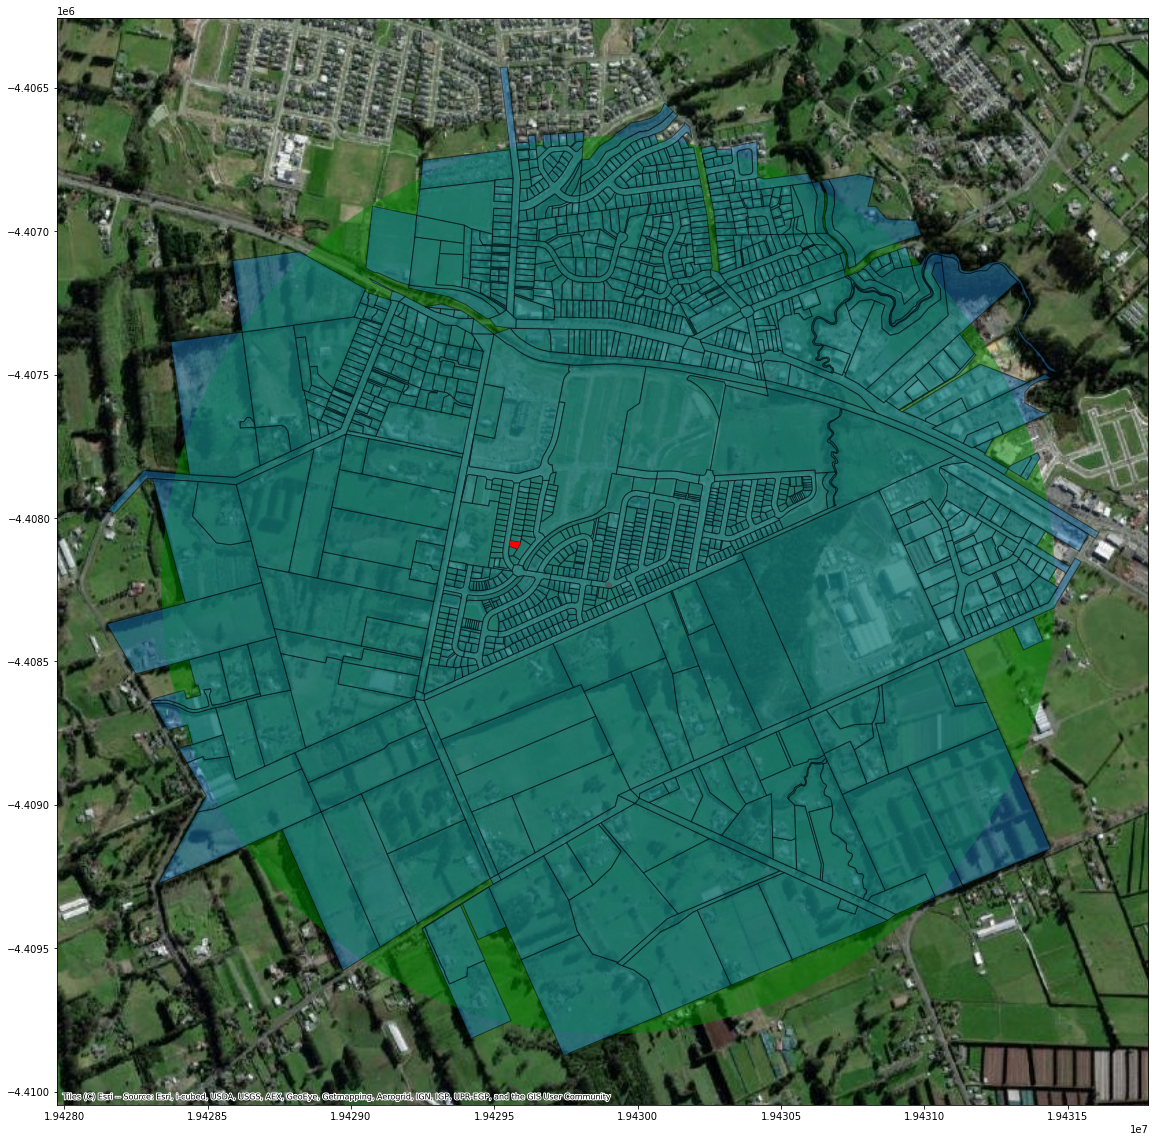

In [ ]:
indices_in_range = parcel_tree.query_ball_point([sample.centroid.iloc[0].x, sample.centroid.iloc[0].y], 1250)
ax = sample.to_crs(epsg=3857).plot(color="red", alpha=1)
sample.buffer(1250).to_crs(epsg=3857).plot(ax=ax, alpha=.5, color="green")
potential_matches = parcels.iloc[indices_in_range]
potential_matches.to_crs(epsg=3857).plot(ax=ax, alpha=.5, edgecolor="black")
potential_matches[potential_matches.addresses.str.contains(sample.number_name.iloc[0], na=False, regex=False)].to_crs(epsg=3857).plot(ax=ax, color="red")
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

In [ ]:
bcs_needing_match = df[
    ~pd.isna(df.number_name) &
    pd.isna(df["LINZ_MATCH_CODE"]) &
    df.number_name.isin(addresses.address_number_name)
]
bcs_needing_match

OBS              CONSENT_DATE                MARCH_YEAR  \
3       227896  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
4       227902  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
6       227911  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
7       227912  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
9       227954  Feb 01, 2021 12:00:00 AM  Mar 01, 2020 12:00:00 AM   
...        ...                       ...                       ...   
207198  151375  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207203  151370  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207205  151368  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207208  151365  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   
207223  151350  Jul 01, 2014 12:00:00 AM  Mar 01, 2015 12:00:00 AM   

                                 ADDRESS_1     ADDRESS_2         ADDRESS_3  \
3                         56 VINISTRA ROAD        Huapai          Auckland   
4                         77 VINISTRA ROAD        Huapai          Auckland   
6       753A COATESVILLE-RIVERHEAD HIGHWAY     Riverhead          Auckland   
7                          21 DIAMOND LANE     Riverhead          Auckland   
9                            60 CLARK ROAD   Hobsonville          Auckland   
...                                    ...           ...               ...   
207198                                 20A   HOLBROOK ST          AVONDALE   
207203                                  5B  COMMODORE DR          LYNFIELD   
207205                                  54     ELLIS AVE     MOUNT ROSKILL   
207208                                  1B     WAIRUA RD           REMUERA   
207223                                 55B   PANORAMA RD  MOUNT WELLINGTON   

                      LB_Name  \
3                      Rodney   
4                      Rodney   
6                      Rodney   
7                      Rodney   
9               Upper Harbour   
...                       ...   
207198                   Whau   
207203             Puketapapa   
207205             Puketapapa   
207208                 Orakei   
207223  Maungakiekie - Tamaki   

                                       BUILDING_TYPE_NAME  BUILDING_TYPE_CODE  \
3                                                  Houses                1111   
4                                                  Houses                1111   
6                               Non-building construction                3111   
7                                          Farm buildings                2711   
9                                                  Houses                1111   
...                                                   ...                 ...   
207198  New (and pre-built) house, unit, bach, crib, b...                1100   
207203  New (and pre-built) house, unit, bach, crib, b...                1100   
207205  New (and pre-built) house, unit, bach, crib, b...                1100   
207208  New (and pre-built) house, unit, bach, crib, b...                1100   
207223  New (and pre-built) house, unit, bach, crib, b...                1100   

        FLOOR_AREA     VALUE  BUILDINGS Building_Type_Group Residential_Type  \
3            179.0       NaN          1         Residential         Detached   
4            180.0       NaN          1         Residential         Detached   
6              0.0       NaN          1               Other              NaN   
7            313.0       NaN          1               Other              NaN   
9            195.0       NaN          1         Residential         Detached   
...            ...       ...        ...                 ...              ...   
207198       241.0  350000.0          1         Residential         Detached   
207203       160.0  250000.0          1         Residential         Detached   
207205       158.0  268000.0          1         Residential         Detached   
207208       127.0  400000.0          1         Residential    

In [ ]:
bctree = cKDTree(list(bcs_needing_match.centroid.apply(lambda x: (x.x, x.y))))
bctree

In [ ]:
%%time
# this creates a list of lists, where the ith list contains the the neighbours of the ith bc
bc_tree_neighbours = bctree.query_ball_tree(parcel_tree, 1250)

CPU times: user 11.2 s, sys: 2.62 s, total: 13.9 s
Wall time: 13.9 s


In [ ]:
%%time
for i, indices_in_range in enumerate(tqdm(bc_tree_neighbours)):
    number_name = bcs_needing_match.number_name.iloc[i]
    potential_matches = parcels.iloc[indices_in_range]
    match = potential_matches[potential_matches.addresses.str.contains(number_name, na=False, regex=False)]
    display(number_name, match)
    if len(match):
        bcs_needing_match.LINZ_parcel_ID[i] = match.index[0]
        bcs_needing_match.addresses[i] = match.addresses.iloc[0]
        bcs_needing_match.LINZ_MATCH_CODE = 2

'56 vinistra'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8081617  Lot 34 DP 544111        DP 544111  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8081617              None  North Auckland  920825        465.0      465.0   

                                                  geometry       addresses  
id                                                                          
8081617  MULTIPOLYGON (((1737305.127 5928738.535, 17373...  (56 vinistra,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'77 vinistra'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8081611  Lot 28 DP 544111        DP 544111  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8081611              None  North Auckland  920819        548.0      548.0   

                                                  geometry       addresses  
id                                                                          
8081611  MULTIPOLYGON (((1737252.929 5928721.589, 17372...  (77 vinistra,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'753a coatesville-riverhead'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'21 diamond'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7741687  Lot 2 DP 500720        DP 500720  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7741687              None  North Auckland  752160      10204.0    10201.0   

                                                  geometry      addresses  
id                                                                         
7741687  MULTIPOLYGON (((1744760.387 5930497.178, 17446...  (21 diamond,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'344 flat'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'149 grove'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'173 grove'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'139 grove'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'157 grove'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'141 grove'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'175 grove'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'153 grove'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'155 grove'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'55 clarks'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7932885  Lot 22 DP 526153        DP 526153  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7932885              None  North Auckland  843908        441.0      442.0   

                                                  geometry     addresses  
id                                                                        
7932885  MULTIPOLYGON (((1752034.268 5888620.336, 17520...  (55 clarks,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'764 glenbrook'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'40 browns'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'55 godfrey'

appellation      affected_surveys     parcel_intent  \
id                                                                    
8042639  Lot 1001 DP 542496  DP 542496, LT 552083  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
8042639       Primary              None  North Auckland  917193      64747.0   

         calc_area                                           geometry  \
id                                                                      
8042639    64657.0  MULTIPOLYGON (((1748945.076 5949302.347, 17489...   

                                                 addresses  
id                                                          
8042639  (29 godfrey, 30 godfrey, 32 godfrey, 34 godfre...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'53 godfrey'

appellation      affected_surveys     parcel_intent  \
id                                                                    
8042639  Lot 1001 DP 542496  DP 542496, LT 552083  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
8042639       Primary              None  North Auckland  917193      64747.0   

         calc_area                                           geometry  \
id                                                                      
8042639    64657.0  MULTIPOLYGON (((1748945.076 5949302.347, 17489...   

                                                 addresses  
id                                                          
8042639  (29 godfrey, 30 godfrey, 32 godfrey, 34 godfre...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'67 john'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'92 kewa'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080599  Lot 26 DP 544251        DP 544251  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080599              None  North Auckland  924727        680.0      680.0   

                                                  geometry   addresses  
id                                                                      
8080599  MULTIPOLYGON (((1752564.156 5935184.638, 17525...  (92 kewa,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'68 kewa'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080586  Lot 13 DP 544251        DP 544251  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080586              None  North Auckland  924714        536.0      537.0   

                                                  geometry   addresses  
id                                                                      
8080586  MULTIPOLYGON (((1752552.549 5935332.051, 17525...  (68 kewa,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'7 paikea'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080629  Lot 83 DP 544251        DP 544251  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080629              None  North Auckland  924757        700.0      700.0   

                                                  geometry    addresses  
id                                                                       
8080629  MULTIPOLYGON (((1752635.766 5935449.740, 17526...  (7 paikea,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'215 old'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'3 kapia'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'21 patrick'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7915467  Lot 42 DP 508683        DP 508683  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7915467              None  North Auckland  784411        492.0      492.0   

                                                  geometry      addresses  
id                                                                         
7915467  MULTIPOLYGON (((1742066.181 5919855.393, 17420...  (21 patrick,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'34 douglas'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'7 queen'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                              
7600212  Section 1 SO 486709        SO 486709  Fee Simple Title       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7600212  [Create] Stopped Road. Section 342 and Tenth S...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7600212  762906       1892.0     1893.0   

                                                  geometry   addresses  
id                                                                      
7600212  MULTIPOLYGON (((1757493.334 5920982.223, 17574...  (7 queen,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'58 albert'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7939165  Lot 1 DP 528611        DP 528611  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7939165              None  North Auckland  854667       1169.0     1168.0   

                                                  geometry     addresses  
id                                                                        
7939165  MULTIPOLYGON (((1757317.487 5920655.031, 17573...  (58 albert,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'630 great'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'2 fetter'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8037413  Lot 92 DP 541917        DP 541917  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8037413              None  North Auckland  911617        607.0      607.0   

                                                  geometry    addresses  
id                                                                       
8037413  MULTIPOLYGON (((1767664.008 5887637.418, 17676...  (2 fetter,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'11 whitton'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7993716  Lot 2 DP 534343        DP 534343  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7993716              None  North Auckland  880526       1267.0     1269.0   

                                                  geometry      addresses  
id                                                                         
7993716  MULTIPOLYGON (((1767775.761 5878677.744, 17677...  (11 whitton,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'71 john'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'1101 kaipara'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'81 vinistra'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8081609  Lot 26 DP 544111        DP 544111  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8081609              None  North Auckland  920817        492.0      492.0   

                                                  geometry       addresses  
id                                                                          
8081609  MULTIPOLYGON (((1737258.705 5928753.252, 17372...  (81 vinistra,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'98-100 petersons'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'16 belvedere'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7580531  Lot 22 DP 473121        DP 473121  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7580531              None  North Auckland  646559       1571.0     1572.0   

                                                  geometry  \
id                                                           
7580531  MULTIPOLYGON (((1748412.428 5970224.054, 17484...   

                            addresses  
id                                     
7580531  (16 belvedere, 14 belvedere)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'47 godfrey'

appellation      affected_surveys     parcel_intent  \
id                                                                    
8042639  Lot 1001 DP 542496  DP 542496, LT 552083  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
8042639       Primary              None  North Auckland  917193      64747.0   

         calc_area                                           geometry  \
id                                                                      
8042639    64657.0  MULTIPOLYGON (((1748945.076 5949302.347, 17489...   

                                                 addresses  
id                                                          
8042639  (29 godfrey, 30 godfrey, 32 godfrey, 34 godfre...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1489d weranui'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7759207  Lot 2 DP 505654        DP 505654  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7759207              None  North Auckland  763939       3623.0     3623.0   

                                                  geometry         addresses  
id                                                                            
7759207  MULTIPOLYGON (((1742624.200 5948845.218, 17425...  (1489d weranui,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'78 kewa'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080592  Lot 19 DP 544251        DP 544251  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080592              None  North Auckland  924720        748.0      748.0   

                                                  geometry   addresses  
id                                                                      
8080592  MULTIPOLYGON (((1752541.759 5935244.527, 17525...  (78 kewa,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'90 kewa'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080598  Lot 25 DP 544251        DP 544251  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080598              None  North Auckland  924726        649.0      649.0   

                                                  geometry   addresses  
id                                                                      
8080598  MULTIPOLYGON (((1752565.326 5935203.496, 17525...  (90 kewa,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'84 kewa'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080595  Lot 22 DP 544251        DP 544251  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080595              None  North Auckland  924723        579.0      580.0   

                                                  geometry   addresses  
id                                                                      
8080595  MULTIPOLYGON (((1752543.082 5935224.592, 17525...  (84 kewa,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'9 paikea'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080628  Lot 82 DP 544251        DP 544251  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080628              None  North Auckland  924756        700.0      700.0   

                                                  geometry    addresses  
id                                                                       
8080628  MULTIPOLYGON (((1752644.195 5935430.818, 17526...  (9 paikea,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'25 paikea'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080620  Lot 74 DP 544251        DP 544251  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080620              None  North Auckland  924748        838.0      838.0   

                                                  geometry     addresses  
id                                                                        
8080620  MULTIPOLYGON (((1752712.894 5935276.575, 17527...  (25 paikea,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'86 kewa'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080596  Lot 23 DP 544251        DP 544251  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080596              None  North Auckland  924724        668.0      669.0   

                                                  geometry   addresses  
id                                                                      
8080596  MULTIPOLYGON (((1752565.326 5935203.496, 17525...  (86 kewa,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'23 vogwill'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8014153  Lot 4 DP 535293        DP 535293  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8014153              None  North Auckland  885504        658.0      658.0   

                                                  geometry      addresses  
id                                                                         
8014153  MULTIPOLYGON (((1736413.981 5930512.980, 17364...  (23 vogwill,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'58 glenmore'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'2 dale'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'4 fraser'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'29 beach'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'59 milton'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'57 murphys'

appellation affected_surveys parcel_intent topology_type  \
id                                                                      
4903301  Lot 3 DP 184785        DP 184785          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4903301              None  North Auckland  NA114C/673      50634.0    50646.0   

                                                  geometry      addresses  
id                                                                         
4903301  MULTIPOLYGON (((1771345.271 5904303.028, 17712...  (57 murphys,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'10 simmonds'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'7 chelsea'

appellation   affected_surveys parcel_intent  \
id                                                                              
4771074  Allot 109 Sbrn Sec 5 PSH OF Waipipi  LT 535303, SO 625          DCDB   

        topology_type statutory_actions   land_district     titles  \
id                                                                   
4771074       Primary              None  North Auckland  NA35C/579   

         survey_area  calc_area  \
id                                
4771074      17100.0    15275.0   

                                                  geometry  \
id                                                           
4771074  MULTIPOLYGON (((1746390.331 5882994.025, 17463...   

                      addresses  
id                               
4771074  (1 chelsea, 7 chelsea)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'67 maki'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7623313  Lot 1 DP 489727        DP 489727  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7623313              None  North Auckland  705344      27601.0    27591.0   

                                                  geometry   addresses  
id                                                                      
7623313  MULTIPOLYGON (((1743457.638 5925070.115, 17435...  (67 maki,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'67 maki'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7623313  Lot 1 DP 489727        DP 489727  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7623313              None  North Auckland  705344      27601.0    27591.0   

                                                  geometry   addresses  
id                                                                      
7623313  MULTIPOLYGON (((1743457.638 5925070.115, 17435...  (67 maki,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'55 the'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'87 vinistra'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8081606  Lot 23 DP 544111        DP 544111  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8081606              None  North Auckland  920814        491.0      491.0   

                                                  geometry       addresses  
id                                                                          
8081606  MULTIPOLYGON (((1737298.876 5928793.448, 17372...  (87 vinistra,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'5 vintry'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'23 school'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7944352  Lot 4 DP 527429        DP 527429  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7944352              None  North Auckland  849613     120868.0   120827.0   

                                                  geometry  \
id                                                           
7944352  MULTIPOLYGON (((1733194.274 5928673.472, 17332...   

                      addresses  
id                               
7944352  (23 school, 25 school)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'127 kuaka'

appellation      affected_surveys     parcel_intent  \
id                                                                    
8049097  Lot 1002 DP 541606  DP 541606, LT 545761  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
8049097       Primary              None  North Auckland  910466      58882.0   

         calc_area                                           geometry  \
id                                                                      
8049097    58880.0  MULTIPOLYGON (((1772666.919 5899104.593, 17726...   

                                                 addresses  
id                                                          
8049097  (15 katipo, 13 katipo, 4 kapowai, 17 katipo, 1...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'105 fausett'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7616717  Lot 2 DP 484283        DP 484283  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7616717              None  North Auckland  685783     287390.0   287374.0   

                                                  geometry  \
id                                                           
7616717  MULTIPOLYGON (((1779646.634 5886915.204, 17796...   

                                     addresses  
id                                              
7616717  (105 fausett, 73 fausett, 11 fausett)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'13 ingram'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'57 murphys'

appellation affected_surveys parcel_intent topology_type  \
id                                                                      
4903301  Lot 3 DP 184785        DP 184785          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4903301              None  North Auckland  NA114C/673      50634.0    50646.0   

                                                  geometry      addresses  
id                                                                         
4903301  MULTIPOLYGON (((1771345.271 5904303.028, 17712...  (57 murphys,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'57 murphys'

appellation affected_surveys parcel_intent topology_type  \
id                                                                      
4903301  Lot 3 DP 184785        DP 184785          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4903301              None  North Auckland  NA114C/673      50634.0    50646.0   

                                                  geometry      addresses  
id                                                                         
4903301  MULTIPOLYGON (((1771345.271 5904303.028, 17712...  (57 murphys,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'57 murphys'

appellation affected_surveys parcel_intent topology_type  \
id                                                                      
4903301  Lot 3 DP 184785        DP 184785          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4903301              None  North Auckland  NA114C/673      50634.0    50646.0   

                                                  geometry      addresses  
id                                                                         
4903301  MULTIPOLYGON (((1771345.271 5904303.028, 17712...  (57 murphys,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'137 shirley'

appellation affected_surveys parcel_intent topology_type  \
id                                                                      
4910114  Lot 3 DP 102218        DP 102218          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4910114              None  North Auckland  NA57B/1220       1012.0     1012.0   

                                                  geometry       addresses  
id                                                                          
4910114  MULTIPOLYGON (((1764585.199 5906141.929, 17645...  (137 shirley,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'7 queen'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                              
7600212  Section 1 SO 486709        SO 486709  Fee Simple Title       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7600212  [Create] Stopped Road. Section 342 and Tenth S...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7600212  762906       1892.0     1893.0   

                                                  geometry   addresses  
id                                                                      
7600212  MULTIPOLYGON (((1757493.334 5920982.223, 17574...  (7 queen,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'8 scramble'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8022189  Lot 2 DP 532645        DP 532645  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8022189              None  North Auckland  872680        325.0      325.0   

                                                  geometry  \
id                                                           
8022189  MULTIPOLYGON (((1748651.161 5927473.075, 17486...   

                        addresses  
id                                 
8022189  (8 scramble, 6 scramble)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'8 scramble'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8022189  Lot 2 DP 532645        DP 532645  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8022189              None  North Auckland  872680        325.0      325.0   

                                                  geometry  \
id                                                           
8022189  MULTIPOLYGON (((1748651.161 5927473.075, 17486...   

                        addresses  
id                                 
8022189  (8 scramble, 6 scramble)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'6 scramble'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8022189  Lot 2 DP 532645        DP 532645  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8022189              None  North Auckland  872680        325.0      325.0   

                                                  geometry  \
id                                                           
8022189  MULTIPOLYGON (((1748651.161 5927473.075, 17486...   

                        addresses  
id                                 
8022189  (8 scramble, 6 scramble)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'6 scramble'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8022189  Lot 2 DP 532645        DP 532645  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8022189              None  North Auckland  872680        325.0      325.0   

                                                  geometry  \
id                                                           
8022189  MULTIPOLYGON (((1748651.161 5927473.075, 17486...   

                        addresses  
id                                 
8022189  (8 scramble, 6 scramble)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'6 scramble'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8022189  Lot 2 DP 532645        DP 532645  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8022189              None  North Auckland  872680        325.0      325.0   

                                                  geometry  \
id                                                           
8022189  MULTIPOLYGON (((1748651.161 5927473.075, 17486...   

                        addresses  
id                                 
8022189  (8 scramble, 6 scramble)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'6 scramble'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8022189  Lot 2 DP 532645        DP 532645  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8022189              None  North Auckland  872680        325.0      325.0   

                                                  geometry  \
id                                                           
8022189  MULTIPOLYGON (((1748651.161 5927473.075, 17486...   

                        addresses  
id                                 
8022189  (8 scramble, 6 scramble)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'25 vogwill'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8014154  Lot 5 DP 535293        DP 535293  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8014154              None  North Auckland  885505        644.0      644.0   

                                                  geometry      addresses  
id                                                                         
8014154  MULTIPOLYGON (((1736416.702 5930531.128, 17364...  (25 vogwill,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 taimana'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8005115  Lot 2 DP 513932        DP 513932  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8005115              None  North Auckland  796022        773.0      774.0   

                                                  geometry     addresses  
id                                                                        
8005115  MULTIPOLYGON (((1752197.180 5930520.870, 17521...  (3 taimana,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'18 paikea'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080617  Lot 71 DP 544251        DP 544251  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080617              None  North Auckland  924745        585.0      584.0   

                                                  geometry     addresses  
id                                                                        
8080617  MULTIPOLYGON (((1752617.356 5935232.662, 17526...  (18 paikea,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'2 paikea'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080609  Lot 63 DP 544251        DP 544251  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080609              None  North Auckland  924737        606.0      607.0   

                                                  geometry    addresses  
id                                                                       
8080609  MULTIPOLYGON (((1752565.085 5935404.445, 17525...  (2 paikea,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'76 kewa'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080591  Lot 18 DP 544251        DP 544251  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080591              None  North Auckland  924719        642.0      643.0   

                                                  geometry   addresses  
id                                                                      
8080591  MULTIPOLYGON (((1752538.924 5935287.163, 17525...  (76 kewa,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'45 kewa'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080608  Lot 62 DP 544251        DP 544251  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080608              None  North Auckland  924736        504.0      504.0   

                                                  geometry   addresses  
id                                                                      
8080608  MULTIPOLYGON (((1752572.322 5935379.101, 17525...  (45 kewa,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1436 old'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7960890  Lot 5 DP 533710        DP 533710  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7960890              None  North Auckland  877752      19328.0    19325.0   

                                                  geometry    addresses  
id                                                                       
7960890  MULTIPOLYGON (((1732703.483 5936171.930, 17327...  (1436 old,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'67 godfrey'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8042579  Lot 73 DP 542496        DP 542496  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8042579              None  North Auckland  917165        679.0      680.0   

                                                  geometry      addresses  
id                                                                         
8042579  MULTIPOLYGON (((1748956.755 5949376.761, 17489...  (67 godfrey,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'46 pacific'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'2 hector'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'237 coal'

appellation affected_surveys parcel_intent  \
id                                                                         
4791525  Section 36 Block IV Mangawhai SD         SO 45817          DCDB   

        topology_type statutory_actions   land_district      titles  \
id                                                                    
4791525       Primary              None  North Auckland  NA33A/1355   

         survey_area  calc_area  \
id                                
4791525     487216.0   486688.0   

                                                  geometry    addresses  
id                                                                       
4791525  MULTIPOLYGON (((1744399.100 5998688.968, 17445...  (237 coal,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'844 matakana'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'58 schoolhouse'

appellation affected_surveys parcel_intent topology_type  \
id                                                                      
5114619  Lot 15 DP 56999         DP 56999          DCDB       Primary   

        statutory_actions   land_district                 titles  survey_area  \
id                                                                              
5114619              None  North Auckland  NA1093/40, NA14A/1159       1012.0   

         calc_area                                           geometry  \
id                                                                      
5114619     1019.0  MULTIPOLYGON (((1764115.798 5966650.048, 17640...   

                 addresses  
id                          
5114619  (58 schoolhouse,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'50 west'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'50 west'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'71 john'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'20 kuinga'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'330 rimmer'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'58 vinistra'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8081618  Lot 35 DP 544111        DP 544111  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8081618              None  North Auckland  920826        502.0      501.0   

                                                  geometry       addresses  
id                                                                          
8081618  MULTIPOLYGON (((1737307.807 5928753.219, 17373...  (58 vinistra,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'9 vintry'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'1 vintry'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'89 vinistra'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8081605  Lot 22 DP 544111        DP 544111  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8081605              None  North Auckland  920813        491.0      491.0   

                                                  geometry       addresses  
id                                                                          
8081605  MULTIPOLYGON (((1737269.826 5928814.204, 17373...  (89 vinistra,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'91 vinistra'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8081604  Lot 21 DP 544111        DP 544111  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8081604              None  North Auckland  920812        491.0      491.0   

                                                  geometry       addresses  
id                                                                          
8081604  MULTIPOLYGON (((1737272.554 5928829.165, 17373...  (91 vinistra,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'13 vintry'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'30 upper'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'2 nga'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
7934179  Lot 367 DP 526436        DP 526436  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7934179              None  North Auckland  850513        454.0      454.0   

                                                  geometry       addresses  
id                                                                          
7934179  MULTIPOLYGON (((1751200.329 5947177.288, 17511...  (2 nga, 4 nga)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'57 kewa'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080602  Lot 56 DP 544251        DP 544251  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080602              None  North Auckland  924730        501.0      501.0   

                                                  geometry   addresses  
id                                                                      
8080602  MULTIPOLYGON (((1752617.871 5935249.392, 17526...  (57 kewa,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'13 paikea'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080626  Lot 80 DP 544251        DP 544251  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080626              None  North Auckland  924754        700.0      700.0   

                                                  geometry     addresses  
id                                                                        
8080626  MULTIPOLYGON (((1752661.709 5935391.486, 17526...  (13 paikea,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'55 kewa'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080603  Lot 57 DP 544251        DP 544251  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080603              None  North Auckland  924731        501.0      501.0   

                                                  geometry   addresses  
id                                                                      
8080603  MULTIPOLYGON (((1752618.094 5935267.536, 17526...  (55 kewa,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'18 vogwill'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8014165  Lot 16 DP 535293        DP 535293  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8014165              None  North Auckland  885496        692.0      692.0   

                                                  geometry      addresses  
id                                                                         
8014165  MULTIPOLYGON (((1736461.555 5930676.825, 17364...  (18 vogwill,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'14 vogwill'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8014167  Lot 18 DP 535293        DP 535293  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8014167              None  North Auckland  885498        748.0      748.0   

                                                  geometry  \
id                                                           
8014167  MULTIPOLYGON (((1736439.685 5930620.971, 17364...   

                         addresses  
id                                  
8014167  (14 vogwill, 14a vogwill)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'33 vogwill'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8014157  Lot 8 DP 535293        DP 535293  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8014157              None  North Auckland  885508        629.0      629.0   

                                                  geometry      addresses  
id                                                                         
8014157  MULTIPOLYGON (((1736395.312 5930618.126, 17363...  (33 vogwill,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'13 scott'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'13 scott'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'13 scott'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'165 clark'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8061520  Lot 80 DP 534078        DP 534078  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8061520              None  North Auckland  879538        231.0      231.0   

                                                  geometry     addresses  
id                                                                        
8061520  MULTIPOLYGON (((1748260.801 5926586.180, 17482...  (165 clark,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'41a leo'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7864214  Lot 2 DP 521491        DP 521491  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7864214              None  North Auckland  826008        549.0      549.0   

                                                  geometry   addresses  
id                                                                      
7864214  MULTIPOLYGON (((1745834.600 5912895.504, 17458...  (41a leo,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'29a seaview'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'7 queen'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                              
7600212  Section 1 SO 486709        SO 486709  Fee Simple Title       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7600212  [Create] Stopped Road. Section 342 and Tenth S...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7600212  762906       1892.0     1893.0   

                                                  geometry   addresses  
id                                                                      
7600212  MULTIPOLYGON (((1757493.334 5920982.223, 17574...  (7 queen,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'58 albert'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7939165  Lot 1 DP 528611        DP 528611  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7939165              None  North Auckland  854667       1169.0     1168.0   

                                                  geometry     addresses  
id                                                                        
7939165  MULTIPOLYGON (((1757317.487 5920655.031, 17573...  (58 albert,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 courthouse'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'7 reg'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7828767  Lot 29 DP 513109        DP 513109  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7828767              None  North Auckland  792677        351.0      351.0   

                                                  geometry addresses  
id                                                                    
7828767  MULTIPOLYGON (((1766396.155 5917706.581, 17663...  (7 reg,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'725 man'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'62 hendon'

appellation affected_surveys parcel_intent topology_type  \
id                                                                      
4968969  Lot 78 DP 47982         DP 47982          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4968969              None  North Auckland  NA100C/644        599.0      600.0   

                                                  geometry     addresses  
id                                                                        
4968969  MULTIPOLYGON (((1752508.771 5915173.233, 17525...  (62 hendon,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'118 mount'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'7 derna'

appellation affected_surveys parcel_intent topology_type  \
id                                                                       
4806726  Lot 571 DP 38230         DP 38230          DCDB       Primary   

        statutory_actions   land_district     titles  survey_area  calc_area  \
id                                                                             
4806726              None  North Auckland  NA52D/991        650.0      652.0   

                                                  geometry  \
id                                                           
4806726  MULTIPOLYGON (((1766202.444 5915516.841, 17662...   

                           addresses  
id                                    
4806726  (7 derna, 5 derna, 3 derna)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1b rogers'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8052242  Lot 2 DP 538776        DP 538776  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8052242              None  North Auckland  902036        515.0      515.0   

                                                  geometry     addresses  
id                                                                        
8052242  MULTIPOLYGON (((1770535.471 5917330.371, 17705...  (1b rogers,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'10 simmonds'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'77 blue'

appellation      affected_surveys     parcel_intent  \
id                                                                 
7812202  Lot 4 DP 510446  DP 510446, DP 522558  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7812202       Primary              None  North Auckland  781752       1115.0   

         calc_area                                           geometry  \
id                                                                      
7812202     1115.0  MULTIPOLYGON (((1749038.906 5969505.503, 17490...   

          addresses  
id                   
7812202  (77 blue,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'54 vivian'

appellation affected_surveys parcel_intent topology_type  \
id                                                                     
4734316  Lot 2 DP 66030         DP 66030          DCDB       Primary   

        statutory_actions   land_district     titles  survey_area  calc_area  \
id                                                                             
4734316              None  North Auckland  NA31D/912       4730.0     5568.0   

                                                  geometry     addresses  
id                                                                        
4734316  MULTIPOLYGON (((1764474.810 5970233.665, 17644...  (54 vivian,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'71 john'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'45 kea'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'58 kea'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'46 kea'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'27 kea'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 kea'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'39 kea'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'35 kea'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'32 kea'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'40 kea'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'159 upper'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'11 vintry'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'7 vintry'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'66 vinistra'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8081622  Lot 39 DP 544111        DP 544111  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8081622              None  North Auckland  920830        458.0      458.0   

                                                  geometry       addresses  
id                                                                          
8081622  MULTIPOLYGON (((1737319.055 5928814.852, 17373...  (66 vinistra,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'85 vinistra'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8081607  Lot 24 DP 544111        DP 544111  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8081607              None  North Auckland  920815        491.0      491.0   

                                                  geometry       addresses  
id                                                                          
8081607  MULTIPOLYGON (((1737264.366 5928784.284, 17372...  (85 vinistra,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'62 vinistra'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8081620  Lot 37 DP 544111        DP 544111  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8081620              None  North Auckland  920828        455.0      455.0   

                                                  geometry       addresses  
id                                                                          
8081620  MULTIPOLYGON (((1737313.617 5928785.059, 17373...  (62 vinistra,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 vinistra'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8081621  Lot 38 DP 544111        DP 544111  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8081621              None  North Auckland  920829        457.0      457.0   

                                                  geometry       addresses  
id                                                                          
8081621  MULTIPOLYGON (((1737316.334 5928799.931, 17373...  (64 vinistra,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'60 vinistra'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8081619  Lot 36 DP 544111        DP 544111  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8081619              None  North Auckland  920827        466.0      466.0   

                                                  geometry       addresses  
id                                                                          
8081619  MULTIPOLYGON (((1737310.840 5928769.832, 17373...  (60 vinistra,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'70 vinistra'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8081624  Lot 41 DP 544111        DP 544111  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8081624              None  North Auckland  920832        458.0      458.0   

                                                  geometry       addresses  
id                                                                          
8081624  MULTIPOLYGON (((1737324.509 5928844.755, 17373...  (70 vinistra,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'68 vinistra'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8081623  Lot 40 DP 544111        DP 544111  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8081623              None  North Auckland  920831        458.0      458.0   

                                                  geometry       addresses  
id                                                                          
8081623  MULTIPOLYGON (((1737321.784 5928829.802, 17373...  (68 vinistra,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 vintry'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'72 vinistra'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8081625  Lot 42 DP 544111        DP 544111  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8081625              None  North Auckland  920833        458.0      458.0   

                                                  geometry       addresses  
id                                                                          
8081625  MULTIPOLYGON (((1737327.237 5928859.707, 17373...  (72 vinistra,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'18 de'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 mckenzie'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'91 noel'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7669403  Lot 2 DP 495832        DP 495832  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7669403              None  North Auckland  728315       3688.0     3688.0   

                                                  geometry   addresses  
id                                                                      
7669403  MULTIPOLYGON (((1764907.223 5903872.254, 17649...  (91 noel,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'37 surf'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
7944526  Lot 418 DP 531193        DP 531193  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7944526              None  North Auckland  866716        826.0      825.0   

                                                  geometry   addresses  
id                                                                      
7944526  MULTIPOLYGON (((1751212.666 5947373.917, 17512...  (37 surf,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'57 godfrey'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8042584  Lot 78 DP 542496        DP 542496  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8042584              None  North Auckland  917170        520.0      521.0   

                                                  geometry      addresses  
id                                                                         
8042584  MULTIPOLYGON (((1748927.885 5949302.001, 17488...  (57 godfrey,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'110 maurice'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8072348  Lot 690 DP 543020        DP 543020  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8072348              None  North Auckland  919208        680.0      681.0   

                                                  geometry       addresses  
id                                                                          
8072348  MULTIPOLYGON (((1748271.243 5946403.880, 17482...  (110 maurice,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'15 paikea'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080625  Lot 79 DP 544251        DP 544251  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080625              None  North Auckland  924753        700.0      700.0   

                                                  geometry     addresses  
id                                                                        
8080625  MULTIPOLYGON (((1752670.456 5935371.848, 17526...  (15 paikea,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'13 scott'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'85d lake'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8070349  Lot 15 DP 541878        DP 541878  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8070349              None  North Auckland  911195        551.0      551.0   

                                                  geometry    addresses  
id                                                                       
8070349  MULTIPOLYGON (((1742749.234 5917205.077, 17427...  (85d lake,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'85c lake'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8070348  Lot 14 DP 541878        DP 541878  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8070348              None  North Auckland  911194        551.0      551.0   

                                                  geometry    addresses  
id                                                                       
8070348  MULTIPOLYGON (((1742753.429 5917191.201, 17427...  (85c lake,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'4 fraser'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'3 new'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'100 halsey'

appellation                                   affected_surveys  \
id                                                                           
4873920  Lot 1 DP 80054  DP 80054, LT 532182, LT 532306, SO 495737, SO ...   

        parcel_intent topology_type statutory_actions   land_district  \
id                                                                      
4873920          DCDB       Primary              None  North Auckland   

                    titles  survey_area  calc_area  \
id                                                   
4873920  806383, NA36D/335      16608.0    16599.0   

                                                  geometry  \
id                                                           
4873920  MULTIPOLYGON (((1756489.222 5920956.272, 17565...   

                                                 addresses  
id                                                          
4873920  (114 pakenham, 100 halsey, 112 pakenham, 112 h...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'7 queen'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                              
7600212  Section 1 SO 486709        SO 486709  Fee Simple Title       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7600212  [Create] Stopped Road. Section 342 and Tenth S...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7600212  762906       1892.0     1893.0   

                                                  geometry   addresses  
id                                                                      
7600212  MULTIPOLYGON (((1757493.334 5920982.223, 17574...  (7 queen,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'101 hobson'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'79b arthur'

appellation affected_surveys parcel_intent topology_type  \
id                                                                     
4995383  Lot 1 DP 41050         DP 41050          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4995383              None  North Auckland  NA1087/275       1232.0     1231.0   

                                                  geometry  \
id                                                           
4995383  MULTIPOLYGON (((1758475.575 5912331.538, 17584...   

                        addresses  
id                                 
4995383  (79b arthur, 79a arthur)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'27 takutai'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'293 flat'

appellation affected_surveys parcel_intent topology_type  \
id                                                                      
4860407  Lot 2 DP 165529        DP 165529          DCDB       Primary   

        statutory_actions   land_district     titles  survey_area  calc_area  \
id                                                                             
4860407              None  North Auckland  NA99D/894      19832.0    19831.0   

                                                  geometry  \
id                                                           
4860407  MULTIPOLYGON (((1772065.741 5905705.195, 17721...   

                   addresses  
id                            
4860407  (15 hera, 293 flat)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'293 flat'

appellation affected_surveys parcel_intent topology_type  \
id                                                                      
4860407  Lot 2 DP 165529        DP 165529          DCDB       Primary   

        statutory_actions   land_district     titles  survey_area  calc_area  \
id                                                                             
4860407              None  North Auckland  NA99D/894      19832.0    19831.0   

                                                  geometry  \
id                                                           
4860407  MULTIPOLYGON (((1772065.741 5905705.195, 17721...   

                   addresses  
id                            
4860407  (15 hera, 293 flat)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'23 murphys'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
6971165  Lot 2 DP 386680        DP 386680  Fee Simple Title       Primary   
8037706  Lot 1 DP 533605        DP 533605  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
6971165              None  North Auckland  346981       7804.0     7805.0   
8037706              None  North Auckland  878166       4878.0     4878.0   

                                                  geometry  \
id                                                           
6971165  MULTIPOLYGON (((1770958.332 5904236.181, 17709...   
8037706  MULTIPOLYGON (((1771363.543 5905181.240, 17712...   

                         addresses  
id                                  
6971165              (23 murphys,)  
8037706  (1 hermitage, 23 murphys)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'23 murphys'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
6971165  Lot 2 DP 386680        DP 386680  Fee Simple Title       Primary   
8037706  Lot 1 DP 533605        DP 533605  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
6971165              None  North Auckland  346981       7804.0     7805.0   
8037706              None  North Auckland  878166       4878.0     4878.0   

                                                  geometry  \
id                                                           
6971165  MULTIPOLYGON (((1770958.332 5904236.181, 17709...   
8037706  MULTIPOLYGON (((1771363.543 5905181.240, 17712...   

                         addresses  
id                                  
6971165              (23 murphys,)  
8037706  (1 hermitage, 23 murphys)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'11 ingram'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'10 simmonds'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'3 pepeke'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8042605  Lot 194 DP 542496        DP 542496  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8042605              None  North Auckland  917191        504.0      505.0   

                                                  geometry    addresses  
id                                                                       
8042605  MULTIPOLYGON (((1749023.474 5949351.020, 17490...  (3 pepeke,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'79 vinistra'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8081610  Lot 27 DP 544111        DP 544111  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8081610              None  North Auckland  920818        481.0      480.0   

                                                  geometry       addresses  
id                                                                          
8081610  MULTIPOLYGON (((1737255.959 5928738.203, 17372...  (79 vinistra,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'95 vinistra'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8081602  Lot 19 DP 544111        DP 544111  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8081602              None  North Auckland  920810        491.0      491.0   

                                                  geometry       addresses  
id                                                                          
8081602  MULTIPOLYGON (((1737309.794 5928853.279, 17373...  (95 vinistra,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'93 vinistra'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8081603  Lot 20 DP 544111        DP 544111  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8081603              None  North Auckland  920811        491.0      491.0   

                                                  geometry       addresses  
id                                                                          
8081603  MULTIPOLYGON (((1737275.283 5928844.123, 17373...  (93 vinistra,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'75b vinistra'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8081612  Lot 29 DP 544111        DP 544111  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8081612              None  North Auckland  920820        424.0      425.0   

                                                  geometry        addresses  
id                                                                           
8081612  MULTIPOLYGON (((1737265.150 5928705.691, 17372...  (75b vinistra,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'97 vinistra'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8081601  Lot 18 DP 544111        DP 544111  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8081601              None  North Auckland  920809        500.0      500.0   

                                                  geometry       addresses  
id                                                                          
8081601  MULTIPOLYGON (((1737278.436 5928861.520, 17372...  (97 vinistra,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 madden'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8025322  Lot 2 DP 529976        DP 529976  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8025322              None  North Auckland  860359        536.0      536.0   

                                                  geometry  \
id                                                           
8025322  MULTIPOLYGON (((1736674.417 5929962.010, 17366...   

                         addresses  
id                                  
8025322  (32 gilbransen, 1 madden)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'4b kakano'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8005507  Lot 7 DP 531367        DP 531367  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8005507              None  North Auckland  867074      12701.0    12693.0   

                                                  geometry     addresses  
id                                                                        
8005507  MULTIPOLYGON (((1742855.053 5924875.943, 17429...  (4b kakano,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'38 court'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'7 paretaiuru'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8066690  Lot 920 DP 543960        DP 543960  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8066690              None  North Auckland  920461        198.0      199.0   

                                                  geometry        addresses  
id                                                                           
8066690  MULTIPOLYGON (((1773072.008 5897529.191, 17730...  (7 paretaiuru,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'13 hikuwai'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8092902  Lot 10 DP 546904        DP 546904  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8092902              None  North Auckland  931884        519.0      519.0   

                                                  geometry      addresses  
id                                                                         
8092902  MULTIPOLYGON (((1748092.209 5970541.058, 17480...  (13 hikuwai,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'10 braemar'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'69 godfrey'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8042578  Lot 72 DP 542496        DP 542496  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8042578              None  North Auckland  917164        531.0      532.0   

                                                  geometry      addresses  
id                                                                         
8042578  MULTIPOLYGON (((1748962.418 5949382.592, 17489...  (69 godfrey,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'194d horseshoe'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7940380  Lot 1 DP 492823        DP 492823  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7940380              None  North Auckland  717214      39773.0    39759.0   

                                                  geometry          addresses  
id                                                                             
7940380  MULTIPOLYGON (((1744897.244 5942700.871, 17449...  (194d horseshoe,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'49 kewa'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080606  Lot 60 DP 544251        DP 544251  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080606              None  North Auckland  924734        507.0      507.0   

                                                  geometry   addresses  
id                                                                      
8080606  MULTIPOLYGON (((1752592.944 5935333.571, 17525...  (49 kewa,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'6 paikea'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080611  Lot 65 DP 544251        DP 544251  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080611              None  North Auckland  924739        500.0      500.0   

                                                  geometry    addresses  
id                                                                       
8080611  MULTIPOLYGON (((1752609.389 5935395.586, 17526...  (6 paikea,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'47 kewa'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080607  Lot 61 DP 544251        DP 544251  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080607              None  North Auckland  924735        511.0      512.0   

                                                  geometry   addresses  
id                                                                      
8080607  MULTIPOLYGON (((1752582.633 5935356.340, 17525...  (47 kewa,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'53 kewa'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080604  Lot 58 DP 544251        DP 544251  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080604              None  North Auckland  924732        500.0      501.0   

                                                  geometry   addresses  
id                                                                      
8080604  MULTIPOLYGON (((1752613.454 5935288.009, 17526...  (53 kewa,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'12 paikea'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080614  Lot 68 DP 544251        DP 544251  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080614              None  North Auckland  924742        502.0      502.0   

                                                  geometry     addresses  
id                                                                        
8080614  MULTIPOLYGON (((1752639.849 5935327.054, 17526...  (12 paikea,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'21 paikea'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080622  Lot 76 DP 544251        DP 544251  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080622              None  North Auckland  924750        702.0      703.0   

                                                  geometry     addresses  
id                                                                        
8080622  MULTIPOLYGON (((1752705.348 5935293.524, 17526...  (21 paikea,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'17 paikea'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080624  Lot 78 DP 544251        DP 544251  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080624              None  North Auckland  924752        700.0      701.0   

                                                  geometry     addresses  
id                                                                        
8080624  MULTIPOLYGON (((1752679.201 5935352.215, 17526...  (17 paikea,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'19 paikea'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080623  Lot 77 DP 544251        DP 544251  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080623              None  North Auckland  924751        701.0      701.0   

                                                  geometry     addresses  
id                                                                        
8080623  MULTIPOLYGON (((1752687.948 5935332.579, 17526...  (19 paikea,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'51 kewa'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080605  Lot 59 DP 544251        DP 544251  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080605              None  North Auckland  924733        503.0      503.0   

                                                  geometry   addresses  
id                                                                      
8080605  MULTIPOLYGON (((1752603.261 5935310.799, 17525...  (51 kewa,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'4 paikea'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080610  Lot 64 DP 544251        DP 544251  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080610              None  North Auckland  924738        520.0      520.0   

                                                  geometry    addresses  
id                                                                       
8080610  MULTIPOLYGON (((1752598.001 5935419.070, 17526...  (4 paikea,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'2 dale'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'2 dale'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'6 berba'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8092954  Lot 204 DP 540764        DP 540764  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8092954              None  North Auckland  937153        283.0      284.0   

                                                  geometry   addresses  
id                                                                      
8092954  MULTIPOLYGON (((1742117.511 5924165.065, 17421...  (6 berba,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'16 berba'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8092959  Lot 209 DP 540764        DP 540764  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8092959              None  North Auckland  937158        160.0      160.0   

                                                  geometry    addresses  
id                                                                       
8092959  MULTIPOLYGON (((1742067.745 5924168.652, 17420...  (16 berba,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 derna'

appellation affected_surveys parcel_intent topology_type  \
id                                                                       
4806726  Lot 571 DP 38230         DP 38230          DCDB       Primary   

        statutory_actions   land_district     titles  survey_area  calc_area  \
id                                                                             
4806726              None  North Auckland  NA52D/991        650.0      652.0   

                                                  geometry  \
id                                                           
4806726  MULTIPOLYGON (((1766202.444 5915516.841, 17662...   

                           addresses  
id                                    
4806726  (7 derna, 5 derna, 3 derna)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 derna'

appellation affected_surveys parcel_intent topology_type  \
id                                                                       
4806726  Lot 571 DP 38230         DP 38230          DCDB       Primary   

        statutory_actions   land_district     titles  survey_area  calc_area  \
id                                                                             
4806726              None  North Auckland  NA52D/991        650.0      652.0   

                                                  geometry  \
id                                                           
4806726  MULTIPOLYGON (((1766202.444 5915516.841, 17662...   

                           addresses  
id                                    
4806726  (7 derna, 5 derna, 3 derna)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 derna'

appellation affected_surveys parcel_intent topology_type  \
id                                                                       
4806726  Lot 571 DP 38230         DP 38230          DCDB       Primary   

        statutory_actions   land_district     titles  survey_area  calc_area  \
id                                                                             
4806726              None  North Auckland  NA52D/991        650.0      652.0   

                                                  geometry  \
id                                                           
4806726  MULTIPOLYGON (((1766202.444 5915516.841, 17662...   

                           addresses  
id                                    
4806726  (7 derna, 5 derna, 3 derna)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 derna'

appellation affected_surveys parcel_intent topology_type  \
id                                                                       
4806726  Lot 571 DP 38230         DP 38230          DCDB       Primary   

        statutory_actions   land_district     titles  survey_area  calc_area  \
id                                                                             
4806726              None  North Auckland  NA52D/991        650.0      652.0   

                                                  geometry  \
id                                                           
4806726  MULTIPOLYGON (((1766202.444 5915516.841, 17662...   

                           addresses  
id                                    
4806726  (7 derna, 5 derna, 3 derna)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'7 derna'

appellation affected_surveys parcel_intent topology_type  \
id                                                                       
4806726  Lot 571 DP 38230         DP 38230          DCDB       Primary   

        statutory_actions   land_district     titles  survey_area  calc_area  \
id                                                                             
4806726              None  North Auckland  NA52D/991        650.0      652.0   

                                                  geometry  \
id                                                           
4806726  MULTIPOLYGON (((1766202.444 5915516.841, 17662...   

                           addresses  
id                                    
4806726  (7 derna, 5 derna, 3 derna)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'7 derna'

appellation affected_surveys parcel_intent topology_type  \
id                                                                       
4806726  Lot 571 DP 38230         DP 38230          DCDB       Primary   

        statutory_actions   land_district     titles  survey_area  calc_area  \
id                                                                             
4806726              None  North Auckland  NA52D/991        650.0      652.0   

                                                  geometry  \
id                                                           
4806726  MULTIPOLYGON (((1766202.444 5915516.841, 17662...   

                           addresses  
id                                    
4806726  (7 derna, 5 derna, 3 derna)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'7 derna'

appellation affected_surveys parcel_intent topology_type  \
id                                                                       
4806726  Lot 571 DP 38230         DP 38230          DCDB       Primary   

        statutory_actions   land_district     titles  survey_area  calc_area  \
id                                                                             
4806726              None  North Auckland  NA52D/991        650.0      652.0   

                                                  geometry  \
id                                                           
4806726  MULTIPOLYGON (((1766202.444 5915516.841, 17662...   

                           addresses  
id                                    
4806726  (7 derna, 5 derna, 3 derna)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 derna'

appellation affected_surveys parcel_intent topology_type  \
id                                                                       
4806726  Lot 571 DP 38230         DP 38230          DCDB       Primary   

        statutory_actions   land_district     titles  survey_area  calc_area  \
id                                                                             
4806726              None  North Auckland  NA52D/991        650.0      652.0   

                                                  geometry  \
id                                                           
4806726  MULTIPOLYGON (((1766202.444 5915516.841, 17662...   

                           addresses  
id                                    
4806726  (7 derna, 5 derna, 3 derna)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 derna'

appellation affected_surveys parcel_intent topology_type  \
id                                                                       
4806726  Lot 571 DP 38230         DP 38230          DCDB       Primary   

        statutory_actions   land_district     titles  survey_area  calc_area  \
id                                                                             
4806726              None  North Auckland  NA52D/991        650.0      652.0   

                                                  geometry  \
id                                                           
4806726  MULTIPOLYGON (((1766202.444 5915516.841, 17662...   

                           addresses  
id                                    
4806726  (7 derna, 5 derna, 3 derna)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 ara'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'293 flat'

appellation affected_surveys parcel_intent topology_type  \
id                                                                      
4860407  Lot 2 DP 165529        DP 165529          DCDB       Primary   

        statutory_actions   land_district     titles  survey_area  calc_area  \
id                                                                             
4860407              None  North Auckland  NA99D/894      19832.0    19831.0   

                                                  geometry  \
id                                                           
4860407  MULTIPOLYGON (((1772065.741 5905705.195, 17721...   

                   addresses  
id                            
4860407  (15 hera, 293 flat)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'293 flat'

appellation affected_surveys parcel_intent topology_type  \
id                                                                      
4860407  Lot 2 DP 165529        DP 165529          DCDB       Primary   

        statutory_actions   land_district     titles  survey_area  calc_area  \
id                                                                             
4860407              None  North Auckland  NA99D/894      19832.0    19831.0   

                                                  geometry  \
id                                                           
4860407  MULTIPOLYGON (((1772065.741 5905705.195, 17721...   

                   addresses  
id                            
4860407  (15 hera, 293 flat)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'23 murphys'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
6971165  Lot 2 DP 386680        DP 386680  Fee Simple Title       Primary   
8037706  Lot 1 DP 533605        DP 533605  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
6971165              None  North Auckland  346981       7804.0     7805.0   
8037706              None  North Auckland  878166       4878.0     4878.0   

                                                  geometry  \
id                                                           
6971165  MULTIPOLYGON (((1770958.332 5904236.181, 17709...   
8037706  MULTIPOLYGON (((1771363.543 5905181.240, 17712...   

                         addresses  
id                                  
6971165              (23 murphys,)  
8037706  (1 hermitage, 23 murphys)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'23 murphys'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
6971165  Lot 2 DP 386680        DP 386680  Fee Simple Title       Primary   
8037706  Lot 1 DP 533605        DP 533605  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
6971165              None  North Auckland  346981       7804.0     7805.0   
8037706              None  North Auckland  878166       4878.0     4878.0   

                                                  geometry  \
id                                                           
6971165  MULTIPOLYGON (((1770958.332 5904236.181, 17709...   
8037706  MULTIPOLYGON (((1771363.543 5905181.240, 17712...   

                         addresses  
id                                  
6971165              (23 murphys,)  
8037706  (1 hermitage, 23 murphys)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'23 murphys'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
6971165  Lot 2 DP 386680        DP 386680  Fee Simple Title       Primary   
8037706  Lot 1 DP 533605        DP 533605  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
6971165              None  North Auckland  346981       7804.0     7805.0   
8037706              None  North Auckland  878166       4878.0     4878.0   

                                                  geometry  \
id                                                           
6971165  MULTIPOLYGON (((1770958.332 5904236.181, 17709...   
8037706  MULTIPOLYGON (((1771363.543 5905181.240, 17712...   

                         addresses  
id                                  
6971165              (23 murphys,)  
8037706  (1 hermitage, 23 murphys)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'23 murphys'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
6971165  Lot 2 DP 386680        DP 386680  Fee Simple Title       Primary   
8037706  Lot 1 DP 533605        DP 533605  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
6971165              None  North Auckland  346981       7804.0     7805.0   
8037706              None  North Auckland  878166       4878.0     4878.0   

                                                  geometry  \
id                                                           
6971165  MULTIPOLYGON (((1770958.332 5904236.181, 17709...   
8037706  MULTIPOLYGON (((1771363.543 5905181.240, 17712...   

                         addresses  
id                                  
6971165              (23 murphys,)  
8037706  (1 hermitage, 23 murphys)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'23 murphys'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
6971165  Lot 2 DP 386680        DP 386680  Fee Simple Title       Primary   
8037706  Lot 1 DP 533605        DP 533605  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
6971165              None  North Auckland  346981       7804.0     7805.0   
8037706              None  North Auckland  878166       4878.0     4878.0   

                                                  geometry  \
id                                                           
6971165  MULTIPOLYGON (((1770958.332 5904236.181, 17709...   
8037706  MULTIPOLYGON (((1771363.543 5905181.240, 17712...   

                         addresses  
id                                  
6971165              (23 murphys,)  
8037706  (1 hermitage, 23 murphys)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'23 murphys'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
6971165  Lot 2 DP 386680        DP 386680  Fee Simple Title       Primary   
8037706  Lot 1 DP 533605        DP 533605  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
6971165              None  North Auckland  346981       7804.0     7805.0   
8037706              None  North Auckland  878166       4878.0     4878.0   

                                                  geometry  \
id                                                           
6971165  MULTIPOLYGON (((1770958.332 5904236.181, 17709...   
8037706  MULTIPOLYGON (((1771363.543 5905181.240, 17712...   

                         addresses  
id                                  
6971165              (23 murphys,)  
8037706  (1 hermitage, 23 murphys)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'38 gosper'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8054060  Lot 201 DP 541709        DP 541709  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8054060              None  North Auckland  910749      18640.0    18640.0   

                                                  geometry  \
id                                                           
8054060  MULTIPOLYGON (((1769624.734 5899324.525, 17695...   

                                                 addresses  
id                                                          
8054060  (38 gosper, 36 gosper, 34 gosper, 3 orona, 32 ...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 tidal'

appellation      affected_surveys     parcel_intent  \
id                                                                   
8018947  Lot 504 DP 528695  DP 528695, LT 536931  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
8018947       Primary              None  North Auckland  926414      44807.0   

         calc_area                                           geometry  \
id                                                                      
8018947    44804.0  MULTIPOLYGON (((1772238.684 5892454.728, 17722...   

                           addresses  
id                                    
8018947  (3 tidal, 5 tidal, 1 tidal)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 tidal'

appellation      affected_surveys     parcel_intent  \
id                                                                   
8018947  Lot 504 DP 528695  DP 528695, LT 536931  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
8018947       Primary              None  North Auckland  926414      44807.0   

         calc_area                                           geometry  \
id                                                                      
8018947    44804.0  MULTIPOLYGON (((1772238.684 5892454.728, 17722...   

                           addresses  
id                                    
8018947  (3 tidal, 5 tidal, 1 tidal)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 tidal'

appellation      affected_surveys     parcel_intent  \
id                                                                   
8018947  Lot 504 DP 528695  DP 528695, LT 536931  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
8018947       Primary              None  North Auckland  926414      44807.0   

         calc_area                                           geometry  \
id                                                                      
8018947    44804.0  MULTIPOLYGON (((1772238.684 5892454.728, 17722...   

                           addresses  
id                                    
8018947  (3 tidal, 5 tidal, 1 tidal)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 tidal'

appellation      affected_surveys     parcel_intent  \
id                                                                   
8018947  Lot 504 DP 528695  DP 528695, LT 536931  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
8018947       Primary              None  North Auckland  926414      44807.0   

         calc_area                                           geometry  \
id                                                                      
8018947    44804.0  MULTIPOLYGON (((1772238.684 5892454.728, 17722...   

                           addresses  
id                                    
8018947  (3 tidal, 5 tidal, 1 tidal)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 tidal'

appellation      affected_surveys     parcel_intent  \
id                                                                   
8018947  Lot 504 DP 528695  DP 528695, LT 536931  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
8018947       Primary              None  North Auckland  926414      44807.0   

         calc_area                                           geometry  \
id                                                                      
8018947    44804.0  MULTIPOLYGON (((1772238.684 5892454.728, 17722...   

                           addresses  
id                                    
8018947  (3 tidal, 5 tidal, 1 tidal)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 tidal'

appellation      affected_surveys     parcel_intent  \
id                                                                   
8018947  Lot 504 DP 528695  DP 528695, LT 536931  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
8018947       Primary              None  North Auckland  926414      44807.0   

         calc_area                                           geometry  \
id                                                                      
8018947    44804.0  MULTIPOLYGON (((1772238.684 5892454.728, 17722...   

                           addresses  
id                                    
8018947  (3 tidal, 5 tidal, 1 tidal)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 tidal'

appellation      affected_surveys     parcel_intent  \
id                                                                   
8018947  Lot 504 DP 528695  DP 528695, LT 536931  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
8018947       Primary              None  North Auckland  926414      44807.0   

         calc_area                                           geometry  \
id                                                                      
8018947    44804.0  MULTIPOLYGON (((1772238.684 5892454.728, 17722...   

                           addresses  
id                                    
8018947  (3 tidal, 5 tidal, 1 tidal)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'7 pepeke'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8042603  Lot 192 DP 542496        DP 542496  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8042603              None  North Auckland  917189        651.0      651.0   

                                                  geometry    addresses  
id                                                                       
8042603  MULTIPOLYGON (((1749058.140 5949376.766, 17490...  (7 pepeke,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'159 upper'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'45 macky'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
6793567  Lot 2 DP 356365        DP 356365  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
6793567              None  North Auckland  229786     316980.0   316867.0   

                                                  geometry    addresses  
id                                                                       
6793567  MULTIPOLYGON (((1734282.932 5944530.792, 17342...  (45 macky,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'4 vintry'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'87 beach'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'90 castlebane'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'122 maraetai'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
5167216     Lot 2 DP 55138         DP 55138              DCDB       Primary   
7928973  Lot 300 DP 514118        DP 514118  Fee Simple Title       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
5167216              None  North Auckland  NA10D/1443       1282.0     1283.0   
7928973              None  North Auckland      813044     450829.0   450807.0   

                                                  geometry  \
id                                                           
5167216  MULTIPOLYGON (((1781264.381 5916530.974, 17812...   
7928973  MULTIPOLYGON (((1780952.517 5916012.636, 17809...   

                                                 addresses  
id                                                          
5167216                                    (122 maraetai,)  
7928973  (20 arthur, 18 eckford, 18 arthur, 1 george, 1...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'5 paretaiuru'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'3 paretaiuru'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'3030 awhitu'

appellation affected_surveys parcel_intent topology_type  \
id                                                                      
5069615  Lot 1 DP 155622        DP 155622          DCDB       Primary   

        statutory_actions   land_district     titles  survey_area  calc_area  \
id                                                                             
5069615              None  North Auckland  NA92D/953       3955.0     3954.0   

                                                  geometry       addresses  
id                                                                          
5069615  MULTIPOLYGON (((1745110.893 5894785.845, 17451...  (3030 awhitu,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'8 paikea'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080612  Lot 66 DP 544251        DP 544251  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080612              None  North Auckland  924740        500.0      500.0   

                                                  geometry    addresses  
id                                                                       
8080612  MULTIPOLYGON (((1752619.543 5935372.741, 17526...  (8 paikea,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'82 kewa'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080594  Lot 21 DP 544251        DP 544251  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080594              None  North Auckland  924722        507.0      507.0   

                                                  geometry   addresses  
id                                                                      
8080594  MULTIPOLYGON (((1752599.685 5935243.276, 17525...  (82 kewa,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'72 kewa'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080589  Lot 16 DP 544251        DP 544251  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080589              None  North Auckland  924717        502.0      502.0   

                                                  geometry   addresses  
id                                                                      
8080589  MULTIPOLYGON (((1752582.491 5935313.036, 17525...  (72 kewa,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'80 kewa'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080593  Lot 20 DP 544251        DP 544251  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080593              None  North Auckland  924721        551.0      552.0   

                                                  geometry   addresses  
id                                                                      
8080593  MULTIPOLYGON (((1752600.245 5935262.010, 17525...  (80 kewa,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'88 joshua'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8054270  Lot 9 DP 533358        DP 533358  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8054270              None  North Auckland  876997        317.0      317.0   

                                                  geometry     addresses  
id                                                                        
8054270  MULTIPOLYGON (((1748414.039 5926582.219, 17484...  (88 joshua,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'22 berba'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8092966  Lot 238 DP 540764        DP 540764  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8092966              None  North Auckland  937165        170.0      170.0   

                                                  geometry    addresses  
id                                                                       
8092966  MULTIPOLYGON (((1742035.663 5924170.968, 17420...  (22 berba,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'14 berba'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8092958  Lot 208 DP 540764        DP 540764  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8092958              None  North Auckland  937157        191.0      191.0   

                                                  geometry    addresses  
id                                                                       
8092958  MULTIPOLYGON (((1742077.399 5924167.957, 17420...  (14 berba,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'99 glen'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'96 st'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'58 albert'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7939165  Lot 1 DP 528611        DP 528611  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7939165              None  North Auckland  854667       1169.0     1168.0   

                                                  geometry     addresses  
id                                                                        
7939165  MULTIPOLYGON (((1757317.487 5920655.031, 17573...  (58 albert,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'58 albert'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7939165  Lot 1 DP 528611        DP 528611  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7939165              None  North Auckland  854667       1169.0     1168.0   

                                                  geometry     addresses  
id                                                                        
7939165  MULTIPOLYGON (((1757317.487 5920655.031, 17573...  (58 albert,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'33 andrew'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'293 flat'

appellation affected_surveys parcel_intent topology_type  \
id                                                                      
4860407  Lot 2 DP 165529        DP 165529          DCDB       Primary   

        statutory_actions   land_district     titles  survey_area  calc_area  \
id                                                                             
4860407              None  North Auckland  NA99D/894      19832.0    19831.0   

                                                  geometry  \
id                                                           
4860407  MULTIPOLYGON (((1772065.741 5905705.195, 17721...   

                   addresses  
id                            
4860407  (15 hera, 293 flat)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'293 flat'

appellation affected_surveys parcel_intent topology_type  \
id                                                                      
4860407  Lot 2 DP 165529        DP 165529          DCDB       Primary   

        statutory_actions   land_district     titles  survey_area  calc_area  \
id                                                                             
4860407              None  North Auckland  NA99D/894      19832.0    19831.0   

                                                  geometry  \
id                                                           
4860407  MULTIPOLYGON (((1772065.741 5905705.195, 17721...   

                   addresses  
id                            
4860407  (15 hera, 293 flat)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'9 orona'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8054060  Lot 201 DP 541709        DP 541709  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8054060              None  North Auckland  910749      18640.0    18640.0   

                                                  geometry  \
id                                                           
8054060  MULTIPOLYGON (((1769624.734 5899324.525, 17695...   

                                                 addresses  
id                                                          
8054060  (38 gosper, 36 gosper, 34 gosper, 3 orona, 32 ...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 orona'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8054060  Lot 201 DP 541709        DP 541709  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8054060              None  North Auckland  910749      18640.0    18640.0   

                                                  geometry  \
id                                                           
8054060  MULTIPOLYGON (((1769624.734 5899324.525, 17695...   

                                                 addresses  
id                                                          
8054060  (38 gosper, 36 gosper, 34 gosper, 3 orona, 32 ...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'5 orona'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8054060  Lot 201 DP 541709        DP 541709  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8054060              None  North Auckland  910749      18640.0    18640.0   

                                                  geometry  \
id                                                           
8054060  MULTIPOLYGON (((1769624.734 5899324.525, 17695...   

                                                 addresses  
id                                                          
8054060  (38 gosper, 36 gosper, 34 gosper, 3 orona, 32 ...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'7 orona'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8054060  Lot 201 DP 541709        DP 541709  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8054060              None  North Auckland  910749      18640.0    18640.0   

                                                  geometry  \
id                                                           
8054060  MULTIPOLYGON (((1769624.734 5899324.525, 17695...   

                                                 addresses  
id                                                          
8054060  (38 gosper, 36 gosper, 34 gosper, 3 orona, 32 ...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'13 ingram'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'1 tidal'

appellation      affected_surveys     parcel_intent  \
id                                                                   
8018947  Lot 504 DP 528695  DP 528695, LT 536931  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
8018947       Primary              None  North Auckland  926414      44807.0   

         calc_area                                           geometry  \
id                                                                      
8018947    44804.0  MULTIPOLYGON (((1772238.684 5892454.728, 17722...   

                           addresses  
id                                    
8018947  (3 tidal, 5 tidal, 1 tidal)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 tidal'

appellation      affected_surveys     parcel_intent  \
id                                                                   
8018947  Lot 504 DP 528695  DP 528695, LT 536931  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
8018947       Primary              None  North Auckland  926414      44807.0   

         calc_area                                           geometry  \
id                                                                      
8018947    44804.0  MULTIPOLYGON (((1772238.684 5892454.728, 17722...   

                           addresses  
id                                    
8018947  (3 tidal, 5 tidal, 1 tidal)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 tidal'

appellation      affected_surveys     parcel_intent  \
id                                                                   
8018947  Lot 504 DP 528695  DP 528695, LT 536931  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
8018947       Primary              None  North Auckland  926414      44807.0   

         calc_area                                           geometry  \
id                                                                      
8018947    44804.0  MULTIPOLYGON (((1772238.684 5892454.728, 17722...   

                           addresses  
id                                    
8018947  (3 tidal, 5 tidal, 1 tidal)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 tidal'

appellation      affected_surveys     parcel_intent  \
id                                                                   
8018947  Lot 504 DP 528695  DP 528695, LT 536931  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
8018947       Primary              None  North Auckland  926414      44807.0   

         calc_area                                           geometry  \
id                                                                      
8018947    44804.0  MULTIPOLYGON (((1772238.684 5892454.728, 17722...   

                           addresses  
id                                    
8018947  (3 tidal, 5 tidal, 1 tidal)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 tidal'

appellation      affected_surveys     parcel_intent  \
id                                                                   
8018947  Lot 504 DP 528695  DP 528695, LT 536931  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
8018947       Primary              None  North Auckland  926414      44807.0   

         calc_area                                           geometry  \
id                                                                      
8018947    44804.0  MULTIPOLYGON (((1772238.684 5892454.728, 17722...   

                           addresses  
id                                    
8018947  (3 tidal, 5 tidal, 1 tidal)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'77 belmont'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8083986  Lot 6 DP 541317        DP 541317  Fee Simple Title       Primary   

                                         statutory_actions   land_district  \
id                                                                           
8083986  [Referenced] State Housing land subject to Sec...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
8083986  909441        287.0      287.0   

                                                  geometry      addresses  
id                                                                         
8083986  MULTIPOLYGON (((1767066.487 5880789.444, 17670...  (77 belmont,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 godfrey'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8042576  Lot 70 DP 542496        DP 542496  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8042576              None  North Auckland  917162        523.0      523.0   

                                                  geometry      addresses  
id                                                                         
8042576  MULTIPOLYGON (((1748993.173 5949406.175, 17489...  (73 godfrey,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'140 ahutoetoe'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8093803  Lot 662 DP 545596        DP 545596  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8093803              None  North Auckland  936083        550.0      551.0   

                                                  geometry         addresses  
id                                                                            
8093803  MULTIPOLYGON (((1748210.219 5946342.578, 17482...  (140 ahutoetoe,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'134 ahutoetoe'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8093806  Lot 665 DP 545596        DP 545596  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8093806              None  North Auckland  936086        550.0      551.0   

                                                  geometry         addresses  
id                                                                            
8093806  MULTIPOLYGON (((1748267.081 5946366.811, 17482...  (134 ahutoetoe,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'136 ahutoetoe'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8093805  Lot 664 DP 545596        DP 545596  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8093805              None  North Auckland  936085        549.0      550.0   

                                                  geometry         addresses  
id                                                                            
8093805  MULTIPOLYGON (((1748255.391 5946361.808, 17482...  (136 ahutoetoe,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'6 vintry'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'73 vinistra'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
7760811  Lot 205 DP 507583        DP 507583  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7760811              None  North Auckland  771523       1500.0     1498.0   

                                                  geometry  \
id                                                           
7760811  MULTIPOLYGON (((1737323.014 5928629.806, 17373...   

                                                 addresses  
id                                                          
7760811  (37 nellie, 39 nellie, 41 nellie, 73 vinistra,...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'83 vinistra'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8081608  Lot 25 DP 544111        DP 544111  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8081608              None  North Auckland  920816        525.0      525.0   

                                                  geometry       addresses  
id                                                                          
8081608  MULTIPOLYGON (((1737261.637 5928769.325, 17372...  (83 vinistra,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'39 diamond'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7741689  Lot 4 DP 500720        DP 500720  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7741689              None  North Auckland  752162      10022.0    10019.0   

                                                  geometry      addresses  
id                                                                         
7741689  MULTIPOLYGON (((1744639.877 5930338.859, 17445...  (39 diamond,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'59 hikuawa'

appellation      affected_surveys     parcel_intent  \
id                                                                   
7750728  Lot 603 DP 505920  DP 505920, LT 538257  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7750728       Primary              None  North Auckland  765320      90912.0   

         calc_area                                           geometry  \
id                                                                      
7750728    90899.0  MULTIPOLYGON (((1769767.200 5906066.925, 17697...   

                                                 addresses  
id                                                          
7750728  (63 castlebane, 60 castlebane, 62 castlebane, ...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'72 castlebane'

appellation      affected_surveys     parcel_intent  \
id                                                                   
7750728  Lot 603 DP 505920  DP 505920, LT 538257  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7750728       Primary              None  North Auckland  765320      90912.0   

         calc_area                                           geometry  \
id                                                                      
7750728    90899.0  MULTIPOLYGON (((1769767.200 5906066.925, 17697...   

                                                 addresses  
id                                                          
7750728  (63 castlebane, 60 castlebane, 62 castlebane, ...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'51 ksenia'

appellation      affected_surveys     parcel_intent  \
id                                                                   
7750728  Lot 603 DP 505920  DP 505920, LT 538257  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7750728       Primary              None  North Auckland  765320      90912.0   

         calc_area                                           geometry  \
id                                                                      
7750728    90899.0  MULTIPOLYGON (((1769767.200 5906066.925, 17697...   

                                                 addresses  
id                                                          
7750728  (63 castlebane, 60 castlebane, 62 castlebane, ...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'47 ksenia'

appellation      affected_surveys     parcel_intent  \
id                                                                   
7750728  Lot 603 DP 505920  DP 505920, LT 538257  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7750728       Primary              None  North Auckland  765320      90912.0   

         calc_area                                           geometry  \
id                                                                      
7750728    90899.0  MULTIPOLYGON (((1769767.200 5906066.925, 17697...   

                                                 addresses  
id                                                          
7750728  (63 castlebane, 60 castlebane, 62 castlebane, ...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'98 ksenia'

appellation      affected_surveys     parcel_intent  \
id                                                                   
7750728  Lot 603 DP 505920  DP 505920, LT 538257  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7750728       Primary              None  North Auckland  765320      90912.0   

         calc_area                                           geometry  \
id                                                                      
7750728    90899.0  MULTIPOLYGON (((1769767.200 5906066.925, 17697...   

                                                 addresses  
id                                                          
7750728  (63 castlebane, 60 castlebane, 62 castlebane, ...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1746 great'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'217 west'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8044921  Lot 900 DP 538394        DP 538394  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8044921              None  North Auckland  906338     229647.0   229578.0   

                                                  geometry  \
id                                                           
8044921  MULTIPOLYGON (((1749700.142 5950691.923, 17497...   

                          addresses  
id                                   
8044921  (2 sunnyheights, 217 west)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'51 godfrey'

appellation      affected_surveys     parcel_intent  \
id                                                                    
8042639  Lot 1001 DP 542496  DP 542496, LT 552083  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
8042639       Primary              None  North Auckland  917193      64747.0   

         calc_area                                           geometry  \
id                                                                      
8042639    64657.0  MULTIPOLYGON (((1748945.076 5949302.347, 17489...   

                                                 addresses  
id                                                          
8042639  (29 godfrey, 30 godfrey, 32 godfrey, 34 godfre...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'47 godfrey'

appellation      affected_surveys     parcel_intent  \
id                                                                    
8042639  Lot 1001 DP 542496  DP 542496, LT 552083  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
8042639       Primary              None  North Auckland  917193      64747.0   

         calc_area                                           geometry  \
id                                                                      
8042639    64657.0  MULTIPOLYGON (((1748945.076 5949302.347, 17489...   

                                                 addresses  
id                                                          
8042639  (29 godfrey, 30 godfrey, 32 godfrey, 34 godfre...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'59 godfrey'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8042583  Lot 77 DP 542496        DP 542496  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8042583              None  North Auckland  917169        522.0      522.0   

                                                  geometry      addresses  
id                                                                         
8042583  MULTIPOLYGON (((1748934.827 5949329.939, 17489...  (59 godfrey,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'63 godfrey'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8042581  Lot 75 DP 542496        DP 542496  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8042581              None  North Auckland  917167        538.0      538.0   

                                                  geometry      addresses  
id                                                                         
8042581  MULTIPOLYGON (((1748940.810 5949350.768, 17489...  (63 godfrey,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'49 godfrey'

appellation      affected_surveys     parcel_intent  \
id                                                                    
8042639  Lot 1001 DP 542496  DP 542496, LT 552083  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
8042639       Primary              None  North Auckland  917193      64747.0   

         calc_area                                           geometry  \
id                                                                      
8042639    64657.0  MULTIPOLYGON (((1748945.076 5949302.347, 17489...   

                                                 addresses  
id                                                          
8042639  (29 godfrey, 30 godfrey, 32 godfrey, 34 godfre...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'20 john'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8072346  Lot 688 DP 543020        DP 543020  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8072346              None  North Auckland  919206        599.0      600.0   

                                                  geometry   addresses  
id                                                                      
8072346  MULTIPOLYGON (((1748347.549 5946433.028, 17483...  (20 john,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 kewa'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080587  Lot 14 DP 544251        DP 544251  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080587              None  North Auckland  924715        500.0      500.0   

                                                  geometry   addresses  
id                                                                      
8080587  MULTIPOLYGON (((1752570.250 5935340.059, 17525...  (66 kewa,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'88 kewa'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080597  Lot 24 DP 544251        DP 544251  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080597              None  North Auckland  924725        501.0      501.0   

                                                  geometry   addresses  
id                                                                      
8080597  MULTIPOLYGON (((1752598.989 5935221.161, 17525...  (88 kewa,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'62 kewa'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080584  Lot 11 DP 544251        DP 544251  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080584              None  North Auckland  924712        557.0      558.0   

                                                  geometry   addresses  
id                                                                      
8080584  MULTIPOLYGON (((1752551.428 5935383.274, 17525...  (62 kewa,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'9 kaipara'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'37 vogwill'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8014159  Lot 10 DP 535293        DP 535293  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8014159              None  North Auckland  885510        791.0      791.0   

                                                  geometry      addresses  
id                                                                         
8014159  MULTIPOLYGON (((1736382.565 5930660.768, 17363...  (37 vogwill,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'43 vogwill'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8014162  Lot 13 DP 535293        DP 535293  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8014162              None  North Auckland  885513      10865.0    10862.0   

                                                  geometry      addresses  
id                                                                         
8014162  MULTIPOLYGON (((1736399.282 5930711.064, 17363...  (43 vogwill,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'110 tapu'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'2 dale'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'6 st'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'16a pine'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'33 king'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'29a merani'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                              
7347502  Part Lot 50 DP 7449        LT 536604  Fee Simple Title       Primary   

        statutory_actions   land_district     titles  survey_area  calc_area  \
id                                                                             
7347502              None  North Auckland  NA387/275        556.0      558.0   

                                                  geometry  \
id                                                           
7347502  MULTIPOLYGON (((1760253.445 5924697.401, 17602...   

                       addresses  
id                                
7347502  (29a merani, 29 merani)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'9 totara'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'9 totara'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'9 totara'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'9 totara'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'10 boundary'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'7 queen'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                              
7600212  Section 1 SO 486709        SO 486709  Fee Simple Title       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7600212  [Create] Stopped Road. Section 342 and Tenth S...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7600212  762906       1892.0     1893.0   

                                                  geometry   addresses  
id                                                                      
7600212  MULTIPOLYGON (((1757493.334 5920982.223, 17574...  (7 queen,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'2 park'

appellation affected_surveys parcel_intent topology_type  \
id                                                                    
4876060  Lot 13 DP 307           DP 307          DCDB       Primary   

        statutory_actions   land_district     titles  survey_area  calc_area  \
id                                                                             
4876060              None  North Auckland  NA58B/969        531.0      537.0   

                                                  geometry  addresses  
id                                                                     
4876060  MULTIPOLYGON (((1757585.426 5918865.846, 17576...  (2 park,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'118 mount'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'293 flat'

appellation affected_surveys parcel_intent topology_type  \
id                                                                      
4860407  Lot 2 DP 165529        DP 165529          DCDB       Primary   

        statutory_actions   land_district     titles  survey_area  calc_area  \
id                                                                             
4860407              None  North Auckland  NA99D/894      19832.0    19831.0   

                                                  geometry  \
id                                                           
4860407  MULTIPOLYGON (((1772065.741 5905705.195, 17721...   

                   addresses  
id                            
4860407  (15 hera, 293 flat)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'293 flat'

appellation affected_surveys parcel_intent topology_type  \
id                                                                      
4860407  Lot 2 DP 165529        DP 165529          DCDB       Primary   

        statutory_actions   land_district     titles  survey_area  calc_area  \
id                                                                             
4860407              None  North Auckland  NA99D/894      19832.0    19831.0   

                                                  geometry  \
id                                                           
4860407  MULTIPOLYGON (((1772065.741 5905705.195, 17721...   

                   addresses  
id                            
4860407  (15 hera, 293 flat)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'14 timberly'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7366836  Lot 26 DP 423042        DP 423042  Fee Simple Title       Primary   

        statutory_actions   land_district          titles  survey_area  \
id                                                                       
7366836              None  North Auckland  489946, 586157      28407.0   

         calc_area                                           geometry  \
id                                                                      
7366836    28404.0  MULTIPOLYGON (((1759582.618 5905418.769, 17595...   

                           addresses  
id                                    
7366836  (14 timberly, 14 verissimo)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'188 hill'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8027324  Lot 1 DP 540622        DP 540622  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8027324              None  North Auckland  906552       1010.0     1011.0   

                                                  geometry    addresses  
id                                                                       
8027324  MULTIPOLYGON (((1770527.991 5902340.440, 17705...  (188 hill,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'475 whitford-maraetai'

appellation affected_surveys parcel_intent topology_type  \
id                                                                      
5147868  Lot 1 DP 178326        DP 178326          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
5147868              None  North Auckland  NA109D/901     176565.0   176588.0   

                                                  geometry  \
id                                                           
5147868  MULTIPOLYGON (((1778757.325 5911989.252, 17788...   

                        addresses  
id                                 
5147868  (475 whitford-maraetai,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'20 tuaiwi'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8050386  Lot 207 DP 543987        DP 543987  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8050386              None  North Auckland  920727        132.0      133.0   

                                                  geometry     addresses  
id                                                                        
8050386  MULTIPOLYGON (((1767193.671 5903750.100, 17671...  (20 tuaiwi,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'130 battalion'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8066673  Lot 900 DP 543960        DP 543960  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8066673              None  North Auckland  920453        191.0      191.0   

                                                  geometry         addresses  
id                                                                            
8066673  MULTIPOLYGON (((1773040.521 5897577.129, 17730...  (130 battalion,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'130 battalion'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8066673  Lot 900 DP 543960        DP 543960  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8066673              None  North Auckland  920453        191.0      191.0   

                                                  geometry         addresses  
id                                                                            
8066673  MULTIPOLYGON (((1773040.521 5897577.129, 17730...  (130 battalion,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 tidal'

appellation      affected_surveys     parcel_intent  \
id                                                                   
8018947  Lot 504 DP 528695  DP 528695, LT 536931  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
8018947       Primary              None  North Auckland  926414      44807.0   

         calc_area                                           geometry  \
id                                                                      
8018947    44804.0  MULTIPOLYGON (((1772238.684 5892454.728, 17722...   

                           addresses  
id                                    
8018947  (3 tidal, 5 tidal, 1 tidal)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 tidal'

appellation      affected_surveys     parcel_intent  \
id                                                                   
8018947  Lot 504 DP 528695  DP 528695, LT 536931  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
8018947       Primary              None  North Auckland  926414      44807.0   

         calc_area                                           geometry  \
id                                                                      
8018947    44804.0  MULTIPOLYGON (((1772238.684 5892454.728, 17722...   

                           addresses  
id                                    
8018947  (3 tidal, 5 tidal, 1 tidal)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'567 drury'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8091809  Lot 33 DP 547299        DP 547299  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8091809              None  North Auckland  933836      10000.0     9996.0   

                                                  geometry     addresses  
id                                                                        
8091809  MULTIPOLYGON (((1776274.079 5892156.968, 17762...  (567 drury,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'60 captain'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7931728  Lot 10 DP 517472        DP 517472  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7931728              None  North Auckland  808547      10009.0    10007.0   

                                                  geometry      addresses  
id                                                                         
7931728  MULTIPOLYGON (((1755455.762 5966232.966, 17554...  (60 captain,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'45 john'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8093742  Lot 601 DP 545596        DP 545596  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8093742              None  North Auckland  936022        450.0      450.0   

                                                  geometry   addresses  
id                                                                      
8093742  MULTIPOLYGON (((1748076.975 5946347.455, 17480...  (45 john,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'30 sandy'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'30 sandy'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'30 sandy'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'30 sandy'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'30 sandy'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'11 harrison'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'68 castlebane'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'10 braemar'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'217 west'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8044921  Lot 900 DP 538394        DP 538394  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8044921              None  North Auckland  906338     229647.0   229578.0   

                                                  geometry  \
id                                                           
8044921  MULTIPOLYGON (((1749700.142 5950691.923, 17497...   

                          addresses  
id                                   
8044921  (2 sunnyheights, 217 west)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'16 john'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8072344  Lot 686 DP 543020        DP 543020  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8072344              None  North Auckland  919204        552.0      553.0   

                                                  geometry   addresses  
id                                                                      
8072344  MULTIPOLYGON (((1748391.559 5946413.796, 17483...  (16 john,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 kewa'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080585  Lot 12 DP 544251        DP 544251  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080585              None  North Auckland  924713        602.0      602.0   

                                                  geometry   addresses  
id                                                                      
8080585  MULTIPOLYGON (((1752561.898 5935358.491, 17525...  (64 kewa,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'2 dale'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'2 dale'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'61 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'14 bridge'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'9 rutherford'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'4 rutherford'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8063779  Lot 36 DP 541735        DP 541735  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8063779              None  North Auckland  910798        192.0      192.0   

                                                  geometry        addresses  
id                                                                           
8063779  MULTIPOLYGON (((1759037.037 5925386.618, 17590...  (4 rutherford,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'4 rutherford'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8063779  Lot 36 DP 541735        DP 541735  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8063779              None  North Auckland  910798        192.0      192.0   

                                                  geometry        addresses  
id                                                                           
8063779  MULTIPOLYGON (((1759037.037 5925386.618, 17590...  (4 rutherford,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'4 rutherford'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8063779  Lot 36 DP 541735        DP 541735  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8063779              None  North Auckland  910798        192.0      192.0   

                                                  geometry        addresses  
id                                                                           
8063779  MULTIPOLYGON (((1759037.037 5925386.618, 17590...  (4 rutherford,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'4 rutherford'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8063779  Lot 36 DP 541735        DP 541735  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8063779              None  North Auckland  910798        192.0      192.0   

                                                  geometry        addresses  
id                                                                           
8063779  MULTIPOLYGON (((1759037.037 5925386.618, 17590...  (4 rutherford,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'7 queen'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                              
7600212  Section 1 SO 486709        SO 486709  Fee Simple Title       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7600212  [Create] Stopped Road. Section 342 and Tenth S...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7600212  762906       1892.0     1893.0   

                                                  geometry   addresses  
id                                                                      
7600212  MULTIPOLYGON (((1757493.334 5920982.223, 17574...  (7 queen,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'20 waterloo'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'20 waterloo'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'20 waterloo'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'20 waterloo'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'293 flat'

appellation affected_surveys parcel_intent topology_type  \
id                                                                      
4860407  Lot 2 DP 165529        DP 165529          DCDB       Primary   

        statutory_actions   land_district     titles  survey_area  calc_area  \
id                                                                             
4860407              None  North Auckland  NA99D/894      19832.0    19831.0   

                                                  geometry  \
id                                                           
4860407  MULTIPOLYGON (((1772065.741 5905705.195, 17721...   

                   addresses  
id                            
4860407  (15 hera, 293 flat)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'293 flat'

appellation affected_surveys parcel_intent topology_type  \
id                                                                      
4860407  Lot 2 DP 165529        DP 165529          DCDB       Primary   

        statutory_actions   land_district     titles  survey_area  calc_area  \
id                                                                             
4860407              None  North Auckland  NA99D/894      19832.0    19831.0   

                                                  geometry  \
id                                                           
4860407  MULTIPOLYGON (((1772065.741 5905705.195, 17721...   

                   addresses  
id                            
4860407  (15 hera, 293 flat)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'22b cadwil'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8048932  Lot 305 DP 541188        DP 541188  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8048932              None  North Auckland  908945        379.0      379.0   

                                                  geometry      addresses  
id                                                                         
8048932  MULTIPOLYGON (((1778446.007 5915074.626, 17784...  (22b cadwil,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'19b marine'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8048897  Lot 290 DP 541188        DP 541188  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8048897              None  North Auckland  908930        400.0      401.0   

                                                  geometry      addresses  
id                                                                         
8048897  MULTIPOLYGON (((1778619.312 5915111.181, 17786...  (19b marine,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'19b marine'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8048897  Lot 290 DP 541188        DP 541188  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8048897              None  North Auckland  908930        400.0      401.0   

                                                  geometry      addresses  
id                                                                         
8048897  MULTIPOLYGON (((1778619.312 5915111.181, 17786...  (19b marine,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'24 minhas'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8053351  Lot 151 DP 539186        DP 539186  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8053351              None  North Auckland  901120        142.0      142.0   

                                                  geometry     addresses  
id                                                                        
8053351  MULTIPOLYGON (((1773804.750 5897825.788, 17737...  (24 minhas,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'29 duke'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'1 tidal'

appellation      affected_surveys     parcel_intent  \
id                                                                   
8018947  Lot 504 DP 528695  DP 528695, LT 536931  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
8018947       Primary              None  North Auckland  926414      44807.0   

         calc_area                                           geometry  \
id                                                                      
8018947    44804.0  MULTIPOLYGON (((1772238.684 5892454.728, 17722...   

                           addresses  
id                                    
8018947  (3 tidal, 5 tidal, 1 tidal)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 tidal'

appellation      affected_surveys     parcel_intent  \
id                                                                   
8018947  Lot 504 DP 528695  DP 528695, LT 536931  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
8018947       Primary              None  North Auckland  926414      44807.0   

         calc_area                                           geometry  \
id                                                                      
8018947    44804.0  MULTIPOLYGON (((1772238.684 5892454.728, 17722...   

                           addresses  
id                                    
8018947  (3 tidal, 5 tidal, 1 tidal)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 tidal'

appellation      affected_surveys     parcel_intent  \
id                                                                   
8018947  Lot 504 DP 528695  DP 528695, LT 536931  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
8018947       Primary              None  North Auckland  926414      44807.0   

         calc_area                                           geometry  \
id                                                                      
8018947    44804.0  MULTIPOLYGON (((1772238.684 5892454.728, 17722...   

                           addresses  
id                                    
8018947  (3 tidal, 5 tidal, 1 tidal)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 tidal'

appellation      affected_surveys     parcel_intent  \
id                                                                   
8018947  Lot 504 DP 528695  DP 528695, LT 536931  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
8018947       Primary              None  North Auckland  926414      44807.0   

         calc_area                                           geometry  \
id                                                                      
8018947    44804.0  MULTIPOLYGON (((1772238.684 5892454.728, 17722...   

                           addresses  
id                                    
8018947  (3 tidal, 5 tidal, 1 tidal)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 tidal'

appellation      affected_surveys     parcel_intent  \
id                                                                   
8018947  Lot 504 DP 528695  DP 528695, LT 536931  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
8018947       Primary              None  North Auckland  926414      44807.0   

         calc_area                                           geometry  \
id                                                                      
8018947    44804.0  MULTIPOLYGON (((1772238.684 5892454.728, 17722...   

                           addresses  
id                                    
8018947  (3 tidal, 5 tidal, 1 tidal)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 tidal'

appellation      affected_surveys     parcel_intent  \
id                                                                   
8018947  Lot 504 DP 528695  DP 528695, LT 536931  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
8018947       Primary              None  North Auckland  926414      44807.0   

         calc_area                                           geometry  \
id                                                                      
8018947    44804.0  MULTIPOLYGON (((1772238.684 5892454.728, 17722...   

                           addresses  
id                                    
8018947  (3 tidal, 5 tidal, 1 tidal)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 tidal'

appellation      affected_surveys     parcel_intent  \
id                                                                   
8018947  Lot 504 DP 528695  DP 528695, LT 536931  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
8018947       Primary              None  North Auckland  926414      44807.0   

         calc_area                                           geometry  \
id                                                                      
8018947    44804.0  MULTIPOLYGON (((1772238.684 5892454.728, 17722...   

                           addresses  
id                                    
8018947  (3 tidal, 5 tidal, 1 tidal)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'132 glenfield'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7946570  Lot 3 DP 480009        DP 480009  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7946570              None  North Auckland  670057     138109.0   138083.0   

                                                  geometry         addresses  
id                                                                            
7946570  MULTIPOLYGON (((1762386.207 5893982.086, 17623...  (132 glenfield,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'39 cape'

appellation affected_surveys parcel_intent topology_type  \
id                                                                     
4723843  Lot 4 DP 80938         DP 80938          DCDB       Primary   

        statutory_actions   land_district     titles  survey_area  calc_area  \
id                                                                             
4723843              None  North Auckland  NA37C/850        665.0      665.0   

                                                  geometry   addresses  
id                                                                      
4723843  MULTIPOLYGON (((1769371.551 5882317.180, 17693...  (39 cape,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'215 old'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'53 station'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'87 jones'

appellation      affected_surveys     parcel_intent  \
id                                                                 
6896242  Lot 2 DP 376266  DP 376266, DP 484235  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
6896242       Primary              None  North Auckland  306657      10120.0   

         calc_area                                           geometry  \
id                                                                      
6896242    10127.0  MULTIPOLYGON (((1757845.684 5976079.164, 17579...   

           addresses  
id                    
6896242  (87 jones,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'53 station'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'63e westminster'

appellation affected_surveys parcel_intent topology_type  \
id                                                                       
4995304  Lot 10 DP 202699        DP 202699          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4995304              None  North Auckland  NA131C/135      18036.0    18045.0   

                                                  geometry           addresses  
id                                                                              
4995304  MULTIPOLYGON (((1750209.568 5975232.828, 17501...  (63e westminster,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'5 snowden'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
7996907  Lot 142 DP 531172        DP 531172  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7996907              None  North Auckland  885037        488.0      488.0   

                                                  geometry     addresses  
id                                                                        
7996907  MULTIPOLYGON (((1748386.942 5946638.222, 17484...  (5 snowden,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'6 hooten'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7821943  Lot 60 DP 514582        DP 514582  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7821943              None  North Auckland  798854        549.0      549.0   

                                                  geometry    addresses  
id                                                                       
7821943  MULTIPOLYGON (((1753374.848 5934361.466, 17533...  (6 hooten,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'4 hooten'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7821944  Lot 61 DP 514582        DP 514582  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7821944              None  North Auckland  798855        563.0      563.0   

                                                  geometry    addresses  
id                                                                       
7821944  MULTIPOLYGON (((1753366.372 5934383.137, 17533...  (4 hooten,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'39 vogwill'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8014160  Lot 11 DP 535293        DP 535293  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8014160              None  North Auckland  885511        819.0      819.0   

                                                  geometry      addresses  
id                                                                         
8014160  MULTIPOLYGON (((1736398.645 5930677.134, 17363...  (39 vogwill,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 malcolm'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080983  Lot 25 DP 545479        DP 545479  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080983              None  North Auckland  926849        144.0      144.0   

                                                  geometry     addresses  
id                                                                        
8080983  MULTIPOLYGON (((1747596.821 5926203.676, 17476...  (1 malcolm,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'7 heri'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8069670  Lot 25 DP 536347        DP 536347  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8069670              None  North Auckland  926242        199.0      199.0   

                                                  geometry  addresses  
id                                                                     
8069670  MULTIPOLYGON (((1742488.484 5924358.038, 17424...  (7 heri,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'11 heri'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8069668  Lot 23 DP 536347        DP 536347  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8069668              None  North Auckland  926240        199.0      199.0   

                                                  geometry   addresses  
id                                                                      
8069668  MULTIPOLYGON (((1742516.056 5924350.253, 17425...  (11 heri,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'54b te'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8076597  Lot 3 DP 534591        DP 534591  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8076597              None  North Auckland  881725        214.0      214.0   

                                                  geometry  addresses  
id                                                                     
8076597  MULTIPOLYGON (((1746660.889 5917068.600, 17466...  (54b te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'96 st'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'96 st'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'100 halsey'

appellation                                   affected_surveys  \
id                                                                           
4873920  Lot 1 DP 80054  DP 80054, LT 532182, LT 532306, SO 495737, SO ...   

        parcel_intent topology_type statutory_actions   land_district  \
id                                                                      
4873920          DCDB       Primary              None  North Auckland   

                    titles  survey_area  calc_area  \
id                                                   
4873920  806383, NA36D/335      16608.0    16599.0   

                                                  geometry  \
id                                                           
4873920  MULTIPOLYGON (((1756489.222 5920956.272, 17565...   

                                                 addresses  
id                                                          
4873920  (114 pakenham, 100 halsey, 112 pakenham, 112 h...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'58 albert'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7939165  Lot 1 DP 528611        DP 528611  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7939165              None  North Auckland  854667       1169.0     1168.0   

                                                  geometry     addresses  
id                                                                        
7939165  MULTIPOLYGON (((1757317.487 5920655.031, 17573...  (58 albert,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'17 wilma'

appellation affected_surveys parcel_intent topology_type  \
id                                                                       
4959364  Lot 507 DP 26969         DP 26969          DCDB       Primary   

        statutory_actions   land_district     titles  survey_area  calc_area  \
id                                                                             
4959364              None  North Auckland  NA52D/275        875.0      878.0   

                                                  geometry    addresses  
id                                                                       
4959364  MULTIPOLYGON (((1782309.643 5926570.212, 17822...  (17 wilma,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'4 kingsway'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'15 omana'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'12 kapara'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8007461  Lot 6 DP 529117        DP 529117  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8007461              None  North Auckland  873127        251.0      251.0   

                                                  geometry     addresses  
id                                                                        
8007461  MULTIPOLYGON (((1772165.880 5905937.627, 17721...  (12 kapara,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'8 kapara'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8007459  Lot 4 DP 529117        DP 529117  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8007459              None  North Auckland  873126        252.0      252.0   

                                                  geometry    addresses  
id                                                                       
8007459  MULTIPOLYGON (((1772159.918 5905914.172, 17721...  (8 kapara,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'16 kapara'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8007463  Lot 8 DP 529117        DP 529117  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8007463              None  North Auckland  873128        249.0      249.0   

                                                  geometry     addresses  
id                                                                        
8007463  MULTIPOLYGON (((1772175.474 5905960.180, 17721...  (16 kapara,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'26 minhas'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8053350  Lot 150 DP 539186        DP 539186  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8053350              None  North Auckland  901119        174.0      174.0   

                                                  geometry     addresses  
id                                                                        
8053350  MULTIPOLYGON (((1773798.557 5897823.474, 17737...  (26 minhas,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'12 minhas'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8053357  Lot 157 DP 539186        DP 539186  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8053357              None  North Auckland  901126        215.0      215.0   

                                                  geometry     addresses  
id                                                                        
8053357  MULTIPOLYGON (((1773852.140 5897843.512, 17738...  (12 minhas,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'4 minhas'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8053361  Lot 161 DP 539186        DP 539186  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8053361              None  North Auckland  901130        214.0      214.0   

                                                  geometry    addresses  
id                                                                       
8053361  MULTIPOLYGON (((1773883.204 5897855.133, 17738...  (4 minhas,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'30 minhas'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8053348  Lot 148 DP 539186        DP 539186  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8053348              None  North Auckland  901117        151.0      151.0   

                                                  geometry     addresses  
id                                                                        
8053348  MULTIPOLYGON (((1773776.089 5897815.071, 17737...  (30 minhas,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'43 john'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 tidal'

appellation      affected_surveys     parcel_intent  \
id                                                                   
8018947  Lot 504 DP 528695  DP 528695, LT 536931  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
8018947       Primary              None  North Auckland  926414      44807.0   

         calc_area                                           geometry  \
id                                                                      
8018947    44804.0  MULTIPOLYGON (((1772238.684 5892454.728, 17722...   

                           addresses  
id                                    
8018947  (3 tidal, 5 tidal, 1 tidal)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 tidal'

appellation      affected_surveys     parcel_intent  \
id                                                                   
8018947  Lot 504 DP 528695  DP 528695, LT 536931  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
8018947       Primary              None  North Auckland  926414      44807.0   

         calc_area                                           geometry  \
id                                                                      
8018947    44804.0  MULTIPOLYGON (((1772238.684 5892454.728, 17722...   

                           addresses  
id                                    
8018947  (3 tidal, 5 tidal, 1 tidal)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 tidal'

appellation      affected_surveys     parcel_intent  \
id                                                                   
8018947  Lot 504 DP 528695  DP 528695, LT 536931  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
8018947       Primary              None  North Auckland  926414      44807.0   

         calc_area                                           geometry  \
id                                                                      
8018947    44804.0  MULTIPOLYGON (((1772238.684 5892454.728, 17722...   

                           addresses  
id                                    
8018947  (3 tidal, 5 tidal, 1 tidal)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 simmonds'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8062054  Lot 367 DP 542701        DP 542701  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8062054              None  North Auckland  923884        352.0      352.0   

                                                  geometry      addresses  
id                                                                         
8062054  MULTIPOLYGON (((1767694.175 5887527.362, 17677...  (3 simmonds,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'33 whakapono'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8002644  Lot 11 DP 532919        DP 532919  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8002644              None  North Auckland  873963        408.0      408.0   

                                                  geometry        addresses  
id                                                                           
8002644  MULTIPOLYGON (((1767265.140 5881331.099, 17672...  (33 whakapono,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'60 belmont'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
7842936  Lot 153 DP 508024        DP 508024  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7842936              None  North Auckland  809243        350.0      350.0   

                                                  geometry      addresses  
id                                                                         
7842936  MULTIPOLYGON (((1766896.085 5880620.464, 17668...  (60 belmont,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'9 kia'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'4b kakano'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8005507  Lot 7 DP 531367        DP 531367  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8005507              None  North Auckland  867074      12701.0    12693.0   

                                                  geometry     addresses  
id                                                                        
8005507  MULTIPOLYGON (((1742855.053 5924875.943, 17429...  (4b kakano,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 heri'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'14 heri'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'8 heri'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'2 heri'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'4 heri'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'5 heri'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'20 beach'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'3 annmarie'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7924656  Lot 12 DP 520498        DP 520498  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7924656              None  North Auckland  821199       2611.0     2612.0   

                                                  geometry      addresses  
id                                                                         
7924656  MULTIPOLYGON (((1772363.125 5904182.440, 17723...  (3 annmarie,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'67 bellbird'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8053260  Lot 20 DP 539186        DP 539186  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8053260              None  North Auckland  901029        145.0      145.0   

                                                  geometry       addresses  
id                                                                          
8053260  MULTIPOLYGON (((1773778.318 5897703.780, 17737...  (67 bellbird,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'81 bellbird'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8053253  Lot 13 DP 539186        DP 539186  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8053253              None  North Auckland  901022        220.0      220.0   

                                                  geometry       addresses  
id                                                                          
8053253  MULTIPOLYGON (((1773827.291 5897745.583, 17738...  (81 bellbird,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'103 bellbird'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8053242  Lot 2 DP 539186        DP 539186  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8053242              None  North Auckland  901011        218.0      218.0   

                                                  geometry        addresses  
id                                                                           
8053242  MULTIPOLYGON (((1773912.590 5897777.487, 17739...  (103 bellbird,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'65 bellbird'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8053261  Lot 21 DP 539186        DP 539186  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8053261              None  North Auckland  901030        220.0      220.0   

                                                  geometry       addresses  
id                                                                          
8053261  MULTIPOLYGON (((1773764.417 5897722.068, 17737...  (65 bellbird,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'8 mount'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'118 ahutoetoe'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8060529  Lot 673 DP 539136        DP 539136  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8060529              None  North Auckland  916932        551.0      551.0   

                                                  geometry         addresses  
id                                                                            
8060529  MULTIPOLYGON (((1748418.869 5946390.917, 17484...  (118 ahutoetoe,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'126 ahutoetoe'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8060525  Lot 669 DP 539136        DP 539136  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8060525              None  North Auckland  916928        607.0      607.0   

                                                  geometry  \
id                                                           
8060525  MULTIPOLYGON (((1748341.638 5946395.777, 17483...   

                               addresses  
id                                        
8060525  (126a ahutoetoe, 126 ahutoetoe)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'11 john'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8060541  Lot 725 DP 539136        DP 539136  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8060541              None  North Auckland  916944        507.0      508.0   

                                                  geometry   addresses  
id                                                                      
8060541  MULTIPOLYGON (((1748406.210 5946479.518, 17483...  (11 john,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'116 ahutoetoe'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8060530  Lot 674 DP 539136        DP 539136  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8060530              None  North Auckland  916933        560.0      560.0   

                                                  geometry         addresses  
id                                                                            
8060530  MULTIPOLYGON (((1748435.687 5946397.325, 17484...  (116 ahutoetoe,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'112 ahutoetoe'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8060532  Lot 676 DP 539136        DP 539136  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8060532              None  North Auckland  916935        552.0      553.0   

                                                  geometry         addresses  
id                                                                            
8060532  MULTIPOLYGON (((1748458.187 5946437.843, 17484...  (112 ahutoetoe,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'6 john'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8060537  Lot 681 DP 539136        DP 539136  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8060537              None  North Auckland  916940        602.0      602.0   

                                                  geometry  addresses  
id                                                                     
8060537  MULTIPOLYGON (((1748459.241 5946438.224, 17484...  (6 john,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'72 joshua'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
7978351  Lot 115 DP 532887        DP 532887  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7978351              None  North Auckland  873689        204.0      204.0   

                                                  geometry     addresses  
id                                                                        
7978351  MULTIPOLYGON (((1748363.925 5926440.270, 17483...  (72 joshua,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 joshua'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
7978347  Lot 111 DP 532887        DP 532887  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7978347              None  North Auckland  873685        205.0      205.0   

                                                  geometry     addresses  
id                                                                        
7978347  MULTIPOLYGON (((1748343.693 5926415.486, 17483...  (64 joshua,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 joshua'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
7978348  Lot 112 DP 532887        DP 532887  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7978348              None  North Auckland  873686        204.0      204.0   

                                                  geometry     addresses  
id                                                                        
7978348  MULTIPOLYGON (((1748348.749 5926421.684, 17483...  (66 joshua,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'62 joshua'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
7978346  Lot 110 DP 532887        DP 532887  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7978346              None  North Auckland  873684        205.0      205.0   

                                                  geometry     addresses  
id                                                                        
7978346  MULTIPOLYGON (((1748338.631 5926409.290, 17483...  (62 joshua,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'70 joshua'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
7978350  Lot 114 DP 532887        DP 532887  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7978350              None  North Auckland  873688        205.0      205.0   

                                                  geometry  \
id                                                           
7978350  MULTIPOLYGON (((1748358.866 5926434.075, 17483...   

                      addresses  
id                               
7978350  (68 joshua, 70 joshua)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'60 joshua'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
7978345  Lot 109 DP 532887        DP 532887  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7978345              None  North Auckland  873683        204.0      204.0   

                                                  geometry     addresses  
id                                                                        
7978345  MULTIPOLYGON (((1748333.574 5926403.097, 17483...  (60 joshua,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'96 st'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'96 st'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'21 tasman'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'7 queen'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                              
7600212  Section 1 SO 486709        SO 486709  Fee Simple Title       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7600212  [Create] Stopped Road. Section 342 and Tenth S...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7600212  762906       1892.0     1893.0   

                                                  geometry   addresses  
id                                                                      
7600212  MULTIPOLYGON (((1757493.334 5920982.223, 17574...  (7 queen,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'7 queen'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                              
7600212  Section 1 SO 486709        SO 486709  Fee Simple Title       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7600212  [Create] Stopped Road. Section 342 and Tenth S...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7600212  762906       1892.0     1893.0   

                                                  geometry   addresses  
id                                                                      
7600212  MULTIPOLYGON (((1757493.334 5920982.223, 17574...  (7 queen,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'16 lyndhurst'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'65 st'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'33 andrew'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'23b marine'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8048893  Lot 286 DP 541188        DP 541188  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8048893              None  North Auckland  908926        383.0      383.0   

                                                  geometry      addresses  
id                                                                         
8048893  MULTIPOLYGON (((1778669.665 5915137.679, 17786...  (23b marine,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'23a marine'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8048894  Lot 287 DP 541188        DP 541188  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8048894              None  North Auckland  908927        418.0      418.0   

                                                  geometry      addresses  
id                                                                         
8048894  MULTIPOLYGON (((1778664.200 5915119.786, 17786...  (23a marine,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'111 clevedon'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'53 station'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'44 tamiro'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
7779093  Lot 222 DP 508816        DP 508816  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7779093              None  North Auckland  779991        460.0      459.0   

                                                  geometry     addresses  
id                                                                        
7779093  MULTIPOLYGON (((1743360.200 5926891.795, 17433...  (44 tamiro,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'158 redoubt'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'5 campbell'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'165 opaheke'

appellation    affected_surveys     parcel_intent  \
id                                                                            
4848672  Part Allot 17 PSH OF Opaheke  LT 496241, SO 1103  Fee Simple Title   

        topology_type                                  statutory_actions  \
id                                                                         
4848672       Primary  [Referenced] Intention to take for Recreation ...   

          land_district      titles  survey_area  calc_area  \
id                                                            
4848672  North Auckland  NA31D/1162     259062.0   262901.0   

                                                  geometry       addresses  
id                                                                          
4848672  MULTIPOLYGON (((1773727.422 5894097.329, 17739...  (165 opaheke,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'177 sandspit'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'96 maurice'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
7996893  Lot 128 DP 531172        DP 531172  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7996893              None  North Auckland  885023        500.0      501.0   

                                                  geometry      addresses  
id                                                                         
7996893  MULTIPOLYGON (((1748229.475 5946573.037, 17482...  (96 maurice,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'22 vogwill'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8014163  Lot 14 DP 535293        DP 535293  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8014163              None  North Auckland  885514       4459.0     4459.0   

                                                  geometry      addresses  
id                                                                         
8014163  MULTIPOLYGON (((1736443.534 5930819.520, 17364...  (22 vogwill,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'247 hobsonville'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'61 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'61 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'61 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'61 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'61 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'61 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'61 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'61 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'61 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'61 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'61 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'58 joshua'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
7978344  Lot 108 DP 532887        DP 532887  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7978344              None  North Auckland  873682        205.0      205.0   

                                                  geometry     addresses  
id                                                                        
7978344  MULTIPOLYGON (((1748328.516 5926396.900, 17483...  (58 joshua,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'2 ladybird'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7978303  Lot 67 DP 532887        DP 532887  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7978303              None  North Auckland  873641        171.0      171.0   

                                                  geometry      addresses  
id                                                                         
7978303  MULTIPOLYGON (((1748219.423 5926521.734, 17482...  (2 ladybird,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'19 patrick'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7915468  Lot 43 DP 508683        DP 508683  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7915468              None  North Auckland  784412        459.0      459.0   

                                                  geometry      addresses  
id                                                                         
7915468  MULTIPOLYGON (((1742077.829 5919866.936, 17420...  (19 patrick,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'4 fraser'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'5 st'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'52 miller'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'100 halsey'

appellation                                   affected_surveys  \
id                                                                           
4873920  Lot 1 DP 80054  DP 80054, LT 532182, LT 532306, SO 495737, SO ...   

        parcel_intent topology_type statutory_actions   land_district  \
id                                                                      
4873920          DCDB       Primary              None  North Auckland   

                    titles  survey_area  calc_area  \
id                                                   
4873920  806383, NA36D/335      16608.0    16599.0   

                                                  geometry  \
id                                                           
4873920  MULTIPOLYGON (((1756489.222 5920956.272, 17565...   

                                                 addresses  
id                                                          
4873920  (114 pakenham, 100 halsey, 112 pakenham, 112 h...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'58 albert'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7939165  Lot 1 DP 528611        DP 528611  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7939165              None  North Auckland  854667       1169.0     1168.0   

                                                  geometry     addresses  
id                                                                        
7939165  MULTIPOLYGON (((1757317.487 5920655.031, 17573...  (58 albert,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'58 albert'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7939165  Lot 1 DP 528611        DP 528611  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7939165              None  North Auckland  854667       1169.0     1168.0   

                                                  geometry     addresses  
id                                                                        
7939165  MULTIPOLYGON (((1757317.487 5920655.031, 17573...  (58 albert,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'12 victory'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'8 sunnyside'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'23 murphys'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
6971165  Lot 2 DP 386680        DP 386680  Fee Simple Title       Primary   
8037706  Lot 1 DP 533605        DP 533605  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
6971165              None  North Auckland  346981       7804.0     7805.0   
8037706              None  North Auckland  878166       4878.0     4878.0   

                                                  geometry  \
id                                                           
6971165  MULTIPOLYGON (((1770958.332 5904236.181, 17709...   
8037706  MULTIPOLYGON (((1771363.543 5905181.240, 17712...   

                         addresses  
id                                  
6971165              (23 murphys,)  
8037706  (1 hermitage, 23 murphys)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'23 murphys'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
6971165  Lot 2 DP 386680        DP 386680  Fee Simple Title       Primary   
8037706  Lot 1 DP 533605        DP 533605  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
6971165              None  North Auckland  346981       7804.0     7805.0   
8037706              None  North Auckland  878166       4878.0     4878.0   

                                                  geometry  \
id                                                           
6971165  MULTIPOLYGON (((1770958.332 5904236.181, 17709...   
8037706  MULTIPOLYGON (((1771363.543 5905181.240, 17712...   

                         addresses  
id                                  
6971165              (23 murphys,)  
8037706  (1 hermitage, 23 murphys)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'23 murphys'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
6971165  Lot 2 DP 386680        DP 386680  Fee Simple Title       Primary   
8037706  Lot 1 DP 533605        DP 533605  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
6971165              None  North Auckland  346981       7804.0     7805.0   
8037706              None  North Auckland  878166       4878.0     4878.0   

                                                  geometry  \
id                                                           
6971165  MULTIPOLYGON (((1770958.332 5904236.181, 17709...   
8037706  MULTIPOLYGON (((1771363.543 5905181.240, 17712...   

                         addresses  
id                                  
6971165              (23 murphys,)  
8037706  (1 hermitage, 23 murphys)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'147 portage'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'61 great'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'6 tuaiwi'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8050484  Lot 107 DP 543986        DP 543986  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8050484              None  North Auckland  920782         90.0       91.0   

                                                  geometry    addresses  
id                                                                       
8050484  MULTIPOLYGON (((1767125.780 5903766.060, 17671...  (6 tuaiwi,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'320 lees'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7915261  Lot 2 DP 526971        DP 526971  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7915261              None  North Auckland  847579      69610.0    69601.0   

                                                  geometry    addresses  
id                                                                       
7915261  MULTIPOLYGON (((1746694.605 5887174.906, 17467...  (320 lees,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'258 ahuroa'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
6965938  Lot 7 DP 381245        DP 381245  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
6965938              None  North Auckland  325578      19174.0    19169.0   

                                                  geometry      addresses  
id                                                                         
6965938  MULTIPOLYGON (((1740515.148 5959306.210, 17405...  (258 ahuroa,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'39 symes'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8009755  Lot 24 DP 532585        DP 532585  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8009755              None  North Auckland  896598        600.0      599.0   

                                                  geometry    addresses  
id                                                                       
8009755  MULTIPOLYGON (((1751499.987 5946856.207, 17514...  (39 symes,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'46 couldrey'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8009797  Lot 268 DP 532585        DP 532585  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8009797              None  North Auckland  896643        478.0      478.0   

                                                  geometry       addresses  
id                                                                          
8009797  MULTIPOLYGON (((1751725.060 5947034.745, 17517...  (46 couldrey,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'33 rue'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
6660226  Lot 2 DP 327066        DP 327066  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
6660226              None  North Auckland  109954        784.0      784.0   

                                                  geometry  addresses  
id                                                                     
6660226  MULTIPOLYGON (((1760005.801 5946106.589, 17600...  (33 rue,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'5 scott'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'5 scott'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'5 scott'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'5 scott'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'5 scott'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'5 scott'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'30 upper'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'218 beach'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'4 cochrane'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'12 grover'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8020876  Lot 208 DP 534851        DP 534851  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8020876              None  North Auckland  895502        551.0      551.0   

                                                  geometry     addresses  
id                                                                        
8020876  MULTIPOLYGON (((1749283.725 5949318.589, 17492...  (12 grover,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 maka'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7973561  Lot 17 DP 530396        DP 530396  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7973561              None  North Auckland  876225        715.0      715.0   

                                                  geometry  addresses  
id                                                                     
7973561  MULTIPOLYGON (((1749523.156 5948842.760, 17495...  (3 maka,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'95 godfrey'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8020894  Lot 52 DP 534851        DP 534851  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8020894              None  North Auckland  895518        698.0      698.0   

                                                  geometry      addresses  
id                                                                         
8020894  MULTIPOLYGON (((1749157.073 5949419.084, 17491...  (95 godfrey,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'22 kahu'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'274 tahekeroa'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8019883  Lot 1 DP 538208        DP 538208  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8019883              None  North Auckland  897266      14260.0    14254.0   

                                                  geometry         addresses  
id                                                                            
8019883  MULTIPOLYGON (((1738018.028 5954587.082, 17379...  (274 tahekeroa,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'7 taimana'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8005117  Lot 4 DP 513932        DP 513932  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8005117              None  North Auckland  796024       1042.0     1042.0   

                                                  geometry     addresses  
id                                                                        
8005117  MULTIPOLYGON (((1752163.714 5930496.517, 17521...  (7 taimana,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 malcolm'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080983  Lot 25 DP 545479        DP 545479  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080983              None  North Auckland  926849        144.0      144.0   

                                                  geometry     addresses  
id                                                                        
8080983  MULTIPOLYGON (((1747596.821 5926203.676, 17476...  (1 malcolm,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'12 hea'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7978267  Lot 31 DP 532887        DP 532887  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7978267              None  North Auckland  873605        191.0      191.0   

                                                  geometry  addresses  
id                                                                     
7978267  MULTIPOLYGON (((1748213.588 5926499.035, 17482...  (12 hea,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'4 rutherford'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8063779  Lot 36 DP 541735        DP 541735  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8063779              None  North Auckland  910798        192.0      192.0   

                                                  geometry        addresses  
id                                                                           
8063779  MULTIPOLYGON (((1759037.037 5925386.618, 17590...  (4 rutherford,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'4 rutherford'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8063779  Lot 36 DP 541735        DP 541735  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8063779              None  North Auckland  910798        192.0      192.0   

                                                  geometry        addresses  
id                                                                           
8063779  MULTIPOLYGON (((1759037.037 5925386.618, 17590...  (4 rutherford,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'4 rutherford'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8063779  Lot 36 DP 541735        DP 541735  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8063779              None  North Auckland  910798        192.0      192.0   

                                                  geometry        addresses  
id                                                                           
8063779  MULTIPOLYGON (((1759037.037 5925386.618, 17590...  (4 rutherford,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'4 rutherford'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8063779  Lot 36 DP 541735        DP 541735  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8063779              None  North Auckland  910798        192.0      192.0   

                                                  geometry        addresses  
id                                                                           
8063779  MULTIPOLYGON (((1759037.037 5925386.618, 17590...  (4 rutherford,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'34 sylvan'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'3 new'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'100 halsey'

appellation                                   affected_surveys  \
id                                                                           
4873920  Lot 1 DP 80054  DP 80054, LT 532182, LT 532306, SO 495737, SO ...   

        parcel_intent topology_type statutory_actions   land_district  \
id                                                                      
4873920          DCDB       Primary              None  North Auckland   

                    titles  survey_area  calc_area  \
id                                                   
4873920  806383, NA36D/335      16608.0    16599.0   

                                                  geometry  \
id                                                           
4873920  MULTIPOLYGON (((1756489.222 5920956.272, 17565...   

                                                 addresses  
id                                                          
4873920  (114 pakenham, 100 halsey, 112 pakenham, 112 h...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'21 queen'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'7 queen'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                              
7600212  Section 1 SO 486709        SO 486709  Fee Simple Title       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7600212  [Create] Stopped Road. Section 342 and Tenth S...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7600212  762906       1892.0     1893.0   

                                                  geometry   addresses  
id                                                                      
7600212  MULTIPOLYGON (((1757493.334 5920982.223, 17574...  (7 queen,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'7 queen'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                              
7600212  Section 1 SO 486709        SO 486709  Fee Simple Title       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7600212  [Create] Stopped Road. Section 342 and Tenth S...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7600212  762906       1892.0     1893.0   

                                                  geometry   addresses  
id                                                                      
7600212  MULTIPOLYGON (((1757493.334 5920982.223, 17574...  (7 queen,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'20 glenfern'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'4 bollard'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'4 bollard'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'122 moore'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'122 moore'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'122 moore'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'122 moore'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'3 ayr'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'57 grange'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'18 morepork'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8007480  Lot 25 DP 529117        DP 529117  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8007480              None  North Auckland  873142        460.0      460.0   

                                                  geometry       addresses  
id                                                                          
8007480  MULTIPOLYGON (((1772243.156 5905976.276, 17722...  (18 morepork,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'9 bushfield'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7942486  Lot 78 DP 526958        DP 526958  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7942486              None  North Auckland  851213        364.0      364.0   

                                                  geometry       addresses  
id                                                                          
7942486  MULTIPOLYGON (((1770366.318 5905198.993, 17703...  (9 bushfield,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'23 murphys'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
6971165  Lot 2 DP 386680        DP 386680  Fee Simple Title       Primary   
8037706  Lot 1 DP 533605        DP 533605  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
6971165              None  North Auckland  346981       7804.0     7805.0   
8037706              None  North Auckland  878166       4878.0     4878.0   

                                                  geometry  \
id                                                           
6971165  MULTIPOLYGON (((1770958.332 5904236.181, 17709...   
8037706  MULTIPOLYGON (((1771363.543 5905181.240, 17712...   

                         addresses  
id                                  
6971165              (23 murphys,)  
8037706  (1 hermitage, 23 murphys)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'23 murphys'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
6971165  Lot 2 DP 386680        DP 386680  Fee Simple Title       Primary   
8037706  Lot 1 DP 533605        DP 533605  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
6971165              None  North Auckland  346981       7804.0     7805.0   
8037706              None  North Auckland  878166       4878.0     4878.0   

                                                  geometry  \
id                                                           
6971165  MULTIPOLYGON (((1770958.332 5904236.181, 17709...   
8037706  MULTIPOLYGON (((1771363.543 5905181.240, 17712...   

                         addresses  
id                                  
6971165              (23 murphys,)  
8037706  (1 hermitage, 23 murphys)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'23 murphys'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
6971165  Lot 2 DP 386680        DP 386680  Fee Simple Title       Primary   
8037706  Lot 1 DP 533605        DP 533605  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
6971165              None  North Auckland  346981       7804.0     7805.0   
8037706              None  North Auckland  878166       4878.0     4878.0   

                                                  geometry  \
id                                                           
6971165  MULTIPOLYGON (((1770958.332 5904236.181, 17709...   
8037706  MULTIPOLYGON (((1771363.543 5905181.240, 17712...   

                         addresses  
id                                  
6971165              (23 murphys,)  
8037706  (1 hermitage, 23 murphys)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'23 murphys'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
6971165  Lot 2 DP 386680        DP 386680  Fee Simple Title       Primary   
8037706  Lot 1 DP 533605        DP 533605  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
6971165              None  North Auckland  346981       7804.0     7805.0   
8037706              None  North Auckland  878166       4878.0     4878.0   

                                                  geometry  \
id                                                           
6971165  MULTIPOLYGON (((1770958.332 5904236.181, 17709...   
8037706  MULTIPOLYGON (((1771363.543 5905181.240, 17712...   

                         addresses  
id                                  
6971165              (23 murphys,)  
8037706  (1 hermitage, 23 murphys)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'23 murphys'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
6971165  Lot 2 DP 386680        DP 386680  Fee Simple Title       Primary   
8037706  Lot 1 DP 533605        DP 533605  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
6971165              None  North Auckland  346981       7804.0     7805.0   
8037706              None  North Auckland  878166       4878.0     4878.0   

                                                  geometry  \
id                                                           
6971165  MULTIPOLYGON (((1770958.332 5904236.181, 17709...   
8037706  MULTIPOLYGON (((1771363.543 5905181.240, 17712...   

                         addresses  
id                                  
6971165              (23 murphys,)  
8037706  (1 hermitage, 23 murphys)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'23 murphys'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
6971165  Lot 2 DP 386680        DP 386680  Fee Simple Title       Primary   
8037706  Lot 1 DP 533605        DP 533605  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
6971165              None  North Auckland  346981       7804.0     7805.0   
8037706              None  North Auckland  878166       4878.0     4878.0   

                                                  geometry  \
id                                                           
6971165  MULTIPOLYGON (((1770958.332 5904236.181, 17709...   
8037706  MULTIPOLYGON (((1771363.543 5905181.240, 17712...   

                         addresses  
id                                  
6971165              (23 murphys,)  
8037706  (1 hermitage, 23 murphys)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'23 murphys'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
6971165  Lot 2 DP 386680        DP 386680  Fee Simple Title       Primary   
8037706  Lot 1 DP 533605        DP 533605  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
6971165              None  North Auckland  346981       7804.0     7805.0   
8037706              None  North Auckland  878166       4878.0     4878.0   

                                                  geometry  \
id                                                           
6971165  MULTIPOLYGON (((1770958.332 5904236.181, 17709...   
8037706  MULTIPOLYGON (((1771363.543 5905181.240, 17712...   

                         addresses  
id                                  
6971165              (23 murphys,)  
8037706  (1 hermitage, 23 murphys)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'23 murphys'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
6971165  Lot 2 DP 386680        DP 386680  Fee Simple Title       Primary   
8037706  Lot 1 DP 533605        DP 533605  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
6971165              None  North Auckland  346981       7804.0     7805.0   
8037706              None  North Auckland  878166       4878.0     4878.0   

                                                  geometry  \
id                                                           
6971165  MULTIPOLYGON (((1770958.332 5904236.181, 17709...   
8037706  MULTIPOLYGON (((1771363.543 5905181.240, 17712...   

                         addresses  
id                                  
6971165              (23 murphys,)  
8037706  (1 hermitage, 23 murphys)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'37 motukaraka'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
7803314  Lot 201 DP 514232        DP 514232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7803314              None  North Auckland  797479       1082.0     1081.0   

                                                  geometry         addresses  
id                                                                            
7803314  MULTIPOLYGON (((1779208.126 5914824.551, 17792...  (37 motukaraka,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'15 marine'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'15 marine'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'14 timberly'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7366836  Lot 26 DP 423042        DP 423042  Fee Simple Title       Primary   

        statutory_actions   land_district          titles  survey_area  \
id                                                                       
7366836              None  North Auckland  489946, 586157      28407.0   

         calc_area                                           geometry  \
id                                                                      
7366836    28404.0  MULTIPOLYGON (((1759582.618 5905418.769, 17595...   

                           addresses  
id                                    
7366836  (14 timberly, 14 verissimo)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'102 hill'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'64 cosgrave'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4693051  Lot 1 DP 188918  DP 188918, LT 541064          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4693051              None  North Auckland  NA118D/422      20230.0    20231.0   

                                                  geometry  \
id                                                           
4693051  MULTIPOLYGON (((1773748.069 5897618.982, 17737...   

                                                 addresses  
id                                                          
4693051  (91 minhas, 89 minhas, 87 minhas, 88 minhas, 8...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'6 oro'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8020851  Lot 197 DP 534851        DP 534851  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8020851              None  North Auckland  895477        450.0      450.0   

                                                  geometry addresses  
id                                                                    
8020851  MULTIPOLYGON (((1749115.598 5949354.614, 17491...  (6 oro,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'8 oro'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8020852  Lot 198 DP 534851        DP 534851  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8020852              None  North Auckland  895478        450.0      450.0   

                                                  geometry addresses  
id                                                                    
8020852  MULTIPOLYGON (((1749119.215 5949369.171, 17491...  (8 oro,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 godfrey'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8020854  Lot 200 DP 534851        DP 534851  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8020854              None  North Auckland  895480        516.0      516.0   

                                                  geometry      addresses  
id                                                                         
8020854  MULTIPOLYGON (((1749142.237 5949378.901, 17491...  (66 godfrey,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'4 oro'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8020850  Lot 196 DP 534851        DP 534851  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8020850              None  North Auckland  895476        450.0      450.0   

                                                  geometry addresses  
id                                                                    
8020850  MULTIPOLYGON (((1749111.981 5949340.060, 17491...  (4 oro,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'94 maurice'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
7996892  Lot 127 DP 531172        DP 531172  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7996892              None  North Auckland  885022        501.0      501.0   

                                                  geometry      addresses  
id                                                                         
7996892  MULTIPOLYGON (((1748189.420 5946606.288, 17482...  (94 maurice,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'61 maurice'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
7996880  Lot 115 DP 531172        DP 531172  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7996880              None  North Auckland  885010        350.0      350.0   

                                                  geometry      addresses  
id                                                                         
7996880  MULTIPOLYGON (((1748232.384 5946732.948, 17482...  (61 maurice,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'57 maurice'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
7996882  Lot 117 DP 531172        DP 531172  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7996882              None  North Auckland  885012        448.0      448.0   

                                                  geometry      addresses  
id                                                                         
7996882  MULTIPOLYGON (((1748226.358 5946751.500, 17482...  (57 maurice,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'27 bond'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'27 bond'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'61 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'61 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'61 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'61 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'61 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'61 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'61 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'61 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'61 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'61 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'10b crows'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7915443  Lot 18 DP 508683        DP 508683  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7915443              None  North Auckland  784387        432.0      432.0   

                                                  geometry     addresses  
id                                                                        
7915443  MULTIPOLYGON (((1742009.110 5919852.502, 17420...  (10b crows,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'26 patrick'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7915492  Lot 67 DP 508683        DP 508683  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7915492              None  North Auckland  784436        448.0      448.0   

                                                  geometry      addresses  
id                                                                         
7915492  MULTIPOLYGON (((1742029.859 5919684.153, 17420...  (26 patrick,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'10a crows'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7915442  Lot 17 DP 508683        DP 508683  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7915442              None  North Auckland  784386        432.0      432.0   

                                                  geometry     addresses  
id                                                                        
7915442  MULTIPOLYGON (((1742023.935 5919858.510, 17420...  (10a crows,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'75 view'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 west'

appellation affected_surveys parcel_intent topology_type  \
id                                                                     
4875180  Lot 2 DP 64918         DP 64918          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4875180              None  North Auckland  NA24A/1222       3255.0     3253.0   

                                                  geometry   addresses  
id                                                                      
4875180  MULTIPOLYGON (((1748223.083 5912156.053, 17481...  (60 west,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'7 queen'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                              
7600212  Section 1 SO 486709        SO 486709  Fee Simple Title       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7600212  [Create] Stopped Road. Section 342 and Tenth S...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7600212  762906       1892.0     1893.0   

                                                  geometry   addresses  
id                                                                      
7600212  MULTIPOLYGON (((1757493.334 5920982.223, 17574...  (7 queen,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'7 queen'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                              
7600212  Section 1 SO 486709        SO 486709  Fee Simple Title       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7600212  [Create] Stopped Road. Section 342 and Tenth S...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7600212  762906       1892.0     1893.0   

                                                  geometry   addresses  
id                                                                      
7600212  MULTIPOLYGON (((1757493.334 5920982.223, 17574...  (7 queen,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'7 queen'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                              
7600212  Section 1 SO 486709        SO 486709  Fee Simple Title       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7600212  [Create] Stopped Road. Section 342 and Tenth S...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7600212  762906       1892.0     1893.0   

                                                  geometry   addresses  
id                                                                      
7600212  MULTIPOLYGON (((1757493.334 5920982.223, 17574...  (7 queen,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'7 queen'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                              
7600212  Section 1 SO 486709        SO 486709  Fee Simple Title       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7600212  [Create] Stopped Road. Section 342 and Tenth S...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7600212  762906       1892.0     1893.0   

                                                  geometry   addresses  
id                                                                      
7600212  MULTIPOLYGON (((1757493.334 5920982.223, 17574...  (7 queen,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'29 beach'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'4 bollard'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 pah'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 pah'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'60 pah'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'45 landscape'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'57 grange'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'23 murphys'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
6971165  Lot 2 DP 386680        DP 386680  Fee Simple Title       Primary   
8037706  Lot 1 DP 533605        DP 533605  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
6971165              None  North Auckland  346981       7804.0     7805.0   
8037706              None  North Auckland  878166       4878.0     4878.0   

                                                  geometry  \
id                                                           
6971165  MULTIPOLYGON (((1770958.332 5904236.181, 17709...   
8037706  MULTIPOLYGON (((1771363.543 5905181.240, 17712...   

                         addresses  
id                                  
6971165              (23 murphys,)  
8037706  (1 hermitage, 23 murphys)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'23 murphys'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
6971165  Lot 2 DP 386680        DP 386680  Fee Simple Title       Primary   
8037706  Lot 1 DP 533605        DP 533605  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
6971165              None  North Auckland  346981       7804.0     7805.0   
8037706              None  North Auckland  878166       4878.0     4878.0   

                                                  geometry  \
id                                                           
6971165  MULTIPOLYGON (((1770958.332 5904236.181, 17709...   
8037706  MULTIPOLYGON (((1771363.543 5905181.240, 17712...   

                         addresses  
id                                  
6971165              (23 murphys,)  
8037706  (1 hermitage, 23 murphys)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'23 murphys'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
6971165  Lot 2 DP 386680        DP 386680  Fee Simple Title       Primary   
8037706  Lot 1 DP 533605        DP 533605  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
6971165              None  North Auckland  346981       7804.0     7805.0   
8037706              None  North Auckland  878166       4878.0     4878.0   

                                                  geometry  \
id                                                           
6971165  MULTIPOLYGON (((1770958.332 5904236.181, 17709...   
8037706  MULTIPOLYGON (((1771363.543 5905181.240, 17712...   

                         addresses  
id                                  
6971165              (23 murphys,)  
8037706  (1 hermitage, 23 murphys)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'23 murphys'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
6971165  Lot 2 DP 386680        DP 386680  Fee Simple Title       Primary   
8037706  Lot 1 DP 533605        DP 533605  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
6971165              None  North Auckland  346981       7804.0     7805.0   
8037706              None  North Auckland  878166       4878.0     4878.0   

                                                  geometry  \
id                                                           
6971165  MULTIPOLYGON (((1770958.332 5904236.181, 17709...   
8037706  MULTIPOLYGON (((1771363.543 5905181.240, 17712...   

                         addresses  
id                                  
6971165              (23 murphys,)  
8037706  (1 hermitage, 23 murphys)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'14 marine'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'14 marine'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'16 marine'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'21 marine'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'21 marine'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'16 marine'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'475 whitford-maraetai'

appellation affected_surveys parcel_intent topology_type  \
id                                                                      
5147868  Lot 1 DP 178326        DP 178326          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
5147868              None  North Auckland  NA109D/901     176565.0   176588.0   

                                                  geometry  \
id                                                           
5147868  MULTIPOLYGON (((1778757.325 5911989.252, 17788...   

                        addresses  
id                                 
5147868  (475 whitford-maraetai,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'42 glenfield'

appellation affected_surveys parcel_intent topology_type  \
id                                                                      
4849453  Lot 2 DP 187675        DP 187675          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4849453              None  North Auckland  NA117C/584     346526.0   346527.0   

                                                  geometry        addresses  
id                                                                           
4849453  MULTIPOLYGON (((1762916.814 5892744.347, 17627...  (42 glenfield,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'23 collie'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'4b kakano'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8005507  Lot 7 DP 531367        DP 531367  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8005507              None  North Auckland  867074      12701.0    12693.0   

                                                  geometry     addresses  
id                                                                        
8005507  MULTIPOLYGON (((1742855.053 5924875.943, 17429...  (4b kakano,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'11 george'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'14 bellbird'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'14 bellbird'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'72 godfrey'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8020863  Lot 203 DP 534851        DP 534851  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8020863              None  North Auckland  895489        458.0      459.0   

                                                  geometry      addresses  
id                                                                         
8020863  MULTIPOLYGON (((1749227.060 5949392.151, 17492...  (72 godfrey,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'15 snowden'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7996851  Lot 86 DP 531172        DP 531172  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7996851              None  North Auckland  884981        400.0      400.0   

                                                  geometry      addresses  
id                                                                         
7996851  MULTIPOLYGON (((1748299.828 5946610.134, 17483...  (15 snowden,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'45 grayson'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7763615  Lot 15 DP 507653        DP 507653  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7763615              None  North Auckland  771636       1331.0     1331.0   

                                                  geometry      addresses  
id                                                                         
7763615  MULTIPOLYGON (((1745657.947 5947280.200, 17456...  (45 grayson,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'2 jack'

appellation  \
id                              
4812005  Part Lot 1 DP 174315   

                                          affected_surveys     parcel_intent  \
id                                                                             
4812005  DP 174315, DP 391407, DP 456304, DP 536974, SO...  Fee Simple Title   

        topology_type                                  statutory_actions  \
id                                                                         
4812005       Primary  [Create] Sewerage Works New Zealand Gazette 19...   

          land_district      titles  survey_area  calc_area  \
id                                                            
4812005  North Auckland  NA105B/252     361977.0   358765.0   

                                                  geometry  addresses  
id                                                                     
4812005  MULTIPOLYGON (((1753029.572 5931468.754, 17530...  (2 jack,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'16 albany'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'16 albany'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'8 roland'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'286 fuller'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7785611  Lot 2 DP 495967        DP 495967  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7785611              None  North Auckland  728770       9898.0     9892.0   

                                                  geometry      addresses  
id                                                                         
7785611  MULTIPOLYGON (((1712472.658 5955487.839, 17123...  (286 fuller,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 nugget'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8024867  Lot 1 DP 536632        DP 536632  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8024867              None  North Auckland  902654        335.0      336.0   

                                                  geometry    addresses  
id                                                                       
8024867  MULTIPOLYGON (((1747352.700 5926588.406, 17473...  (1 nugget,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 nugget'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8024867  Lot 1 DP 536632        DP 536632  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8024867              None  North Auckland  902654        335.0      336.0   

                                                  geometry    addresses  
id                                                                       
8024867  MULTIPOLYGON (((1747352.700 5926588.406, 17473...  (1 nugget,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 nugget'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8024867  Lot 1 DP 536632        DP 536632  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8024867              None  North Auckland  902654        335.0      336.0   

                                                  geometry    addresses  
id                                                                       
8024867  MULTIPOLYGON (((1747352.700 5926588.406, 17473...  (1 nugget,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'4 thomas'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'61 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'4 thomas'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'81 granville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8011347  Lot 79 DP 534232        DP 534232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8011347              None  North Auckland  884271        508.0      508.0   

                                                  geometry        addresses  
id                                                                           
8011347  MULTIPOLYGON (((1744910.643 5922945.866, 17449...  (81 granville,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'81 granville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8011347  Lot 79 DP 534232        DP 534232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8011347              None  North Auckland  884271        508.0      508.0   

                                                  geometry        addresses  
id                                                                           
8011347  MULTIPOLYGON (((1744910.643 5922945.866, 17449...  (81 granville,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 donovan'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'66 donovan'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'66 donovan'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'24 patrick'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7915491  Lot 66 DP 508683        DP 508683  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7915491              None  North Auckland  784435        448.0      448.0   

                                                  geometry      addresses  
id                                                                         
7915491  MULTIPOLYGON (((1742045.368 5919688.063, 17420...  (24 patrick,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'10d crows'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7915445  Lot 20 DP 508683        DP 508683  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7915445              None  North Auckland  784389        414.0      414.0   

                                                  geometry     addresses  
id                                                                        
7915445  MULTIPOLYGON (((1741979.454 5919840.483, 17419...  (10d crows,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'22 patrick'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7915490  Lot 65 DP 508683        DP 508683  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7915490              None  North Auckland  784434        448.0      448.0   

                                                  geometry      addresses  
id                                                                         
7915490  MULTIPOLYGON (((1742060.878 5919691.975, 17420...  (22 patrick,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'14 rimu'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'45 gladstone'

appellation affected_surveys     parcel_intent  \
id                                                                   
7471613  Part Lot 14 DEEDS T 16             None  Fee Simple Title   

        topology_type statutory_actions   land_district     titles  \
id                                                                   
7471613       Primary              None  North Auckland  NA128/299   

         survey_area  calc_area  \
id                                
7471613      17528.0     2615.0   

                                                  geometry  \
id                                                           
7471613  MULTIPOLYGON (((1755108.211 5924877.681, 17550...   

                                                 addresses  
id                                                          
7471613  (39 gladstone, 37 gladstone, 47 gladstone, 45 ...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'4 fowler'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'91 taylor'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'3 new'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'90 carrington'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
5139061  Lot 2 DP 189057  DP 189057, LT 547401          DCDB       Primary   

                                         statutory_actions   land_district  \
id                                                                           
5139061  [Create] Subject to Part IVA Conservation Act ...  North Auckland   

             titles  survey_area  calc_area  \
id                                            
5139061  NA118D/782        336.0      336.0   

                                                  geometry  \
id                                                           
5139061  MULTIPOLYGON (((1752475.758 5917482.833, 17524...   

                                                 addresses  
id                                                          
5139061  (101/90 carrington, 90 carrington, 201/90 carr...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'58 albert'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7939165  Lot 1 DP 528611        DP 528611  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7939165              None  North Auckland  854667       1169.0     1168.0   

                                                  geometry     addresses  
id                                                                        
7939165  MULTIPOLYGON (((1757317.487 5920655.031, 17573...  (58 albert,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'725 man'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'6 kallu'

appellation     affected_surveys parcel_intent topology_type  \
id                                                                           
4801488  Lot 157 DP 42694  DP 42694, LT 525507          DCDB       Primary   

        statutory_actions   land_district     titles  survey_area  calc_area  \
id                                                                             
4801488              None  North Auckland  NA99C/338        713.0      713.0   

                                                  geometry           addresses  
id                                                                              
4801488  MULTIPOLYGON (((1754572.778 5913221.440, 17545...  (6 kallu, 8 kallu)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'6 kallu'

appellation     affected_surveys parcel_intent topology_type  \
id                                                                           
4801488  Lot 157 DP 42694  DP 42694, LT 525507          DCDB       Primary   

        statutory_actions   land_district     titles  survey_area  calc_area  \
id                                                                             
4801488              None  North Auckland  NA99C/338        713.0      713.0   

                                                  geometry           addresses  
id                                                                              
4801488  MULTIPOLYGON (((1754572.778 5913221.440, 17545...  (6 kallu, 8 kallu)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'6 kallu'

appellation     affected_surveys parcel_intent topology_type  \
id                                                                           
4801488  Lot 157 DP 42694  DP 42694, LT 525507          DCDB       Primary   

        statutory_actions   land_district     titles  survey_area  calc_area  \
id                                                                             
4801488              None  North Auckland  NA99C/338        713.0      713.0   

                                                  geometry           addresses  
id                                                                              
4801488  MULTIPOLYGON (((1754572.778 5913221.440, 17545...  (6 kallu, 8 kallu)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'13 robert'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'13 robert'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'13 robert'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'16 sea'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'5 bushfield'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7942488  Lot 80 DP 526958        DP 526958  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7942488              None  North Auckland  851215        364.0      364.0   

                                                  geometry       addresses  
id                                                                          
7942488  MULTIPOLYGON (((1770349.509 5905176.605, 17703...  (5 bushfield,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'23 murphys'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
6971165  Lot 2 DP 386680        DP 386680  Fee Simple Title       Primary   
8037706  Lot 1 DP 533605        DP 533605  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
6971165              None  North Auckland  346981       7804.0     7805.0   
8037706              None  North Auckland  878166       4878.0     4878.0   

                                                  geometry  \
id                                                           
6971165  MULTIPOLYGON (((1770958.332 5904236.181, 17709...   
8037706  MULTIPOLYGON (((1771363.543 5905181.240, 17712...   

                         addresses  
id                                  
6971165              (23 murphys,)  
8037706  (1 hermitage, 23 murphys)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'31 puriri'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'23 ngaio'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'14 bellbird'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'14 bellbird'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'14 bellbird'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'58 east'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'67 riverside'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'1 maka'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7973565  Lot 21 DP 530396        DP 530396  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7973565              None  North Auckland  876229        671.0      671.0   

                                                  geometry  \
id                                                           
7973565  MULTIPOLYGON (((1749526.753 5948839.321, 17495...   

                   addresses  
id                            
7973565  (170 arran, 1 maka)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'33 fernielea'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7906776  Lot 6 DP 523858        DP 523858  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7906776              None  North Auckland  834679       4323.0     4321.0   

                                                  geometry        addresses  
id                                                                           
7906776  MULTIPOLYGON (((1744474.548 5931163.429, 17444...  (33 fernielea,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'41 valley'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'5 aviation'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'7 aviation'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'207 taupaki'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8027825  Lot 1 DP 531649        DP 531649  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8027825              None  North Auckland  868410      27864.0    27856.0   

                                                  geometry       addresses  
id                                                                          
8027825  MULTIPOLYGON (((1739927.482 5925181.704, 17399...  (207 taupaki,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 richard'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8013920  Lot 261 DP 525488        DP 525488  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8013920              None  North Auckland  874157        222.0      222.0   

                                                  geometry     addresses  
id                                                                        
8013920  MULTIPOLYGON (((1740981.888 5918582.659, 17409...  (3 richard,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 richard'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8013920  Lot 261 DP 525488        DP 525488  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8013920              None  North Auckland  874157        222.0      222.0   

                                                  geometry     addresses  
id                                                                        
8013920  MULTIPOLYGON (((1740981.888 5918582.659, 17409...  (3 richard,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 richard'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8013920  Lot 261 DP 525488        DP 525488  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8013920              None  North Auckland  874157        222.0      222.0   

                                                  geometry     addresses  
id                                                                        
8013920  MULTIPOLYGON (((1740981.888 5918582.659, 17409...  (3 richard,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'30 patrick'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7915494  Lot 69 DP 508683        DP 508683  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7915494              None  North Auckland  784438        448.0      448.0   

                                                  geometry      addresses  
id                                                                         
7915494  MULTIPOLYGON (((1741998.832 5919676.329, 17419...  (30 patrick,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'28 patrick'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7915493  Lot 68 DP 508683        DP 508683  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7915493              None  North Auckland  784437        448.0      448.0   

                                                  geometry      addresses  
id                                                                         
7915493  MULTIPOLYGON (((1742014.347 5919680.243, 17419...  (28 patrick,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'10c crows'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7915444  Lot 19 DP 508683        DP 508683  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7915444              None  North Auckland  784388        432.0      432.0   

                                                  geometry     addresses  
id                                                                        
7915444  MULTIPOLYGON (((1741994.283 5919846.490, 17420...  (10c crows,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'4 wattle'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8098775  Lot 1 DP 548907        DP 548907  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8098775              None  North Auckland  941813        118.0      118.0   

                                                  geometry    addresses  
id                                                                       
8098775  MULTIPOLYGON (((1746086.164 5915671.247, 17460...  (4 wattle,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'113 taylor'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'7 queen'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                              
7600212  Section 1 SO 486709        SO 486709  Fee Simple Title       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7600212  [Create] Stopped Road. Section 342 and Tenth S...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7600212  762906       1892.0     1893.0   

                                                  geometry   addresses  
id                                                                      
7600212  MULTIPOLYGON (((1757493.334 5920982.223, 17574...  (7 queen,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'74 taniwha'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8048193  Lot 70 DP 526812        DP 526812  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8048193              None  North Auckland  846859        158.0      158.0   

                                                  geometry      addresses  
id                                                                         
8048193  MULTIPOLYGON (((1766876.352 5917205.461, 17668...  (74 taniwha,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'76 taniwha'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8048194  Lot 71 DP 526812        DP 526812  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8048194              None  North Auckland  846863        159.0      159.0   

                                                  geometry      addresses  
id                                                                         
8048194  MULTIPOLYGON (((1766858.779 5917220.542, 17668...  (76 taniwha,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'76 taniwha'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8048194  Lot 71 DP 526812        DP 526812  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8048194              None  North Auckland  846863        159.0      159.0   

                                                  geometry      addresses  
id                                                                         
8048194  MULTIPOLYGON (((1766858.779 5917220.542, 17668...  (76 taniwha,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'4 kestrel'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8048165  Lot 42 DP 526812        DP 526812  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8048165              None  North Auckland  846831        186.0      186.0   

                                                  geometry     addresses  
id                                                                        
8048165  MULTIPOLYGON (((1766870.189 5917201.721, 17668...  (4 kestrel,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'74 taniwha'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8048193  Lot 70 DP 526812        DP 526812  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8048193              None  North Auckland  846859        158.0      158.0   

                                                  geometry      addresses  
id                                                                         
8048193  MULTIPOLYGON (((1766876.352 5917205.461, 17668...  (74 taniwha,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'5 kiano'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8048178  Lot 55 DP 526812        DP 526812  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8048178              None  North Auckland  846844        218.0      218.0   

                                                  geometry   addresses  
id                                                                      
8048178  MULTIPOLYGON (((1766937.936 5917193.735, 17669...  (5 kiano,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'4 kestrel'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8048165  Lot 42 DP 526812        DP 526812  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8048165              None  North Auckland  846831        186.0      186.0   

                                                  geometry     addresses  
id                                                                        
8048165  MULTIPOLYGON (((1766870.189 5917201.721, 17668...  (4 kestrel,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'10 kestrel'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'74 taniwha'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8048193  Lot 70 DP 526812        DP 526812  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8048193              None  North Auckland  846859        158.0      158.0   

                                                  geometry      addresses  
id                                                                         
8048193  MULTIPOLYGON (((1766876.352 5917205.461, 17668...  (74 taniwha,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'539 mount'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'6 kallu'

appellation     affected_surveys parcel_intent topology_type  \
id                                                                           
4801488  Lot 157 DP 42694  DP 42694, LT 525507          DCDB       Primary   

        statutory_actions   land_district     titles  survey_area  calc_area  \
id                                                                             
4801488              None  North Auckland  NA99C/338        713.0      713.0   

                                                  geometry           addresses  
id                                                                              
4801488  MULTIPOLYGON (((1754572.778 5913221.440, 17545...  (6 kallu, 8 kallu)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'6 kallu'

appellation     affected_surveys parcel_intent topology_type  \
id                                                                           
4801488  Lot 157 DP 42694  DP 42694, LT 525507          DCDB       Primary   

        statutory_actions   land_district     titles  survey_area  calc_area  \
id                                                                             
4801488              None  North Auckland  NA99C/338        713.0      713.0   

                                                  geometry           addresses  
id                                                                              
4801488  MULTIPOLYGON (((1754572.778 5913221.440, 17545...  (6 kallu, 8 kallu)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'6 kallu'

appellation     affected_surveys parcel_intent topology_type  \
id                                                                           
4801488  Lot 157 DP 42694  DP 42694, LT 525507          DCDB       Primary   

        statutory_actions   land_district     titles  survey_area  calc_area  \
id                                                                             
4801488              None  North Auckland  NA99C/338        713.0      713.0   

                                                  geometry           addresses  
id                                                                              
4801488  MULTIPOLYGON (((1754572.778 5913221.440, 17545...  (6 kallu, 8 kallu)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'43 edmonton'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'19 watene'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'19 watene'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'24 point'

appellation affected_surveys parcel_intent topology_type  \
id                                                                        
5104647  Lot 194 DP 202371        DP 202371          DCDB       Primary   

        statutory_actions   land_district     titles  survey_area  calc_area  \
id                                                                             
5104647              None  North Auckland  NA131B/45        755.0      755.0   

                                                  geometry    addresses  
id                                                                       
5104647  MULTIPOLYGON (((1770792.113 5909604.203, 17707...  (24 point,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'7 bushfield'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7942487  Lot 79 DP 526958        DP 526958  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7942487              None  North Auckland  851214        364.0      364.0   

                                                  geometry       addresses  
id                                                                          
7942487  MULTIPOLYGON (((1770357.914 5905187.798, 17703...  (7 bushfield,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'156 redoubt'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8019442  Lot 1 DP 526879        DP 526879  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8019442              None  North Auckland  847324       2498.0     2497.0   

                                                  geometry       addresses  
id                                                                          
8019442  MULTIPOLYGON (((1769601.527 5904696.117, 17695...  (156 redoubt,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 wickman'

appellation                            affected_surveys  \
id                                                                          
7207633  Part Lot 10 DP 60139  DP 517632, DP 533534, LT 529072, SO 423773   

            parcel_intent topology_type  \
id                                        
7207633  Fee Simple Title       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7207633  [Create] Balance Land. New Zealand Gazette 201...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7207633  825288      76245.0    76239.0   

                                                  geometry  \
id                                                           
7207633  MULTIPOLYGON (((1761650.172 5907482.854, 17616...   

                                           addresses  
id                                                    
7207633  (1/253 buckland, 2/253 buckland, 1 wickman)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'82 mckenzie'

appellation affected_surveys parcel_intent topology_type  \
id                                                                      
4724944  Lot 53 DP 19367         DP 19367          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4724944              None  North Auckland  NA1133/278        900.0      900.0   

                                                  geometry  \
id                                                           
4724944  MULTIPOLYGON (((1759227.970 5907993.932, 17591...   

                                                 addresses  
id                                                          
4724944  (16 koro, 14 koro, 12 koro, 10 koro, 8 koro, 6...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'7 clevedon'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'4 wellington'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'56 belmont'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
7842938  Lot 155 DP 508024        DP 508024  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7842938              None  North Auckland  809245        351.0      352.0   

                                                  geometry      addresses  
id                                                                         
7842938  MULTIPOLYGON (((1766873.387 5880605.290, 17668...  (56 belmont,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'60 clark'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'14 bellbird'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'14 bellbird'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'258a beach'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7880139  Lot 1 DP 505789        DP 505789  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7880139              None  North Auckland  764392        478.0      478.0   

                                                  geometry      addresses  
id                                                                         
7880139  MULTIPOLYGON (((1756982.216 5931888.826, 17569...  (258a beach,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'53 station'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'116 mahoenui'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8000764  Lot 1 DP 536740        DP 536740  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8000764              None  North Auckland  890792      10046.0    10040.0   

                                                  geometry        addresses  
id                                                                           
8000764  MULTIPOLYGON (((1747697.844 5934581.675, 17476...  (116 mahoenui,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'32 nugget'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8075340  Lot 20 DP 544263        DP 544263  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8075340              None  North Auckland  928001        191.0      191.0   

                                                  geometry     addresses  
id                                                                        
8075340  MULTIPOLYGON (((1747598.996 5926234.554, 17476...  (32 nugget,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'32 nugget'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8075340  Lot 20 DP 544263        DP 544263  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8075340              None  North Auckland  928001        191.0      191.0   

                                                  geometry     addresses  
id                                                                        
8075340  MULTIPOLYGON (((1747598.996 5926234.554, 17476...  (32 nugget,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'32 nugget'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8075340  Lot 20 DP 544263        DP 544263  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8075340              None  North Auckland  928001        191.0      191.0   

                                                  geometry     addresses  
id                                                                        
8075340  MULTIPOLYGON (((1747598.996 5926234.554, 17476...  (32 nugget,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'32 nugget'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8075340  Lot 20 DP 544263        DP 544263  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8075340              None  North Auckland  928001        191.0      191.0   

                                                  geometry     addresses  
id                                                                        
8075340  MULTIPOLYGON (((1747598.996 5926234.554, 17476...  (32 nugget,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'32 nugget'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8075340  Lot 20 DP 544263        DP 544263  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8075340              None  North Auckland  928001        191.0      191.0   

                                                  geometry     addresses  
id                                                                        
8075340  MULTIPOLYGON (((1747598.996 5926234.554, 17476...  (32 nugget,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'32 nugget'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8075340  Lot 20 DP 544263        DP 544263  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8075340              None  North Auckland  928001        191.0      191.0   

                                                  geometry     addresses  
id                                                                        
8075340  MULTIPOLYGON (((1747598.996 5926234.554, 17476...  (32 nugget,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'32 nugget'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8075340  Lot 20 DP 544263        DP 544263  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8075340              None  North Auckland  928001        191.0      191.0   

                                                  geometry     addresses  
id                                                                        
8075340  MULTIPOLYGON (((1747598.996 5926234.554, 17476...  (32 nugget,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'32 nugget'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8075340  Lot 20 DP 544263        DP 544263  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8075340              None  North Auckland  928001        191.0      191.0   

                                                  geometry     addresses  
id                                                                        
8075340  MULTIPOLYGON (((1747598.996 5926234.554, 17476...  (32 nugget,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 malcolm'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080983  Lot 25 DP 545479        DP 545479  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080983              None  North Auckland  926849        144.0      144.0   

                                                  geometry     addresses  
id                                                                        
8080983  MULTIPOLYGON (((1747596.821 5926203.676, 17476...  (1 malcolm,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 malcolm'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080983  Lot 25 DP 545479        DP 545479  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080983              None  North Auckland  926849        144.0      144.0   

                                                  geometry     addresses  
id                                                                        
8080983  MULTIPOLYGON (((1747596.821 5926203.676, 17476...  (1 malcolm,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 malcolm'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080983  Lot 25 DP 545479        DP 545479  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080983              None  North Auckland  926849        144.0      144.0   

                                                  geometry     addresses  
id                                                                        
8080983  MULTIPOLYGON (((1747596.821 5926203.676, 17476...  (1 malcolm,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 malcolm'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080983  Lot 25 DP 545479        DP 545479  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080983              None  North Auckland  926849        144.0      144.0   

                                                  geometry     addresses  
id                                                                        
8080983  MULTIPOLYGON (((1747596.821 5926203.676, 17476...  (1 malcolm,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 malcolm'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080983  Lot 25 DP 545479        DP 545479  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080983              None  North Auckland  926849        144.0      144.0   

                                                  geometry     addresses  
id                                                                        
8080983  MULTIPOLYGON (((1747596.821 5926203.676, 17476...  (1 malcolm,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 malcolm'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080983  Lot 25 DP 545479        DP 545479  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080983              None  North Auckland  926849        144.0      144.0   

                                                  geometry     addresses  
id                                                                        
8080983  MULTIPOLYGON (((1747596.821 5926203.676, 17476...  (1 malcolm,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 malcolm'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080983  Lot 25 DP 545479        DP 545479  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080983              None  North Auckland  926849        144.0      144.0   

                                                  geometry     addresses  
id                                                                        
8080983  MULTIPOLYGON (((1747596.821 5926203.676, 17476...  (1 malcolm,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 malcolm'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080983  Lot 25 DP 545479        DP 545479  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080983              None  North Auckland  926849        144.0      144.0   

                                                  geometry     addresses  
id                                                                        
8080983  MULTIPOLYGON (((1747596.821 5926203.676, 17476...  (1 malcolm,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'2 thomas'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'2 thomas'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'19 jezero'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8067826  Lot 8 DP 543920        DP 543920  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8067826              None  North Auckland  919919        323.0      323.0   

                                                  geometry     addresses  
id                                                                        
8067826  MULTIPOLYGON (((1743281.012 5920510.394, 17432...  (19 jezero,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'19 jezero'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8067826  Lot 8 DP 543920        DP 543920  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8067826              None  North Auckland  919919        323.0      323.0   

                                                  geometry     addresses  
id                                                                        
8067826  MULTIPOLYGON (((1743281.012 5920510.394, 17432...  (19 jezero,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'105 tiriwa'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8067828  Lot 10 DP 543920        DP 543920  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8067828              None  North Auckland  919921        252.0      252.0   

                                                  geometry      addresses  
id                                                                         
8067828  MULTIPOLYGON (((1743274.705 5920464.026, 17432...  (105 tiriwa,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'105 tiriwa'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8067828  Lot 10 DP 543920        DP 543920  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8067828              None  North Auckland  919921        252.0      252.0   

                                                  geometry      addresses  
id                                                                         
8067828  MULTIPOLYGON (((1743274.705 5920464.026, 17432...  (105 tiriwa,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'23 kingdale'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8089370  Lot 3 DP 546509        DP 546509  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8089370              None  North Auckland  930536         84.0       85.0   

                                                  geometry       addresses  
id                                                                          
8089370  MULTIPOLYGON (((1744902.223 5919462.484, 17449...  (23 kingdale,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'12a crows'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7915447  Lot 22 DP 508683        DP 508683  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7915447              None  North Auckland  784391        446.0      446.0   

                                                  geometry     addresses  
id                                                                        
7915447  MULTIPOLYGON (((1741949.251 5919828.250, 17419...  (12a crows,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'75 view'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'75 view'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'20 titoki'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'20 titoki'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'5 rutherford'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8063780  Lot 37 DP 541735        DP 541735  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8063780              None  North Auckland  910799        178.0      179.0   

                                                  geometry        addresses  
id                                                                           
8063780  MULTIPOLYGON (((1759040.890 5925382.504, 17590...  (5 rutherford,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'5 rutherford'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8063780  Lot 37 DP 541735        DP 541735  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8063780              None  North Auckland  910799        178.0      179.0   

                                                  geometry        addresses  
id                                                                           
8063780  MULTIPOLYGON (((1759040.890 5925382.504, 17590...  (5 rutherford,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'5 rutherford'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8063780  Lot 37 DP 541735        DP 541735  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8063780              None  North Auckland  910799        178.0      179.0   

                                                  geometry        addresses  
id                                                                           
8063780  MULTIPOLYGON (((1759040.890 5925382.504, 17590...  (5 rutherford,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'5 rutherford'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8063780  Lot 37 DP 541735        DP 541735  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8063780              None  North Auckland  910799        178.0      179.0   

                                                  geometry        addresses  
id                                                                           
8063780  MULTIPOLYGON (((1759040.890 5925382.504, 17590...  (5 rutherford,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'100 halsey'

appellation                                   affected_surveys  \
id                                                                           
4873920  Lot 1 DP 80054  DP 80054, LT 532182, LT 532306, SO 495737, SO ...   

        parcel_intent topology_type statutory_actions   land_district  \
id                                                                      
4873920          DCDB       Primary              None  North Auckland   

                    titles  survey_area  calc_area  \
id                                                   
4873920  806383, NA36D/335      16608.0    16599.0   

                                                  geometry  \
id                                                           
4873920  MULTIPOLYGON (((1756489.222 5920956.272, 17565...   

                                                 addresses  
id                                                          
4873920  (114 pakenham, 100 halsey, 112 pakenham, 112 h...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'7 queen'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                              
7600212  Section 1 SO 486709        SO 486709  Fee Simple Title       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7600212  [Create] Stopped Road. Section 342 and Tenth S...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7600212  762906       1892.0     1893.0   

                                                  geometry   addresses  
id                                                                      
7600212  MULTIPOLYGON (((1757493.334 5920982.223, 17574...  (7 queen,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'7 queen'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                              
7600212  Section 1 SO 486709        SO 486709  Fee Simple Title       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7600212  [Create] Stopped Road. Section 342 and Tenth S...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7600212  762906       1892.0     1893.0   

                                                  geometry   addresses  
id                                                                      
7600212  MULTIPOLYGON (((1757493.334 5920982.223, 17574...  (7 queen,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'77 taniwha'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8008787  Lot 3 DP 526093        DP 526093  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8008787              None  North Auckland  843620        122.0      122.0   

                                                  geometry      addresses  
id                                                                         
8008787  MULTIPOLYGON (((1766853.994 5917268.506, 17668...  (77 taniwha,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'9 kestrel'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8048485  Lot 30 DP 532153        DP 532153  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8048485              None  North Auckland  870375        124.0      124.0   

                                                  geometry     addresses  
id                                                                        
8048485  MULTIPOLYGON (((1766848.061 5917154.409, 17668...  (9 kestrel,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'9 kestrel'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8048485  Lot 30 DP 532153        DP 532153  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8048485              None  North Auckland  870375        124.0      124.0   

                                                  geometry     addresses  
id                                                                        
8048485  MULTIPOLYGON (((1766848.061 5917154.409, 17668...  (9 kestrel,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'9 kestrel'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8048485  Lot 30 DP 532153        DP 532153  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8048485              None  North Auckland  870375        124.0      124.0   

                                                  geometry     addresses  
id                                                                        
8048485  MULTIPOLYGON (((1766848.061 5917154.409, 17668...  (9 kestrel,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'9 kestrel'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8048485  Lot 30 DP 532153        DP 532153  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8048485              None  North Auckland  870375        124.0      124.0   

                                                  geometry     addresses  
id                                                                        
8048485  MULTIPOLYGON (((1766848.061 5917154.409, 17668...  (9 kestrel,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'9 kestrel'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8048485  Lot 30 DP 532153        DP 532153  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8048485              None  North Auckland  870375        124.0      124.0   

                                                  geometry     addresses  
id                                                                        
8048485  MULTIPOLYGON (((1766848.061 5917154.409, 17668...  (9 kestrel,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'9 kestrel'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8048485  Lot 30 DP 532153        DP 532153  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8048485              None  North Auckland  870375        124.0      124.0   

                                                  geometry     addresses  
id                                                                        
8048485  MULTIPOLYGON (((1766848.061 5917154.409, 17668...  (9 kestrel,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'50 selwyn'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'6 kallu'

appellation     affected_surveys parcel_intent topology_type  \
id                                                                           
4801488  Lot 157 DP 42694  DP 42694, LT 525507          DCDB       Primary   

        statutory_actions   land_district     titles  survey_area  calc_area  \
id                                                                             
4801488              None  North Auckland  NA99C/338        713.0      713.0   

                                                  geometry           addresses  
id                                                                              
4801488  MULTIPOLYGON (((1754572.778 5913221.440, 17545...  (6 kallu, 8 kallu)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'40 whitford'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'33 motukaraka'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
7803316  Lot 203 DP 514232        DP 514232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7803316              None  North Auckland  797481        822.0      823.0   

                                                  geometry         addresses  
id                                                                            
7803316  MULTIPOLYGON (((1779141.872 5914798.027, 17791...  (33 motukaraka,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'16 james'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'58 belmont'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
7842937  Lot 154 DP 508024        DP 508024  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7842937              None  North Auckland  809244        351.0      351.0   

                                                  geometry      addresses  
id                                                                         
7842937  MULTIPOLYGON (((1766884.734 5880612.875, 17668...  (58 belmont,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'70 belmont'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
7842931  Lot 148 DP 508024        DP 508024  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7842931              None  North Auckland  809238        350.0      350.0   

                                                  geometry      addresses  
id                                                                         
7842931  MULTIPOLYGON (((1766964.167 5880665.980, 17669...  (70 belmont,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 belmont'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
7842933  Lot 150 DP 508024        DP 508024  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7842933              None  North Auckland  809240        350.0      350.0   

                                                  geometry      addresses  
id                                                                         
7842933  MULTIPOLYGON (((1766930.124 5880643.217, 17669...  (66 belmont,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'54 belmont'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
7842939  Lot 156 DP 508024        DP 508024  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7842939              None  North Auckland  809246        352.0      352.0   

                                                  geometry      addresses  
id                                                                         
7842939  MULTIPOLYGON (((1766862.039 5880597.703, 17668...  (54 belmont,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'2f masters'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8056263  Lot 6 DP 542976        DP 542976  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8056263              None  North Auckland  916312       4102.0     4102.0   

                                                  geometry      addresses  
id                                                                         
8056263  MULTIPOLYGON (((1755739.418 5875519.514, 17557...  (2f masters,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'57 rosalinda'

appellation affected_surveys parcel_intent topology_type  \
id                                                                      
4904072  Lot 2 DP 206395        DP 206395          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4904072              None  North Auckland  NA132C/731      45662.0    45656.0   

                                                  geometry        addresses  
id                                                                           
4904072  MULTIPOLYGON (((1744049.483 5970821.618, 17440...  (57 rosalinda,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1329 state'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'5 fermanagh'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'14 bellbird'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'14 bellbird'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'14 bellbird'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'14 bellbird'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'35 kowhai'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
6681176  Lot 2 DP 332926        DP 332926  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
6681176              None  North Auckland  134808        595.0      595.0   

                                                  geometry     addresses  
id                                                                        
6681176  MULTIPOLYGON (((1756568.517 5932281.955, 17565...  (35 kowhai,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'23 odlin'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7991383  Lot 20 DP 533158        DP 533158  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7991383              None  North Auckland  874873        600.0      599.0   

                                                  geometry    addresses  
id                                                                       
7991383  MULTIPOLYGON (((1750790.216 5947762.422, 17507...  (23 odlin,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'49 couldrey'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7926688  Lot 32 DP 521063        DP 521063  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7926688              None  North Auckland  825174        466.0      466.0   

                                                  geometry       addresses  
id                                                                          
7926688  MULTIPOLYGON (((1751764.151 5946951.994, 17517...  (49 couldrey,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'28 saleyard'

appellation      affected_surveys     parcel_intent  \
id                                                                 
7104958  Lot 5 DP 403935  DP 403935, DP 414470  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7104958       Primary              None  North Auckland  472531     134500.0   

         calc_area                                           geometry  \
id                                                                      
7104958   135141.0  MULTIPOLYGON (((1729271.848 5940987.915, 17292...   

              addresses  
id                       
7104958  (28 saleyard,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 william'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'14 nugget'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7977776  Lot 2 DP 533231        DP 533231  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7977776              None  North Auckland  875186        116.0      117.0   

                                                  geometry     addresses  
id                                                                        
7977776  MULTIPOLYGON (((1747553.629 5926355.226, 17475...  (14 nugget,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'14 nugget'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7977776  Lot 2 DP 533231        DP 533231  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7977776              None  North Auckland  875186        116.0      117.0   

                                                  geometry     addresses  
id                                                                        
7977776  MULTIPOLYGON (((1747553.629 5926355.226, 17475...  (14 nugget,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'14 nugget'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7977776  Lot 2 DP 533231        DP 533231  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7977776              None  North Auckland  875186        116.0      117.0   

                                                  geometry     addresses  
id                                                                        
7977776  MULTIPOLYGON (((1747553.629 5926355.226, 17475...  (14 nugget,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'14 nugget'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7977776  Lot 2 DP 533231        DP 533231  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7977776              None  North Auckland  875186        116.0      117.0   

                                                  geometry     addresses  
id                                                                        
7977776  MULTIPOLYGON (((1747553.629 5926355.226, 17475...  (14 nugget,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'14 nugget'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7977776  Lot 2 DP 533231        DP 533231  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7977776              None  North Auckland  875186        116.0      117.0   

                                                  geometry     addresses  
id                                                                        
7977776  MULTIPOLYGON (((1747553.629 5926355.226, 17475...  (14 nugget,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'14 nugget'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7977776  Lot 2 DP 533231        DP 533231  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7977776              None  North Auckland  875186        116.0      117.0   

                                                  geometry     addresses  
id                                                                        
7977776  MULTIPOLYGON (((1747553.629 5926355.226, 17475...  (14 nugget,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'14 nugget'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7977776  Lot 2 DP 533231        DP 533231  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7977776              None  North Auckland  875186        116.0      117.0   

                                                  geometry     addresses  
id                                                                        
7977776  MULTIPOLYGON (((1747553.629 5926355.226, 17475...  (14 nugget,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'14 nugget'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7977776  Lot 2 DP 533231        DP 533231  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7977776              None  North Auckland  875186        116.0      117.0   

                                                  geometry     addresses  
id                                                                        
7977776  MULTIPOLYGON (((1747553.629 5926355.226, 17475...  (14 nugget,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'60 vincent'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'12b crows'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7915448  Lot 23 DP 508683        DP 508683  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7915448              None  North Auckland  784392        513.0      513.0   

                                                  geometry     addresses  
id                                                                        
7915448  MULTIPOLYGON (((1741934.931 5919829.158, 17419...  (12b crows,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'6 henderson'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'5 tawa'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'20 titoki'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'13a tahi'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8073268  Lot 1 DP 544877        DP 544877  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8073268              None  North Auckland  924912        447.0      446.0   

                                                  geometry    addresses  
id                                                                       
8073268  MULTIPOLYGON (((1748337.290 5913528.671, 17483...  (13a tahi,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'47 oliver'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7998564  Lot 1 DP 525113        DP 525113  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7998564              None  North Auckland  839433        590.0      590.0   

                                                  geometry     addresses  
id                                                                        
7998564  MULTIPOLYGON (((1752154.166 5919781.935, 17521...  (47 oliver,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'199 great'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'100 halsey'

appellation                                   affected_surveys  \
id                                                                           
4873920  Lot 1 DP 80054  DP 80054, LT 532182, LT 532306, SO 495737, SO ...   

        parcel_intent topology_type statutory_actions   land_district  \
id                                                                      
4873920          DCDB       Primary              None  North Auckland   

                    titles  survey_area  calc_area  \
id                                                   
4873920  806383, NA36D/335      16608.0    16599.0   

                                                  geometry  \
id                                                           
4873920  MULTIPOLYGON (((1756489.222 5920956.272, 17565...   

                                                 addresses  
id                                                          
4873920  (114 pakenham, 100 halsey, 112 pakenham, 112 h...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'7 queen'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                              
7600212  Section 1 SO 486709        SO 486709  Fee Simple Title       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7600212  [Create] Stopped Road. Section 342 and Tenth S...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7600212  762906       1892.0     1893.0   

                                                  geometry   addresses  
id                                                                      
7600212  MULTIPOLYGON (((1757493.334 5920982.223, 17574...  (7 queen,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73b taniwha'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8008801  Lot 17 DP 526093        DP 526093  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8008801              None  North Auckland  843634        222.0      221.0   

                                                  geometry       addresses  
id                                                                          
8008801  MULTIPOLYGON (((1766888.348 5917291.733, 17668...  (73b taniwha,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'77 taniwha'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8008787  Lot 3 DP 526093        DP 526093  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8008787              None  North Auckland  843620        122.0      122.0   

                                                  geometry      addresses  
id                                                                         
8008787  MULTIPOLYGON (((1766853.994 5917268.506, 17668...  (77 taniwha,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'77 taniwha'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8008787  Lot 3 DP 526093        DP 526093  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8008787              None  North Auckland  843620        122.0      122.0   

                                                  geometry      addresses  
id                                                                         
8008787  MULTIPOLYGON (((1766853.994 5917268.506, 17668...  (77 taniwha,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'11 kestrel'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8048484  Lot 29 DP 532153        DP 532153  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8048484              None  North Auckland  870374        221.0      220.0   

                                                  geometry      addresses  
id                                                                         
8048484  MULTIPOLYGON (((1766852.728 5917146.722, 17668...  (11 kestrel,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 kestrel'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8048488  Lot 33 DP 532153        DP 532153  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8048488              None  North Auckland  870378        234.0      234.0   

                                                  geometry     addresses  
id                                                                        
8048488  MULTIPOLYGON (((1766838.727 5917160.451, 17668...  (3 kestrel,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 kestrel'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8048488  Lot 33 DP 532153        DP 532153  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8048488              None  North Auckland  870378        234.0      234.0   

                                                  geometry     addresses  
id                                                                        
8048488  MULTIPOLYGON (((1766838.727 5917160.451, 17668...  (3 kestrel,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'84 taniwha'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8048494  Lot 39 DP 532153        DP 532153  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8048494              None  North Auckland  870384        220.0      220.0   

                                                  geometry      addresses  
id                                                                         
8048494  MULTIPOLYGON (((1766814.340 5917167.857, 17668...  (84 taniwha,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'16 harris'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'16 harris'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'16 harris'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'16 harris'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'13 ryburn'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7981281  Lot 8005 DP 534744  DP 534744, LT 542254  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7981281       Primary              None  North Auckland  882611       3272.0   

         calc_area                                           geometry  \
id                                                                      
7981281     3274.0  MULTIPOLYGON (((1764304.102 5911401.174, 17643...   

            addresses  
id                     
7981281  (13 ryburn,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'13 ryburn'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7981281  Lot 8005 DP 534744  DP 534744, LT 542254  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7981281       Primary              None  North Auckland  882611       3272.0   

         calc_area                                           geometry  \
id                                                                      
7981281     3274.0  MULTIPOLYGON (((1764304.102 5911401.174, 17643...   

            addresses  
id                     
7981281  (13 ryburn,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'20 waterloo'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'80 elliot'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'111 portage'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'38 east'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                              
7993120  Part Lot 1 DP 37520             None  Fee Simple Title       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7993120  [Create] Fee Simple Title New Zealand Gazette ...  North Auckland   

           titles  survey_area  calc_area  \
id                                          
7993120  NA5D/261        968.0      968.0   

                                                  geometry  \
id                                                           
7993120  MULTIPOLYGON (((1765650.335 5907064.881, 17656...   

                   addresses  
id                            
7993120  (38a east, 38 east)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'20 fraser'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'1 ara'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'11 springs'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'40 brookview'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
7970107  Lot 100 DP 532614        DP 532614  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7970107              None  North Auckland  873092        162.0      162.0   

                                                  geometry        addresses  
id                                                                           
7970107  MULTIPOLYGON (((1770294.117 5906555.402, 17703...  (40 brookview,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'9 bushfield'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7942486  Lot 78 DP 526958        DP 526958  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7942486              None  North Auckland  851213        364.0      364.0   

                                                  geometry       addresses  
id                                                                          
7942486  MULTIPOLYGON (((1770366.318 5905198.993, 17703...  (9 bushfield,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'23 murphys'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
6971165  Lot 2 DP 386680        DP 386680  Fee Simple Title       Primary   
8037706  Lot 1 DP 533605        DP 533605  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
6971165              None  North Auckland  346981       7804.0     7805.0   
8037706              None  North Auckland  878166       4878.0     4878.0   

                                                  geometry  \
id                                                           
6971165  MULTIPOLYGON (((1770958.332 5904236.181, 17709...   
8037706  MULTIPOLYGON (((1771363.543 5905181.240, 17712...   

                         addresses  
id                                  
6971165              (23 murphys,)  
8037706  (1 hermitage, 23 murphys)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'2 cracroft'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'207 bremner'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8018943  Lot 500 DP 528695        DP 528695  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8018943              None  North Auckland  926414       3264.0     3262.0   

                                                  geometry       addresses  
id                                                                          
8018943  MULTIPOLYGON (((1772235.830 5892266.911, 17722...  (207 bremner,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'20 burtt'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7963846  Lot 5 DP 525352        DP 525352  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7963846              None  North Auckland  840406      65583.0    65594.0   

                                                  geometry    addresses  
id                                                                       
7963846  MULTIPOLYGON (((1770369.621 5885552.093, 17703...  (20 burtt,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'6 kirk'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'6 kirk'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'6 kirk'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'44 wilks'

appellation affected_surveys parcel_intent topology_type  \
id                                                                      
5019996  Lot 12 DP 64752         DP 64752          DCDB       Primary   

        statutory_actions   land_district     titles  survey_area  calc_area  \
id                                                                             
5019996              None  North Auckland  NA26A/158      41480.0    41395.0   

                                                  geometry  \
id                                                           
5019996  MULTIPOLYGON (((1746803.086 5943808.384, 17467...   

                              addresses  
id                                       
5019996  (44 wilks, 46 wilks, 48 wilks)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'57r manukau'

appellation      affected_surveys     parcel_intent  \
id                                                                     
7356773  Section 1 SO 434028  LT 449750, SO 434028  Fee Simple Title   

        topology_type                                  statutory_actions  \
id                                                                         
7356773       Primary  [Create] Fee Simple Title. New Zealand Gazette...   

          land_district  titles  survey_area  calc_area  \
id                                                        
7356773  North Auckland  713706       6594.0     6592.0   

                                                  geometry       addresses  
id                                                                          
7356773  MULTIPOLYGON (((1766896.183 5904032.216, 17669...  (57r manukau,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'138 arran'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7973556  Lot 42 DP 530396        DP 530396  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7973556              None  North Auckland  876250        522.0      522.0   

                                                  geometry     addresses  
id                                                                        
7973556  MULTIPOLYGON (((1749835.900 5948823.223, 17498...  (138 arran,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'164 arran'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7973543  Lot 29 DP 530396        DP 530396  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7973543              None  North Auckland  876237        517.0      517.0   

                                                  geometry     addresses  
id                                                                        
7973543  MULTIPOLYGON (((1749609.071 5948836.097, 17496...  (164 arran,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'140 arran'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7973555  Lot 41 DP 530396        DP 530396  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7973555              None  North Auckland  876249        522.0      523.0   

                                                  geometry     addresses  
id                                                                        
7973555  MULTIPOLYGON (((1749821.122 5948825.476, 17498...  (140 arran,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'136 arran'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7973557  Lot 43 DP 530396        DP 530396  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7973557              None  North Auckland  876251        522.0      523.0   

                                                  geometry     addresses  
id                                                                        
7973557  MULTIPOLYGON (((1749850.996 5948822.453, 17498...  (136 arran,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'59 sidwell'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
7957640  Lot 9000 DP 521442        DP 521442  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7957640              None  North Auckland  868636       3439.0     3438.0   

                                                  geometry      addresses  
id                                                                         
7957640  MULTIPOLYGON (((1748426.923 5947307.614, 17484...  (59 sidwell,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'320 rosedale'

appellation affected_surveys parcel_intent topology_type  \
id                                                                          
7367766  Section 4 SO 444799        SO 444799  Legalisation       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7367766  [Referenced] Classification of Reserves – Recr...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7367766  758541      44934.0    45053.0   

                                                  geometry  \
id                                                           
7367766  MULTIPOLYGON (((1752473.184 5931565.465, 17524...   

                        addresses  
id                                 
7367766  (320 rosedale, 159 bush)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'320 rosedale'

appellation affected_surveys parcel_intent topology_type  \
id                                                                          
7367766  Section 4 SO 444799        SO 444799  Legalisation       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7367766  [Referenced] Classification of Reserves – Recr...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7367766  758541      44934.0    45053.0   

                                                  geometry  \
id                                                           
7367766  MULTIPOLYGON (((1752473.184 5931565.465, 17524...   

                        addresses  
id                                 
7367766  (320 rosedale, 159 bush)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'2a pounamu'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8038884  Lot 1 DP 538213        DP 538213  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8038884              None  North Auckland  897264        956.0      956.0   

                                                  geometry      addresses  
id                                                                         
8038884  MULTIPOLYGON (((1749303.488 5928350.718, 17493...  (2a pounamu,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'247 glenfield'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8089935  Lot 6 DP 544828        DP 544828  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8089935              None  North Auckland  923929        369.0      368.0   

                                                  geometry         addresses  
id                                                                            
8089935  MULTIPOLYGON (((1753842.348 5926611.505, 17538...  (247 glenfield,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'14 nugget'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7977776  Lot 2 DP 533231        DP 533231  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7977776              None  North Auckland  875186        116.0      117.0   

                                                  geometry     addresses  
id                                                                        
7977776  MULTIPOLYGON (((1747553.629 5926355.226, 17475...  (14 nugget,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'32 nugget'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8075340  Lot 20 DP 544263        DP 544263  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8075340              None  North Auckland  928001        191.0      191.0   

                                                  geometry     addresses  
id                                                                        
8075340  MULTIPOLYGON (((1747598.996 5926234.554, 17476...  (32 nugget,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'32 nugget'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8075340  Lot 20 DP 544263        DP 544263  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8075340              None  North Auckland  928001        191.0      191.0   

                                                  geometry     addresses  
id                                                                        
8075340  MULTIPOLYGON (((1747598.996 5926234.554, 17476...  (32 nugget,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'32 nugget'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8075340  Lot 20 DP 544263        DP 544263  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8075340              None  North Auckland  928001        191.0      191.0   

                                                  geometry     addresses  
id                                                                        
8075340  MULTIPOLYGON (((1747598.996 5926234.554, 17476...  (32 nugget,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'32 nugget'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8075340  Lot 20 DP 544263        DP 544263  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8075340              None  North Auckland  928001        191.0      191.0   

                                                  geometry     addresses  
id                                                                        
8075340  MULTIPOLYGON (((1747598.996 5926234.554, 17476...  (32 nugget,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'32 nugget'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8075340  Lot 20 DP 544263        DP 544263  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8075340              None  North Auckland  928001        191.0      191.0   

                                                  geometry     addresses  
id                                                                        
8075340  MULTIPOLYGON (((1747598.996 5926234.554, 17476...  (32 nugget,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'73 hobsonville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
8040820  Lot 2001 DP 539827        DP 539827  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8040820              None  North Auckland  903593       9154.0     9155.0   

                                                  geometry  \
id                                                           
8040820  MULTIPOLYGON (((1747397.465 5926403.104, 17474...   

                                                 addresses  
id                                                          
8040820  (24 ringa, 20 ringa, 22 ringa, 26 ringa, 28 ri...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 malcolm'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080983  Lot 25 DP 545479        DP 545479  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080983              None  North Auckland  926849        144.0      144.0   

                                                  geometry     addresses  
id                                                                        
8080983  MULTIPOLYGON (((1747596.821 5926203.676, 17476...  (1 malcolm,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 malcolm'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080983  Lot 25 DP 545479        DP 545479  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080983              None  North Auckland  926849        144.0      144.0   

                                                  geometry     addresses  
id                                                                        
8080983  MULTIPOLYGON (((1747596.821 5926203.676, 17476...  (1 malcolm,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 malcolm'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080983  Lot 25 DP 545479        DP 545479  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080983              None  North Auckland  926849        144.0      144.0   

                                                  geometry     addresses  
id                                                                        
8080983  MULTIPOLYGON (((1747596.821 5926203.676, 17476...  (1 malcolm,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 malcolm'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080983  Lot 25 DP 545479        DP 545479  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080983              None  North Auckland  926849        144.0      144.0   

                                                  geometry     addresses  
id                                                                        
8080983  MULTIPOLYGON (((1747596.821 5926203.676, 17476...  (1 malcolm,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 malcolm'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080983  Lot 25 DP 545479        DP 545479  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080983              None  North Auckland  926849        144.0      144.0   

                                                  geometry     addresses  
id                                                                        
8080983  MULTIPOLYGON (((1747596.821 5926203.676, 17476...  (1 malcolm,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 malcolm'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080983  Lot 25 DP 545479        DP 545479  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080983              None  North Auckland  926849        144.0      144.0   

                                                  geometry     addresses  
id                                                                        
8080983  MULTIPOLYGON (((1747596.821 5926203.676, 17476...  (1 malcolm,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 malcolm'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080983  Lot 25 DP 545479        DP 545479  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080983              None  North Auckland  926849        144.0      144.0   

                                                  geometry     addresses  
id                                                                        
8080983  MULTIPOLYGON (((1747596.821 5926203.676, 17476...  (1 malcolm,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 malcolm'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080983  Lot 25 DP 545479        DP 545479  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080983              None  North Auckland  926849        144.0      144.0   

                                                  geometry     addresses  
id                                                                        
8080983  MULTIPOLYGON (((1747596.821 5926203.676, 17476...  (1 malcolm,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 malcolm'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080983  Lot 25 DP 545479        DP 545479  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080983              None  North Auckland  926849        144.0      144.0   

                                                  geometry     addresses  
id                                                                        
8080983  MULTIPOLYGON (((1747596.821 5926203.676, 17476...  (1 malcolm,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 malcolm'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080983  Lot 25 DP 545479        DP 545479  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080983              None  North Auckland  926849        144.0      144.0   

                                                  geometry     addresses  
id                                                                        
8080983  MULTIPOLYGON (((1747596.821 5926203.676, 17476...  (1 malcolm,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 malcolm'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080983  Lot 25 DP 545479        DP 545479  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080983              None  North Auckland  926849        144.0      144.0   

                                                  geometry     addresses  
id                                                                        
8080983  MULTIPOLYGON (((1747596.821 5926203.676, 17476...  (1 malcolm,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 malcolm'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080983  Lot 25 DP 545479        DP 545479  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080983              None  North Auckland  926849        144.0      144.0   

                                                  geometry     addresses  
id                                                                        
8080983  MULTIPOLYGON (((1747596.821 5926203.676, 17476...  (1 malcolm,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 malcolm'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080983  Lot 25 DP 545479        DP 545479  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080983              None  North Auckland  926849        144.0      144.0   

                                                  geometry     addresses  
id                                                                        
8080983  MULTIPOLYGON (((1747596.821 5926203.676, 17476...  (1 malcolm,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 malcolm'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080983  Lot 25 DP 545479        DP 545479  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080983              None  North Auckland  926849        144.0      144.0   

                                                  geometry     addresses  
id                                                                        
8080983  MULTIPOLYGON (((1747596.821 5926203.676, 17476...  (1 malcolm,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 malcolm'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080983  Lot 25 DP 545479        DP 545479  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080983              None  North Auckland  926849        144.0      144.0   

                                                  geometry     addresses  
id                                                                        
8080983  MULTIPOLYGON (((1747596.821 5926203.676, 17476...  (1 malcolm,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 malcolm'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080983  Lot 25 DP 545479        DP 545479  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080983              None  North Auckland  926849        144.0      144.0   

                                                  geometry     addresses  
id                                                                        
8080983  MULTIPOLYGON (((1747596.821 5926203.676, 17476...  (1 malcolm,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 malcolm'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8080983  Lot 25 DP 545479        DP 545479  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080983              None  North Auckland  926849        144.0      144.0   

                                                  geometry     addresses  
id                                                                        
8080983  MULTIPOLYGON (((1747596.821 5926203.676, 17476...  (1 malcolm,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'81 granville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8011347  Lot 79 DP 534232        DP 534232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8011347              None  North Auckland  884271        508.0      508.0   

                                                  geometry        addresses  
id                                                                           
8011347  MULTIPOLYGON (((1744910.643 5922945.866, 17449...  (81 granville,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'81 granville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8011347  Lot 79 DP 534232        DP 534232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8011347              None  North Auckland  884271        508.0      508.0   

                                                  geometry        addresses  
id                                                                           
8011347  MULTIPOLYGON (((1744910.643 5922945.866, 17449...  (81 granville,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'81 granville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8011347  Lot 79 DP 534232        DP 534232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8011347              None  North Auckland  884271        508.0      508.0   

                                                  geometry        addresses  
id                                                                           
8011347  MULTIPOLYGON (((1744910.643 5922945.866, 17449...  (81 granville,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'7 wattle'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'93 taylor'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'7 queen'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                              
7600212  Section 1 SO 486709        SO 486709  Fee Simple Title       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7600212  [Create] Stopped Road. Section 342 and Tenth S...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7600212  762906       1892.0     1893.0   

                                                  geometry   addresses  
id                                                                      
7600212  MULTIPOLYGON (((1757493.334 5920982.223, 17574...  (7 queen,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'58 albert'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7939165  Lot 1 DP 528611        DP 528611  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7939165              None  North Auckland  854667       1169.0     1168.0   

                                                  geometry     addresses  
id                                                                        
7939165  MULTIPOLYGON (((1757317.487 5920655.031, 17573...  (58 albert,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'105 taniwha'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8044476  Lot 4 DP 539860        DP 539860  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8044476              None  North Auckland  909541        118.0      118.0   

                                                  geometry       addresses  
id                                                                          
8044476  MULTIPOLYGON (((1766641.466 5917122.393, 17666...  (105 taniwha,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'77 taniwha'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8008787  Lot 3 DP 526093        DP 526093  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8008787              None  North Auckland  843620        122.0      122.0   

                                                  geometry      addresses  
id                                                                         
8008787  MULTIPOLYGON (((1766853.994 5917268.506, 17668...  (77 taniwha,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'63 the'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'6 arthur'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'9 spring'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'9 pah'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'71 millen'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8013332  Lot 1 DP 537803        DP 537803  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8013332              None  North Auckland  895574        575.0      575.0   

                                                  geometry     addresses  
id                                                                        
8013332  MULTIPOLYGON (((1765648.128 5912696.960, 17656...  (71 millen,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'68 tir'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8031379  Lot 1 DP 540875        DP 540875  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8031379              None  North Auckland  907742        208.0      208.0   

                                                  geometry  addresses  
id                                                                     
8031379  MULTIPOLYGON (((1770327.052 5905301.236, 17703...  (68 tir,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'68 tir'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8031379  Lot 1 DP 540875        DP 540875  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8031379              None  North Auckland  907742        208.0      208.0   

                                                  geometry  addresses  
id                                                                     
8031379  MULTIPOLYGON (((1770327.052 5905301.236, 17703...  (68 tir,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'391 whitford'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'34 hall'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8014238  Lot 10 DP 527038        DP 527038  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8014238              None  North Auckland  847908        323.0      323.0   

                                                  geometry          addresses  
id                                                                             
8014238  MULTIPOLYGON (((1759807.900 5908402.553, 17598...  (32 umu, 34 hall)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'34 hall'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8014238  Lot 10 DP 527038        DP 527038  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8014238              None  North Auckland  847908        323.0      323.0   

                                                  geometry          addresses  
id                                                                             
8014238  MULTIPOLYGON (((1759807.900 5908402.553, 17598...  (32 umu, 34 hall)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'80 pepene'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
7997578  Lot 142 DP 530599        DP 530599  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7997578              None  North Auckland  865688        345.0      346.0   

                                                  geometry     addresses  
id                                                                        
7997578  MULTIPOLYGON (((1769387.241 5898902.336, 17693...  (80 pepene,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'5 ririno'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'73 king'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'64 harbour'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'88 te'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'14 bellbird'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'14 bellbird'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'14 bellbird'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'14 bellbird'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'14 bellbird'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'313 great'

appellation affected_surveys parcel_intent topology_type  \
id                                                                      
5036714  Lot 29 DP 44494         DP 44494          DCDB       Primary   

        statutory_actions   land_district    titles  survey_area  calc_area  \
id                                                                            
5036714              None  North Auckland  NA3C/615        827.0      827.0   

                                                  geometry     addresses  
id                                                                        
5036714  MULTIPOLYGON (((1771577.953 5897629.252, 17716...  (313 great,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'42 beach'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'30 frost'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'35a weetman'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7633382  Lot 2 DP 486899        DP 486899  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7633382              None  North Auckland  697011        480.0      481.0   

                                                  geometry       addresses  
id                                                                          
7633382  MULTIPOLYGON (((1754525.296 5933982.479, 17545...  (35a weetman,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'65 riverside'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'10 kuparu'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'6 kuparu'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'6 kuparu'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'10 kuparu'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'4 kuparu'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
7983474  Lot 405 DP 536379        DP 536379  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7983474              None  North Auckland  890071        322.0      322.0   

                                                  geometry    addresses  
id                                                                       
7983474  MULTIPOLYGON (((1751601.747 5947244.503, 17515...  (4 kuparu,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'10 kuparu'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'2 godfrey'

appellation      affected_surveys     parcel_intent  \
id                                                                    
8042639  Lot 1001 DP 542496  DP 542496, LT 552083  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
8042639       Primary              None  North Auckland  917193      64747.0   

         calc_area                                           geometry  \
id                                                                      
8042639    64657.0  MULTIPOLYGON (((1748945.076 5949302.347, 17489...   

                                                 addresses  
id                                                          
8042639  (29 godfrey, 30 godfrey, 32 godfrey, 34 godfre...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'59 sidwell'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
7957640  Lot 9000 DP 521442        DP 521442  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7957640              None  North Auckland  868636       3439.0     3438.0   

                                                  geometry      addresses  
id                                                                         
7957640  MULTIPOLYGON (((1748426.923 5947307.614, 17484...  (59 sidwell,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'43 grayson'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7763614  Lot 14 DP 507653        DP 507653  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7763614              None  North Auckland  831030       1410.0     1409.0   

                                                  geometry      addresses  
id                                                                         
7763614  MULTIPOLYGON (((1745660.320 5947307.884, 17456...  (43 grayson,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'14a rosalind'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7789224  Lot 2 DP 508794        DP 508794  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7789224              None  North Auckland  779624        401.0      401.0   

                                                  geometry        addresses  
id                                                                           
7789224  MULTIPOLYGON (((1754326.275 5928446.745, 17543...  (14a rosalind,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 drovers'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7832237  Lot 16 DP 509356        DP 509356  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7832237              None  North Auckland  776860        883.0      883.0   

                                                  geometry     addresses  
id                                                                        
7832237  MULTIPOLYGON (((1742582.736 5929979.352, 17425...  (1 drovers,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'9 treloar'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7871254  Lot 35 DP 520050        DP 520050  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7871254              None  North Auckland  820080        322.0      322.0   

                                                  geometry     addresses  
id                                                                        
7871254  MULTIPOLYGON (((1749004.868 5925747.938, 17490...  (9 treloar,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'141 clark'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7978261  Lot 25 DP 532887        DP 532887  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7978261              None  North Auckland  873599        233.0      233.0   

                                                  geometry     addresses  
id                                                                        
7978261  MULTIPOLYGON (((1748135.948 5926512.078, 17481...  (141 clark,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'165 clark'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8061520  Lot 80 DP 534078        DP 534078  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8061520              None  North Auckland  879538        231.0      231.0   

                                                  geometry     addresses  
id                                                                        
8061520  MULTIPOLYGON (((1748260.801 5926586.180, 17482...  (165 clark,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'141 clark'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7978261  Lot 25 DP 532887        DP 532887  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7978261              None  North Auckland  873599        233.0      233.0   

                                                  geometry     addresses  
id                                                                        
7978261  MULTIPOLYGON (((1748135.948 5926512.078, 17481...  (141 clark,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'81 granville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8011347  Lot 79 DP 534232        DP 534232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8011347              None  North Auckland  884271        508.0      508.0   

                                                  geometry        addresses  
id                                                                           
8011347  MULTIPOLYGON (((1744910.643 5922945.866, 17449...  (81 granville,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'81 granville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8011347  Lot 79 DP 534232        DP 534232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8011347              None  North Auckland  884271        508.0      508.0   

                                                  geometry        addresses  
id                                                                           
8011347  MULTIPOLYGON (((1744910.643 5922945.866, 17449...  (81 granville,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'81 granville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8011347  Lot 79 DP 534232        DP 534232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8011347              None  North Auckland  884271        508.0      508.0   

                                                  geometry        addresses  
id                                                                           
8011347  MULTIPOLYGON (((1744910.643 5922945.866, 17449...  (81 granville,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'81 granville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8011347  Lot 79 DP 534232        DP 534232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8011347              None  North Auckland  884271        508.0      508.0   

                                                  geometry        addresses  
id                                                                           
8011347  MULTIPOLYGON (((1744910.643 5922945.866, 17449...  (81 granville,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'39 keegan'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8064659  Lot 4 DP 536850        DP 536850  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8064659              None  North Auckland  891405        415.0      415.0   

                                                  geometry     addresses  
id                                                                        
8064659  MULTIPOLYGON (((1744522.744 5920983.197, 17445...  (39 keegan,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'40 korihi'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7944788  Lot 19 DP 525363        DP 525363  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7944788              None  North Auckland  840452        486.0      487.0   

                                                  geometry     addresses  
id                                                                        
7944788  MULTIPOLYGON (((1741415.740 5918287.540, 17414...  (40 korihi,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'12 titoki'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'12 titoki'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'12 titoki'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'10 titoki'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'12 titoki'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'12 titoki'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'12 titoki'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'12 titoki'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'16 fraser'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'16 fraser'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'16 fraser'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'16 fraser'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'16 fraser'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'16 fraser'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'16 fraser'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'16 fraser'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'16 fraser'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'16 fraser'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'16 fraser'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'16 fraser'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'7 queen'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                              
7600212  Section 1 SO 486709        SO 486709  Fee Simple Title       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7600212  [Create] Stopped Road. Section 342 and Tenth S...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7600212  762906       1892.0     1893.0   

                                                  geometry   addresses  
id                                                                      
7600212  MULTIPOLYGON (((1757493.334 5920982.223, 17574...  (7 queen,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'58 albert'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7939165  Lot 1 DP 528611        DP 528611  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7939165              None  North Auckland  854667       1169.0     1168.0   

                                                  geometry     addresses  
id                                                                        
7939165  MULTIPOLYGON (((1757317.487 5920655.031, 17573...  (58 albert,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'101 hobson'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'110 leybourne'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8086182  Lot 1 DP 548435        DP 548435  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8086182              None  North Auckland  938868        138.0      139.0   

                                                  geometry         addresses  
id                                                                            
8086182  MULTIPOLYGON (((1766810.705 5917509.317, 17668...  (110 leybourne,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'110 leybourne'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8086182  Lot 1 DP 548435        DP 548435  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8086182              None  North Auckland  938868        138.0      139.0   

                                                  geometry         addresses  
id                                                                            
8086182  MULTIPOLYGON (((1766810.705 5917509.317, 17668...  (110 leybourne,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'110 leybourne'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8086182  Lot 1 DP 548435        DP 548435  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8086182              None  North Auckland  938868        138.0      139.0   

                                                  geometry         addresses  
id                                                                            
8086182  MULTIPOLYGON (((1766810.705 5917509.317, 17668...  (110 leybourne,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'110 leybourne'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8086182  Lot 1 DP 548435        DP 548435  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8086182              None  North Auckland  938868        138.0      139.0   

                                                  geometry         addresses  
id                                                                            
8086182  MULTIPOLYGON (((1766810.705 5917509.317, 17668...  (110 leybourne,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'110 leybourne'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8086182  Lot 1 DP 548435        DP 548435  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8086182              None  North Auckland  938868        138.0      139.0   

                                                  geometry         addresses  
id                                                                            
8086182  MULTIPOLYGON (((1766810.705 5917509.317, 17668...  (110 leybourne,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'110 leybourne'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8086182  Lot 1 DP 548435        DP 548435  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8086182              None  North Auckland  938868        138.0      139.0   

                                                  geometry         addresses  
id                                                                            
8086182  MULTIPOLYGON (((1766810.705 5917509.317, 17668...  (110 leybourne,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'110 leybourne'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8086182  Lot 1 DP 548435        DP 548435  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8086182              None  North Auckland  938868        138.0      139.0   

                                                  geometry         addresses  
id                                                                            
8086182  MULTIPOLYGON (((1766810.705 5917509.317, 17668...  (110 leybourne,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'110 leybourne'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8086182  Lot 1 DP 548435        DP 548435  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8086182              None  North Auckland  938868        138.0      139.0   

                                                  geometry         addresses  
id                                                                            
8086182  MULTIPOLYGON (((1766810.705 5917509.317, 17668...  (110 leybourne,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'110 leybourne'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8086182  Lot 1 DP 548435        DP 548435  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8086182              None  North Auckland  938868        138.0      139.0   

                                                  geometry         addresses  
id                                                                            
8086182  MULTIPOLYGON (((1766810.705 5917509.317, 17668...  (110 leybourne,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'110 leybourne'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8086182  Lot 1 DP 548435        DP 548435  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8086182              None  North Auckland  938868        138.0      139.0   

                                                  geometry         addresses  
id                                                                            
8086182  MULTIPOLYGON (((1766810.705 5917509.317, 17668...  (110 leybourne,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'110 leybourne'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8086182  Lot 1 DP 548435        DP 548435  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8086182              None  North Auckland  938868        138.0      139.0   

                                                  geometry         addresses  
id                                                                            
8086182  MULTIPOLYGON (((1766810.705 5917509.317, 17668...  (110 leybourne,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'110 leybourne'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8086182  Lot 1 DP 548435        DP 548435  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8086182              None  North Auckland  938868        138.0      139.0   

                                                  geometry         addresses  
id                                                                            
8086182  MULTIPOLYGON (((1766810.705 5917509.317, 17668...  (110 leybourne,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'10 nikau'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7864260  Lot 3 DP 519454        DP 519454  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7864260              None  North Auckland  816028       1610.0     1610.0   

                                                  geometry    addresses  
id                                                                       
7864260  MULTIPOLYGON (((1779344.083 5926837.008, 17793...  (10 nikau,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'35 hillside'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'135 coronation'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'109 stancombe'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8073288  Lot 300 DP 539248        DP 539248  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8073288              None  North Auckland  902740      11533.0    11533.0   

                                                  geometry         addresses  
id                                                                            
8073288  MULTIPOLYGON (((1770888.051 5907702.780, 17709...  (109 stancombe,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'2 totara'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'66 flat'

appellation affected_surveys  \
id                                            
7970110  Lot 300 DP 532614        DP 532614   

                                        parcel_intent topology_type  \
id                                                                    
7970110  Vesting on Deposit for Local Purpose Reserve       Primary   

                                         statutory_actions   land_district  \
id                                                                           
7970110  [Referenced] Vesting on Deposit for Local Purp...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
7970110  875761       6519.0     6519.0   

                                                  geometry   addresses  
id                                                                      
7970110  MULTIPOLYGON (((1770166.195 5906414.247, 17701...  (66 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'2 artemis'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7833986  Lot 39 DP 497929        DP 497929  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7833986              None  North Auckland  802031        247.0      247.0   

                                                  geometry     addresses  
id                                                                        
7833986  MULTIPOLYGON (((1771910.293 5905936.797, 17718...  (2 artemis,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'9b mcquoids'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7834004  Lot 57 DP 497929        DP 497929  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7834004              None  North Auckland  802049        212.0      212.0   

                                                  geometry       addresses  
id                                                                          
7834004  MULTIPOLYGON (((1771893.738 5905775.846, 17718...  (9b mcquoids,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'279 flat'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7801500  Lot 26 DP 494054        DP 494054  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7801500              None  North Auckland  784304        347.0      347.0   

                                                  geometry    addresses  
id                                                                       
7801500  MULTIPOLYGON (((1772125.700 5905826.607, 17721...  (279 flat,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'58 kiwi'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8069964  Lot 3 DP 540103        DP 540103  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8069964              None  North Auckland  904478        506.0      506.0   

                                                  geometry   addresses  
id                                                                      
8069964  MULTIPOLYGON (((1757849.250 5910226.052, 17578...  (58 kiwi,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'77 great'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'11 ellen'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'102 hill'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'2 kauri'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
7158843  Lot 450 DP 406599        DP 406599  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7158843              None  North Auckland  423187        186.0      186.0   

                                                  geometry   addresses  
id                                                                      
7158843  MULTIPOLYGON (((1771828.398 5898119.089, 17718...  (2 kauri,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'2 nelson'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'35 laurie'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'61 wellington'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'23 collie'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'14 bellbird'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'14 bellbird'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'14 bellbird'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'14 bellbird'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'14 bellbird'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'85 waituarua'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
7997620  Lot 3032 DP 530599        DP 530599  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7997620              None  North Auckland  865726        215.0      215.0   

                                                  geometry        addresses  
id                                                                           
7997620  MULTIPOLYGON (((1769385.340 5898857.073, 17693...  (85 waituarua,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'50 adlam'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
7997619  Lot 3031 DP 530599        DP 530599  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7997619              None  North Auckland  865725        117.0      117.0   

                                                  geometry    addresses  
id                                                                       
7997619  MULTIPOLYGON (((1769378.988 5898861.934, 17693...  (50 adlam,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'48 adlam'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
7997618  Lot 3030 DP 530599        DP 530599  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7997618              None  North Auckland  865724        117.0      117.0   

                                                  geometry    addresses  
id                                                                       
7997618  MULTIPOLYGON (((1769375.415 5898864.670, 17693...  (48 adlam,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'46 adlam'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
7997617  Lot 3029 DP 530599        DP 530599  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7997617              None  North Auckland  865723        117.0      117.0   

                                                  geometry    addresses  
id                                                                       
7997617  MULTIPOLYGON (((1769371.841 5898867.405, 17693...  (46 adlam,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'42 adlam'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
7997615  Lot 3027 DP 530599        DP 530599  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7997615              None  North Auckland  865721        117.0      117.0   

                                                  geometry    addresses  
id                                                                       
7997615  MULTIPOLYGON (((1769364.693 5898872.878, 17693...  (42 adlam,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'40 adlam'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
7997614  Lot 3026 DP 530599        DP 530599  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7997614              None  North Auckland  865720        117.0      117.0   

                                                  geometry    addresses  
id                                                                       
7997614  MULTIPOLYGON (((1769361.121 5898875.615, 17693...  (40 adlam,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'38 adlam'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
7997613  Lot 3025 DP 530599        DP 530599  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7997613              None  North Auckland  865719        117.0      117.0   

                                                  geometry    addresses  
id                                                                       
7997613  MULTIPOLYGON (((1769357.547 5898878.351, 17693...  (38 adlam,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'36 adlam'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
7997612  Lot 3024 DP 530599        DP 530599  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7997612              None  North Auckland  865718        117.0      117.0   

                                                  geometry    addresses  
id                                                                       
7997612  MULTIPOLYGON (((1769353.974 5898881.086, 17693...  (36 adlam,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'86 pepene'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
7997611  Lot 3023 DP 530599        DP 530599  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7997611              None  North Auckland  865717        185.0      186.0   

                                                  geometry     addresses  
id                                                                        
7997611  MULTIPOLYGON (((1769350.402 5898883.821, 17693...  (86 pepene,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'44 adlam'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
7997616  Lot 3028 DP 530599        DP 530599  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7997616              None  North Auckland  865722        117.0      117.0   

                                                  geometry    addresses  
id                                                                       
7997616  MULTIPOLYGON (((1769368.269 5898870.140, 17693...  (44 adlam,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'29 walter'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7912443  Lot 22 DP 526514        DP 526514  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7912443              None  North Auckland  849857        746.0      747.0   

                                                  geometry     addresses  
id                                                                        
7912443  MULTIPOLYGON (((1767440.156 5887329.085, 17674...  (29 walter,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'97 sandspit'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7842142  Lot 2 DP 474241        DP 474241  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7842142              None  North Auckland  650216       9826.0     9823.0   

                                                  geometry       addresses  
id                                                                          
7842142  MULTIPOLYGON (((1749669.814 5971699.489, 17496...  (97 sandspit,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'6 pampas'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7957656  Lot 9 DP 521442        DP 521442  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7957656              None  North Auckland  868635        523.0      523.0   

                                                  geometry    addresses  
id                                                                       
7957656  MULTIPOLYGON (((1748375.959 5947131.245, 17483...  (6 pampas,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'51 william'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'82 roland'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7979816  Lot 1 DP 527578        DP 527578  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7979816              None  North Auckland  850417        867.0      867.0   

                                                  geometry     addresses  
id                                                                        
7979816  MULTIPOLYGON (((1749010.790 5929593.306, 17490...  (82 roland,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'286 fuller'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7785611  Lot 2 DP 495967        DP 495967  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7785611              None  North Auckland  728770       9898.0     9892.0   

                                                  geometry      addresses  
id                                                                         
7785611  MULTIPOLYGON (((1712472.658 5955487.839, 17123...  (286 fuller,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'13 downer'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'53 station'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'455 taupaki'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8083814  Lot 2 DP 545993        DP 545993  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8083814              None  North Auckland  928412       8000.0     7998.0   

                                                  geometry       addresses  
id                                                                          
8083814  MULTIPOLYGON (((1740643.363 5927427.923, 17406...  (455 taupaki,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'81 granville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8011347  Lot 79 DP 534232        DP 534232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8011347              None  North Auckland  884271        508.0      508.0   

                                                  geometry        addresses  
id                                                                           
8011347  MULTIPOLYGON (((1744910.643 5922945.866, 17449...  (81 granville,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'81 granville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8011347  Lot 79 DP 534232        DP 534232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8011347              None  North Auckland  884271        508.0      508.0   

                                                  geometry        addresses  
id                                                                           
8011347  MULTIPOLYGON (((1744910.643 5922945.866, 17449...  (81 granville,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'81 granville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8011347  Lot 79 DP 534232        DP 534232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8011347              None  North Auckland  884271        508.0      508.0   

                                                  geometry        addresses  
id                                                                           
8011347  MULTIPOLYGON (((1744910.643 5922945.866, 17449...  (81 granville,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'81 granville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8011347  Lot 79 DP 534232        DP 534232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8011347              None  North Auckland  884271        508.0      508.0   

                                                  geometry        addresses  
id                                                                           
8011347  MULTIPOLYGON (((1744910.643 5922945.866, 17449...  (81 granville,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'81 granville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8011347  Lot 79 DP 534232        DP 534232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8011347              None  North Auckland  884271        508.0      508.0   

                                                  geometry        addresses  
id                                                                           
8011347  MULTIPOLYGON (((1744910.643 5922945.866, 17449...  (81 granville,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'81 granville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8011347  Lot 79 DP 534232        DP 534232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8011347              None  North Auckland  884271        508.0      508.0   

                                                  geometry        addresses  
id                                                                           
8011347  MULTIPOLYGON (((1744910.643 5922945.866, 17449...  (81 granville,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'81 granville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8011347  Lot 79 DP 534232        DP 534232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8011347              None  North Auckland  884271        508.0      508.0   

                                                  geometry        addresses  
id                                                                           
8011347  MULTIPOLYGON (((1744910.643 5922945.866, 17449...  (81 granville,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'81 granville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8011347  Lot 79 DP 534232        DP 534232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8011347              None  North Auckland  884271        508.0      508.0   

                                                  geometry        addresses  
id                                                                           
8011347  MULTIPOLYGON (((1744910.643 5922945.866, 17449...  (81 granville,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'81 granville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8011347  Lot 79 DP 534232        DP 534232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8011347              None  North Auckland  884271        508.0      508.0   

                                                  geometry        addresses  
id                                                                           
8011347  MULTIPOLYGON (((1744910.643 5922945.866, 17449...  (81 granville,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'6c crows'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7915434  Lot 9 DP 508683        DP 508683  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7915434              None  North Auckland  784378        527.0      527.0   

                                                  geometry    addresses  
id                                                                       
7915434  MULTIPOLYGON (((1742137.916 5919926.482, 17421...  (6c crows,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1550 great'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'90 carrington'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
5139061  Lot 2 DP 189057  DP 189057, LT 547401          DCDB       Primary   

                                         statutory_actions   land_district  \
id                                                                           
5139061  [Create] Subject to Part IVA Conservation Act ...  North Auckland   

             titles  survey_area  calc_area  \
id                                            
5139061  NA118D/782        336.0      336.0   

                                                  geometry  \
id                                                           
5139061  MULTIPOLYGON (((1752475.758 5917482.833, 17524...   

                                                 addresses  
id                                                          
5139061  (101/90 carrington, 90 carrington, 201/90 carr...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'105 taniwha'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8044476  Lot 4 DP 539860        DP 539860  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8044476              None  North Auckland  909541        118.0      118.0   

                                                  geometry       addresses  
id                                                                          
8044476  MULTIPOLYGON (((1766641.466 5917122.393, 17666...  (105 taniwha,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'33 sunnymead'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7930010  Lot 54 DP 526202        DP 526202  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7930010              None  North Auckland  844169        191.0      191.0   

                                                  geometry        addresses  
id                                                                           
7930010  MULTIPOLYGON (((1766936.887 5917435.831, 17669...  (33 sunnymead,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'31 sunnymead'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7930011  Lot 55 DP 526202        DP 526202  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7930011              None  North Auckland  844170        247.0      247.0   

                                                  geometry        addresses  
id                                                                           
7930011  MULTIPOLYGON (((1766929.726 5917424.306, 17669...  (31 sunnymead,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'110 leybourne'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8086182  Lot 1 DP 548435        DP 548435  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8086182              None  North Auckland  938868        138.0      139.0   

                                                  geometry         addresses  
id                                                                            
8086182  MULTIPOLYGON (((1766810.705 5917509.317, 17668...  (110 leybourne,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'110 leybourne'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8086182  Lot 1 DP 548435        DP 548435  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8086182              None  North Auckland  938868        138.0      139.0   

                                                  geometry         addresses  
id                                                                            
8086182  MULTIPOLYGON (((1766810.705 5917509.317, 17668...  (110 leybourne,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'110 leybourne'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8086182  Lot 1 DP 548435        DP 548435  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8086182              None  North Auckland  938868        138.0      139.0   

                                                  geometry         addresses  
id                                                                            
8086182  MULTIPOLYGON (((1766810.705 5917509.317, 17668...  (110 leybourne,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'110 leybourne'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8086182  Lot 1 DP 548435        DP 548435  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8086182              None  North Auckland  938868        138.0      139.0   

                                                  geometry         addresses  
id                                                                            
8086182  MULTIPOLYGON (((1766810.705 5917509.317, 17668...  (110 leybourne,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'110 leybourne'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8086182  Lot 1 DP 548435        DP 548435  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8086182              None  North Auckland  938868        138.0      139.0   

                                                  geometry         addresses  
id                                                                            
8086182  MULTIPOLYGON (((1766810.705 5917509.317, 17668...  (110 leybourne,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'110 leybourne'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8086182  Lot 1 DP 548435        DP 548435  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8086182              None  North Auckland  938868        138.0      139.0   

                                                  geometry         addresses  
id                                                                            
8086182  MULTIPOLYGON (((1766810.705 5917509.317, 17668...  (110 leybourne,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'110 leybourne'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8086182  Lot 1 DP 548435        DP 548435  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8086182              None  North Auckland  938868        138.0      139.0   

                                                  geometry         addresses  
id                                                                            
8086182  MULTIPOLYGON (((1766810.705 5917509.317, 17668...  (110 leybourne,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'110 leybourne'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8086182  Lot 1 DP 548435        DP 548435  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8086182              None  North Auckland  938868        138.0      139.0   

                                                  geometry         addresses  
id                                                                            
8086182  MULTIPOLYGON (((1766810.705 5917509.317, 17668...  (110 leybourne,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'110 leybourne'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8086182  Lot 1 DP 548435        DP 548435  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8086182              None  North Auckland  938868        138.0      139.0   

                                                  geometry         addresses  
id                                                                            
8086182  MULTIPOLYGON (((1766810.705 5917509.317, 17668...  (110 leybourne,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'110 leybourne'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8086182  Lot 1 DP 548435        DP 548435  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8086182              None  North Auckland  938868        138.0      139.0   

                                                  geometry         addresses  
id                                                                            
8086182  MULTIPOLYGON (((1766810.705 5917509.317, 17668...  (110 leybourne,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'110 leybourne'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8086182  Lot 1 DP 548435        DP 548435  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8086182              None  North Auckland  938868        138.0      139.0   

                                                  geometry         addresses  
id                                                                            
8086182  MULTIPOLYGON (((1766810.705 5917509.317, 17668...  (110 leybourne,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'110 leybourne'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8086182  Lot 1 DP 548435        DP 548435  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8086182              None  North Auckland  938868        138.0      139.0   

                                                  geometry         addresses  
id                                                                            
8086182  MULTIPOLYGON (((1766810.705 5917509.317, 17668...  (110 leybourne,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'110 leybourne'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8086182  Lot 1 DP 548435        DP 548435  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8086182              None  North Auckland  938868        138.0      139.0   

                                                  geometry         addresses  
id                                                                            
8086182  MULTIPOLYGON (((1766810.705 5917509.317, 17668...  (110 leybourne,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'11 hopkins'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8080354  Lot 2 DP 544416        DP 544416  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080354              None  North Auckland  921985        525.0      525.0   

                                                  geometry      addresses  
id                                                                         
8080354  MULTIPOLYGON (((1764379.825 5919108.839, 17643...  (11 hopkins,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'2 tobruk'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'2 tobruk'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'2 tobruk'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'13 ryburn'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7981281  Lot 8005 DP 534744  DP 534744, LT 542254  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7981281       Primary              None  North Auckland  882611       3272.0   

         calc_area                                           geometry  \
id                                                                      
7981281     3274.0  MULTIPOLYGON (((1764304.102 5911401.174, 17643...   

            addresses  
id                     
7981281  (13 ryburn,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'49 elliot'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'5 bushfield'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7942488  Lot 80 DP 526958        DP 526958  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7942488              None  North Auckland  851215        364.0      364.0   

                                                  geometry       addresses  
id                                                                          
7942488  MULTIPOLYGON (((1770349.509 5905176.605, 17703...  (5 bushfield,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 beardmore'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8006611  Lot 281 DP 537455        DP 537455  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8006611              None  North Auckland  894036        126.0      126.0   

                                                  geometry       addresses  
id                                                                          
8006611  MULTIPOLYGON (((1772601.142 5897650.763, 17726...  (1 beardmore,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 beardmore'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8006611  Lot 281 DP 537455        DP 537455  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8006611              None  North Auckland  894036        126.0      126.0   

                                                  geometry       addresses  
id                                                                          
8006611  MULTIPOLYGON (((1772601.142 5897650.763, 17726...  (1 beardmore,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 beardmore'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8006611  Lot 281 DP 537455        DP 537455  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8006611              None  North Auckland  894036        126.0      126.0   

                                                  geometry       addresses  
id                                                                          
8006611  MULTIPOLYGON (((1772601.142 5897650.763, 17726...  (1 beardmore,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'140 church'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'36 jellicoe'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'89 symes'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7633802  Lot 2 DP 489577        DP 489577  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7633802              None  North Auckland  704708      50291.0    50277.0   

                                                  geometry  \
id                                                           
7633802  MULTIPOLYGON (((1751174.427 5946818.234, 17511...   

                       addresses  
id                                
7633802  (89 symes, 65 hibiscus)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'753a coatesville-riverhead'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
6877200  Lot 2 DP 361181        DP 361181  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
6877200              None  North Auckland  248601      16810.0    16803.0   

                                                  geometry  \
id                                                           
6877200  MULTIPOLYGON (((1744676.262 5931590.080, 17446...   

                             addresses  
id                                      
6877200  (753a coatesville-riverhead,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'753a coatesville-riverhead'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
6877200  Lot 2 DP 361181        DP 361181  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
6877200              None  North Auckland  248601      16810.0    16803.0   

                                                  geometry  \
id                                                           
6877200  MULTIPOLYGON (((1744676.262 5931590.080, 17446...   

                             addresses  
id                                      
6877200  (753a coatesville-riverhead,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'203-271 victoria'

appellation affected_surveys parcel_intent topology_type  \
id                                                                           
4851163  Lot 23 DEEDS City 37     DEED CITY 37          DCDB       Primary   

                                         statutory_actions   land_district  \
id                                                                           
4851163  [Referenced] Acquired for a recreation ground....  North Auckland   

        titles  survey_area  calc_area  \
id                                       
4851163   None        307.0      311.0   

                                                  geometry  \
id                                                           
4851163  MULTIPOLYGON (((1756324.061 5920586.154, 17563...   

                   addresses  
id                            
4851163  (203-271 victoria,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'48 pepene'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
7997577  Lot 141 DP 530599        DP 530599  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7997577              None  North Auckland  865687        335.0      335.0   

                                                  geometry     addresses  
id                                                                        
7997577  MULTIPOLYGON (((1769458.041 5898994.855, 17694...  (48 pepene,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'46 pepene'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
7997576  Lot 140 DP 530599        DP 530599  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7997576              None  North Auckland  865686        335.0      336.0   

                                                  geometry     addresses  
id                                                                        
7997576  MULTIPOLYGON (((1769465.881 5899005.076, 17694...  (46 pepene,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'57r manukau'

appellation      affected_surveys     parcel_intent  \
id                                                                     
7356773  Section 1 SO 434028  LT 449750, SO 434028  Fee Simple Title   

        topology_type                                  statutory_actions  \
id                                                                         
7356773       Primary  [Create] Fee Simple Title. New Zealand Gazette...   

          land_district  titles  survey_area  calc_area  \
id                                                        
7356773  North Auckland  713706       6594.0     6592.0   

                                                  geometry       addresses  
id                                                                          
7356773  MULTIPOLYGON (((1766896.183 5904032.216, 17669...  (57r manukau,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'19 walter'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7912438  Lot 17 DP 526514        DP 526514  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7912438              None  North Auckland  849852        623.0      623.0   

                                                  geometry     addresses  
id                                                                        
7912438  MULTIPOLYGON (((1767470.146 5887247.741, 17674...  (19 walter,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'227 point'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'57 john'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7914839  Lot 46 DP 524121        DP 524121  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7914839              None  North Auckland  836855        683.0      684.0   

                                                  geometry   addresses  
id                                                                      
7914839  MULTIPOLYGON (((1749143.991 5969227.076, 17491...  (57 john,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'13 weka'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7899895  Lot 7 DP 522232        DP 522232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7899895              None  North Auckland  828232        664.0      664.0   

                                                  geometry   addresses  
id                                                                      
7899895  MULTIPOLYGON (((1750979.642 5947640.319, 17509...  (13 weka,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'59 sidwell'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
7957640  Lot 9000 DP 521442        DP 521442  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7957640              None  North Auckland  868636       3439.0     3438.0   

                                                  geometry      addresses  
id                                                                         
7957640  MULTIPOLYGON (((1748426.923 5947307.614, 17484...  (59 sidwell,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'59 sidwell'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                             
7957640  Lot 9000 DP 521442        DP 521442  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7957640              None  North Auckland  868636       3439.0     3438.0   

                                                  geometry      addresses  
id                                                                         
7957640  MULTIPOLYGON (((1748426.923 5947307.614, 17484...  (59 sidwell,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'5 faith'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'8 roland'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'68 moore'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'2 lumbarda'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8085359  Lot 4 DP 543734        DP 543734  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8085359              None  North Auckland  919185        200.0      200.0   

                                                  geometry      addresses  
id                                                                         
8085359  MULTIPOLYGON (((1737806.952 5928865.457, 17378...  (2 lumbarda,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'2 lumbarda'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8085359  Lot 4 DP 543734        DP 543734  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8085359              None  North Auckland  919185        200.0      200.0   

                                                  geometry      addresses  
id                                                                         
8085359  MULTIPOLYGON (((1737806.952 5928865.457, 17378...  (2 lumbarda,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'2 lumbarda'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8085359  Lot 4 DP 543734        DP 543734  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8085359              None  North Auckland  919185        200.0      200.0   

                                                  geometry      addresses  
id                                                                         
8085359  MULTIPOLYGON (((1737806.952 5928865.457, 17378...  (2 lumbarda,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'2 lumbarda'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8085359  Lot 4 DP 543734        DP 543734  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8085359              None  North Auckland  919185        200.0      200.0   

                                                  geometry      addresses  
id                                                                         
8085359  MULTIPOLYGON (((1737806.952 5928865.457, 17378...  (2 lumbarda,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'2 lumbarda'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8085359  Lot 4 DP 543734        DP 543734  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8085359              None  North Auckland  919185        200.0      200.0   

                                                  geometry      addresses  
id                                                                         
8085359  MULTIPOLYGON (((1737806.952 5928865.457, 17378...  (2 lumbarda,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'2 lumbarda'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8085359  Lot 4 DP 543734        DP 543734  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8085359              None  North Auckland  919185        200.0      200.0   

                                                  geometry      addresses  
id                                                                         
8085359  MULTIPOLYGON (((1737806.952 5928865.457, 17378...  (2 lumbarda,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'49 maramara'

appellation      affected_surveys     parcel_intent  \
id                                                                     
7739379  Lot 20011 DP 501284  DP 501284, DP 526387  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7739379       Primary              None  North Auckland  748671       6206.0   

         calc_area                                           geometry  \
id                                                                      
7739379     6204.0  MULTIPOLYGON (((1744095.434 5927012.392, 17440...   

                                                 addresses  
id                                                          
7739379  (63 nils, 61 nils, 57 nils, 59 nils, 65 nils, ...

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'10 gunn'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7871279  Lot 65 DP 520050        DP 520050  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7871279              None  North Auckland  820105        350.0      350.0   

                                                  geometry   addresses  
id                                                                      
7871279  MULTIPOLYGON (((1748942.280 5925583.044, 17489...  (10 gunn,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'81 granville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8011347  Lot 79 DP 534232        DP 534232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8011347              None  North Auckland  884271        508.0      508.0   

                                                  geometry        addresses  
id                                                                           
8011347  MULTIPOLYGON (((1744910.643 5922945.866, 17449...  (81 granville,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'81 granville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8011347  Lot 79 DP 534232        DP 534232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8011347              None  North Auckland  884271        508.0      508.0   

                                                  geometry        addresses  
id                                                                           
8011347  MULTIPOLYGON (((1744910.643 5922945.866, 17449...  (81 granville,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'81 granville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8011347  Lot 79 DP 534232        DP 534232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8011347              None  North Auckland  884271        508.0      508.0   

                                                  geometry        addresses  
id                                                                           
8011347  MULTIPOLYGON (((1744910.643 5922945.866, 17449...  (81 granville,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'81 granville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8011347  Lot 79 DP 534232        DP 534232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8011347              None  North Auckland  884271        508.0      508.0   

                                                  geometry        addresses  
id                                                                           
8011347  MULTIPOLYGON (((1744910.643 5922945.866, 17449...  (81 granville,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'81 granville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8011347  Lot 79 DP 534232        DP 534232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8011347              None  North Auckland  884271        508.0      508.0   

                                                  geometry        addresses  
id                                                                           
8011347  MULTIPOLYGON (((1744910.643 5922945.866, 17449...  (81 granville,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'81 granville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8011347  Lot 79 DP 534232        DP 534232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8011347              None  North Auckland  884271        508.0      508.0   

                                                  geometry        addresses  
id                                                                           
8011347  MULTIPOLYGON (((1744910.643 5922945.866, 17449...  (81 granville,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'81 granville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8011347  Lot 79 DP 534232        DP 534232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8011347              None  North Auckland  884271        508.0      508.0   

                                                  geometry        addresses  
id                                                                           
8011347  MULTIPOLYGON (((1744910.643 5922945.866, 17449...  (81 granville,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'81 granville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8011347  Lot 79 DP 534232        DP 534232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8011347              None  North Auckland  884271        508.0      508.0   

                                                  geometry        addresses  
id                                                                           
8011347  MULTIPOLYGON (((1744910.643 5922945.866, 17449...  (81 granville,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'81 granville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8011347  Lot 79 DP 534232        DP 534232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8011347              None  North Auckland  884271        508.0      508.0   

                                                  geometry        addresses  
id                                                                           
8011347  MULTIPOLYGON (((1744910.643 5922945.866, 17449...  (81 granville,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'81 granville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8011347  Lot 79 DP 534232        DP 534232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8011347              None  North Auckland  884271        508.0      508.0   

                                                  geometry        addresses  
id                                                                           
8011347  MULTIPOLYGON (((1744910.643 5922945.866, 17449...  (81 granville,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'81 granville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8011347  Lot 79 DP 534232        DP 534232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8011347              None  North Auckland  884271        508.0      508.0   

                                                  geometry        addresses  
id                                                                           
8011347  MULTIPOLYGON (((1744910.643 5922945.866, 17449...  (81 granville,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'81 granville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8011347  Lot 79 DP 534232        DP 534232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8011347              None  North Auckland  884271        508.0      508.0   

                                                  geometry        addresses  
id                                                                           
8011347  MULTIPOLYGON (((1744910.643 5922945.866, 17449...  (81 granville,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'81 granville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8011347  Lot 79 DP 534232        DP 534232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8011347              None  North Auckland  884271        508.0      508.0   

                                                  geometry        addresses  
id                                                                           
8011347  MULTIPOLYGON (((1744910.643 5922945.866, 17449...  (81 granville,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'81 granville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8011347  Lot 79 DP 534232        DP 534232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8011347              None  North Auckland  884271        508.0      508.0   

                                                  geometry        addresses  
id                                                                           
8011347  MULTIPOLYGON (((1744910.643 5922945.866, 17449...  (81 granville,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'81 granville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8011347  Lot 79 DP 534232        DP 534232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8011347              None  North Auckland  884271        508.0      508.0   

                                                  geometry        addresses  
id                                                                           
8011347  MULTIPOLYGON (((1744910.643 5922945.866, 17449...  (81 granville,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'19 jezero'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8067826  Lot 8 DP 543920        DP 543920  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8067826              None  North Auckland  919919        323.0      323.0   

                                                  geometry     addresses  
id                                                                        
8067826  MULTIPOLYGON (((1743281.012 5920510.394, 17432...  (19 jezero,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'148 tiriwa'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7936211  Lot 4 DP 528543        DP 528543  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7936211              None  North Auckland  855609        471.0      471.0   

                                                  geometry      addresses  
id                                                                         
7936211  MULTIPOLYGON (((1743177.724 5920521.037, 17431...  (148 tiriwa,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'19 jezero'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8067826  Lot 8 DP 543920        DP 543920  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8067826              None  North Auckland  919919        323.0      323.0   

                                                  geometry     addresses  
id                                                                        
8067826  MULTIPOLYGON (((1743281.012 5920510.394, 17432...  (19 jezero,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'59 karaka'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'7 rutherford'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'3 rutherford'

appellation affected_surveys parcel_intent topology_type  \
id                                                                     
4779167  Lot 9 DP 41132         DP 41132          DCDB       Primary   

                                         statutory_actions   land_district  \
id                                                                           
4779167  [Create] General Government Buildings New Zeal...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
4779167  547794        814.0      814.0   

                                                  geometry        addresses  
id                                                                           
4779167  MULTIPOLYGON (((1758964.340 5925405.952, 17589...  (3 rutherford,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'13 rutherford'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'20 cameron'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8033280  Lot 2 DP 538314        DP 538314  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8033280              None  North Auckland  897753        364.0      364.0   

                                                  geometry      addresses  
id                                                                         
8033280  MULTIPOLYGON (((1758689.952 5926560.895, 17587...  (20 cameron,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1550 great'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'58 albert'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7939165  Lot 1 DP 528611        DP 528611  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7939165              None  North Auckland  854667       1169.0     1168.0   

                                                  geometry     addresses  
id                                                                        
7939165  MULTIPOLYGON (((1757317.487 5920655.031, 17573...  (58 albert,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'29 beach'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'105 taniwha'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8044476  Lot 4 DP 539860        DP 539860  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8044476              None  North Auckland  909541        118.0      118.0   

                                                  geometry       addresses  
id                                                                          
8044476  MULTIPOLYGON (((1766641.466 5917122.393, 17666...  (105 taniwha,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'33 sunnymead'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7930010  Lot 54 DP 526202        DP 526202  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7930010              None  North Auckland  844169        191.0      191.0   

                                                  geometry        addresses  
id                                                                           
7930010  MULTIPOLYGON (((1766936.887 5917435.831, 17669...  (33 sunnymead,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'33 sunnymead'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7930010  Lot 54 DP 526202        DP 526202  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7930010              None  North Auckland  844169        191.0      191.0   

                                                  geometry        addresses  
id                                                                           
7930010  MULTIPOLYGON (((1766936.887 5917435.831, 17669...  (33 sunnymead,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'11 hopkins'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8080354  Lot 2 DP 544416        DP 544416  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8080354              None  North Auckland  921985        525.0      525.0   

                                                  geometry      addresses  
id                                                                         
8080354  MULTIPOLYGON (((1764379.825 5919108.839, 17643...  (11 hopkins,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'37 glen'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'65 st'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'725 man'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'18 ashton'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'58 buckley'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8083943  Lot 2 DP 544126        DP 544126  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8083943              None  North Auckland  920923        294.0      294.0   

                                                  geometry      addresses  
id                                                                         
8083943  MULTIPOLYGON (((1757157.225 5913835.203, 17571...  (58 buckley,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'539 mount'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'3 brookfield'

appellation affected_surveys parcel_intent topology_type  \
id                                                                       
5192929  Lot 12A DP 47060         DP 47060          DCDB       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
5192929              None  North Auckland  865548        465.0      464.0   

                                                  geometry        addresses  
id                                                                           
5192929  MULTIPOLYGON (((1758878.452 5913364.704, 17588...  (3 brookfield,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'128 victoria'

appellation      affected_surveys parcel_intent topology_type  \
id                                                                           
4931805  Lot 2 DP 175300  DP 175300, LT 540384          DCDB       Primary   

        statutory_actions   land_district      titles  survey_area  calc_area  \
id                                                                              
4931805              None  North Auckland  NA107D/572        371.0      370.0   

                                                  geometry        addresses  
id                                                                           
4931805  MULTIPOLYGON (((1759558.821 5912906.975, 17595...  (128 victoria,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'4 tobruk'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'4 tobruk'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'4 tobruk'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'13 ryburn'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7981281  Lot 8005 DP 534744  DP 534744, LT 542254  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7981281       Primary              None  North Auckland  882611       3272.0   

         calc_area                                           geometry  \
id                                                                      
7981281     3274.0  MULTIPOLYGON (((1764304.102 5911401.174, 17643...   

            addresses  
id                     
7981281  (13 ryburn,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'26 roslyn'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'41 nelson'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'2 grange'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8009382  Lot 12 DP 528061        DP 528061  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8009382              None  North Auckland  862933       2074.0     2074.0   

                                                  geometry    addresses  
id                                                                       
8009382  MULTIPOLYGON (((1765047.690 5907584.812, 17650...  (2 grange,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'2 grange'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8009382  Lot 12 DP 528061        DP 528061  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8009382              None  North Auckland  862933       2074.0     2074.0   

                                                  geometry    addresses  
id                                                                       
8009382  MULTIPOLYGON (((1765047.690 5907584.812, 17650...  (2 grange,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'2 grange'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8009382  Lot 12 DP 528061        DP 528061  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8009382              None  North Auckland  862933       2074.0     2074.0   

                                                  geometry    addresses  
id                                                                       
8009382  MULTIPOLYGON (((1765047.690 5907584.812, 17650...  (2 grange,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'7 bushfield'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7942487  Lot 79 DP 526958        DP 526958  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7942487              None  North Auckland  851214        364.0      364.0   

                                                  geometry       addresses  
id                                                                          
7942487  MULTIPOLYGON (((1770357.914 5905187.798, 17703...  (7 bushfield,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'58 muir'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8055026  Lot 5 DP 543211        DP 543211  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8055026              None  North Auckland  917281        129.0      130.0   

                                                  geometry   addresses  
id                                                                      
8055026  MULTIPOLYGON (((1757655.290 5909899.715, 17576...  (58 muir,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'600 whitford-maraetai'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8030938  Lot 5 DP 534143        DP 534143  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8030938              None  North Auckland  879425     224240.0   224209.0   

                                                  geometry  \
id                                                           
8030938  MULTIPOLYGON (((1778094.104 5912293.095, 17780...   

                        addresses  
id                                 
8030938  (600 whitford-maraetai,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'600 whitford-maraetai'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8030938  Lot 5 DP 534143        DP 534143  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8030938              None  North Auckland  879425     224240.0   224209.0   

                                                  geometry  \
id                                                           
8030938  MULTIPOLYGON (((1778094.104 5912293.095, 17780...   

                        addresses  
id                                 
8030938  (600 whitford-maraetai,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'111 clevedon'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'1 beardmore'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8006611  Lot 281 DP 537455        DP 537455  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8006611              None  North Auckland  894036        126.0      126.0   

                                                  geometry       addresses  
id                                                                          
8006611  MULTIPOLYGON (((1772601.142 5897650.763, 17726...  (1 beardmore,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 beardmore'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8006611  Lot 281 DP 537455        DP 537455  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8006611              None  North Auckland  894036        126.0      126.0   

                                                  geometry       addresses  
id                                                                          
8006611  MULTIPOLYGON (((1772601.142 5897650.763, 17726...  (1 beardmore,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 beardmore'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8006611  Lot 281 DP 537455        DP 537455  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8006611              None  North Auckland  894036        126.0      126.0   

                                                  geometry       addresses  
id                                                                          
8006611  MULTIPOLYGON (((1772601.142 5897650.763, 17726...  (1 beardmore,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 beardmore'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8006611  Lot 281 DP 537455        DP 537455  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8006611              None  North Auckland  894036        126.0      126.0   

                                                  geometry       addresses  
id                                                                          
8006611  MULTIPOLYGON (((1772601.142 5897650.763, 17726...  (1 beardmore,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 beardmore'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8006611  Lot 281 DP 537455        DP 537455  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8006611              None  North Auckland  894036        126.0      126.0   

                                                  geometry       addresses  
id                                                                          
8006611  MULTIPOLYGON (((1772601.142 5897650.763, 17726...  (1 beardmore,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 beardmore'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8006611  Lot 281 DP 537455        DP 537455  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8006611              None  North Auckland  894036        126.0      126.0   

                                                  geometry       addresses  
id                                                                          
8006611  MULTIPOLYGON (((1772601.142 5897650.763, 17726...  (1 beardmore,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'43 te'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8074842  Lot 230 DP 542947        DP 542947  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8074842              None  North Auckland  916200        111.0      111.0   

                                                  geometry addresses  
id                                                                    
8074842  MULTIPOLYGON (((1772494.819 5897547.861, 17724...  (43 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'1 beardmore'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8006611  Lot 281 DP 537455        DP 537455  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8006611              None  North Auckland  894036        126.0      126.0   

                                                  geometry       addresses  
id                                                                          
8006611  MULTIPOLYGON (((1772601.142 5897650.763, 17726...  (1 beardmore,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'28 biplane'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8034748  Lot 1 DP 522650        DP 522650  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8034748              None  North Auckland  829653        170.0      170.0   

                                                  geometry      addresses  
id                                                                         
8034748  MULTIPOLYGON (((1771665.538 5898967.799, 17716...  (28 biplane,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'15 biplane'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8034767  Lot 20 DP 522650        DP 522650  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8034767              None  North Auckland  898490        116.0      116.0   

                                                  geometry      addresses  
id                                                                         
8034767  MULTIPOLYGON (((1771696.249 5898942.514, 17716...  (15 biplane,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'32 biplane'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8034752  Lot 5 DP 522650        DP 522650  Fee Simple Title       Primary   

                                         statutory_actions   land_district  \
id                                                                           
8034752  [Referenced] State Housing Purposes Section 6,...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
8034752  829657        114.0      114.0   

                                                  geometry      addresses  
id                                                                         
8034752  MULTIPOLYGON (((1771671.212 5899004.130, 17716...  (32 biplane,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'13 biplane'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8034768  Lot 21 DP 522650        DP 522650  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8034768              None  North Auckland  898491        152.0      150.0   

                                                  geometry      addresses  
id                                                                         
8034768  MULTIPOLYGON (((1771689.222 5898939.863, 17716...  (13 biplane,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'54 te'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
7985468  Lot 802 DP 531137        DP 531137  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7985468              None  North Auckland  866154        111.0      111.0   

                                                  geometry addresses  
id                                                                    
7985468  MULTIPOLYGON (((1769372.293 5899141.945, 17693...  (54 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'54 te'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
7985468  Lot 802 DP 531137        DP 531137  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7985468              None  North Auckland  866154        111.0      111.0   

                                                  geometry addresses  
id                                                                    
7985468  MULTIPOLYGON (((1769372.293 5899141.945, 17693...  (54 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'54 te'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
7985468  Lot 802 DP 531137        DP 531137  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7985468              None  North Auckland  866154        111.0      111.0   

                                                  geometry addresses  
id                                                                    
7985468  MULTIPOLYGON (((1769372.293 5899141.945, 17693...  (54 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'54 te'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
7985468  Lot 802 DP 531137        DP 531137  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7985468              None  North Auckland  866154        111.0      111.0   

                                                  geometry addresses  
id                                                                    
7985468  MULTIPOLYGON (((1769372.293 5899141.945, 17693...  (54 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'54 te'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
7985468  Lot 802 DP 531137        DP 531137  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7985468              None  North Auckland  866154        111.0      111.0   

                                                  geometry addresses  
id                                                                    
7985468  MULTIPOLYGON (((1769372.293 5899141.945, 17693...  (54 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'2 cracroft'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'77 belmont'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8083986  Lot 6 DP 541317        DP 541317  Fee Simple Title       Primary   

                                         statutory_actions   land_district  \
id                                                                           
8083986  [Referenced] State Housing land subject to Sec...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
8083986  909441        287.0      287.0   

                                                  geometry      addresses  
id                                                                         
8083986  MULTIPOLYGON (((1767066.487 5880789.444, 17670...  (77 belmont,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'77 belmont'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8083986  Lot 6 DP 541317        DP 541317  Fee Simple Title       Primary   

                                         statutory_actions   land_district  \
id                                                                           
8083986  [Referenced] State Housing land subject to Sec...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
8083986  909441        287.0      287.0   

                                                  geometry      addresses  
id                                                                         
8083986  MULTIPOLYGON (((1767066.487 5880789.444, 17670...  (77 belmont,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'77 belmont'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8083986  Lot 6 DP 541317        DP 541317  Fee Simple Title       Primary   

                                         statutory_actions   land_district  \
id                                                                           
8083986  [Referenced] State Housing land subject to Sec...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
8083986  909441        287.0      287.0   

                                                  geometry      addresses  
id                                                                         
8083986  MULTIPOLYGON (((1767066.487 5880789.444, 17670...  (77 belmont,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'23 tuuhura'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8106367  Lot 5 DP 543523        DP 543523  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8106367              None  North Auckland  918648        271.0      271.0   

                                                  geometry      addresses  
id                                                                         
8106367  MULTIPOLYGON (((1767076.076 5880625.953, 17670...  (23 tuuhura,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'153 lennon'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7739919  Lot 2 DP 493720        DP 493720  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7739919              None  North Auckland  720515      19329.0    19326.0   

                                                  geometry      addresses  
id                                                                         
7739919  MULTIPOLYGON (((1752074.534 5945914.388, 17519...  (153 lennon,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'26 inlet'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 te'

appellation      affected_surveys     parcel_intent  \
id                                                                    
7978926  Lot 1006 DP 526920  DP 526920, DP 530177  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7978926       Primary              None  North Auckland  864759      41055.0   

         calc_area                                           geometry  \
id                                                                      
7978926    41051.0  MULTIPOLYGON (((1769302.283 5899279.294, 17693...   

        addresses  
id                 
7978926   (3 te,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'3 hampton'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7926503  Lot 2 DP 514125        DP 514125  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7926503              None  North Auckland  796988        453.0      453.0   

                                                  geometry     addresses  
id                                                                        
7926503  MULTIPOLYGON (((1754924.656 5969367.342, 17549...  (3 hampton,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'7 wendy'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7712085  Lot 6 DP 500789        DP 500789  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7712085              None  North Auckland  745917        914.0      915.0   

                                                  geometry   addresses  
id                                                                      
7712085  MULTIPOLYGON (((1755679.404 5967351.733, 17556...  (7 wendy,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'12 gumfield'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7924257  Lot 2 DP 521399        DP 521399  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7924257              None  North Auckland  840708       5000.0     5000.0   

                                                  geometry       addresses  
id                                                                          
7924257  MULTIPOLYGON (((1748033.730 5969283.458, 17481...  (12 gumfield,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'10 franheim'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7841268  Lot 58 DP 510693        DP 510693  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7841268              None  North Auckland  802761        503.0      504.0   

                                                  geometry       addresses  
id                                                                          
7841268  MULTIPOLYGON (((1749579.460 5950451.588, 17495...  (10 franheim,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'109 godfrey'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7921344  Lot 45 DP 527534        DP 527534  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7921344              None  North Auckland  850581        563.0      563.0   

                                                  geometry       addresses  
id                                                                          
7921344  MULTIPOLYGON (((1749267.442 5949404.321, 17492...  (109 godfrey,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'15 davey'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
7921325  Lot 162 DP 527534        DP 527534  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7921325              None  North Auckland  850562        651.0      652.0   

                                                  geometry    addresses  
id                                                                       
7921325  MULTIPOLYGON (((1749287.262 5949273.049, 17492...  (15 davey,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'114 wainui'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
7880175  Lot 197 DP 523792        DP 523792  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7880175              None  North Auckland  834294        663.0      663.0   

                                                  geometry      addresses  
id                                                                         
7880175  MULTIPOLYGON (((1749276.967 5946476.443, 17492...  (114 wainui,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'12 bass'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'12 bass'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'196 pinchgut'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7834253  Lot 23 DP 512800        DP 512800  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7834253              None  North Auckland  790513      10005.0    10001.0   

                                                  geometry        addresses  
id                                                                           
7834253  MULTIPOLYGON (((1731772.418 5945133.114, 17317...  (196 pinchgut,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'703e ridge'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
6776863  Lot 7 DP 346325        DP 346325  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
6776863              None  North Auckland  190418      40960.0    41127.0   

                                                  geometry      addresses  
id                                                                         
6776863  MULTIPOLYGON (((1745806.756 5930961.421, 17458...  (703e ridge,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'13 scott'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'81 granville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8011347  Lot 79 DP 534232        DP 534232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8011347              None  North Auckland  884271        508.0      508.0   

                                                  geometry        addresses  
id                                                                           
8011347  MULTIPOLYGON (((1744910.643 5922945.866, 17449...  (81 granville,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'81 granville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8011347  Lot 79 DP 534232        DP 534232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8011347              None  North Auckland  884271        508.0      508.0   

                                                  geometry        addresses  
id                                                                           
8011347  MULTIPOLYGON (((1744910.643 5922945.866, 17449...  (81 granville,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'81 granville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8011347  Lot 79 DP 534232        DP 534232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8011347              None  North Auckland  884271        508.0      508.0   

                                                  geometry        addresses  
id                                                                           
8011347  MULTIPOLYGON (((1744910.643 5922945.866, 17449...  (81 granville,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'81 granville'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
8011347  Lot 79 DP 534232        DP 534232  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8011347              None  North Auckland  884271        508.0      508.0   

                                                  geometry        addresses  
id                                                                           
8011347  MULTIPOLYGON (((1744910.643 5922945.866, 17449...  (81 granville,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'19 jezero'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
8067826  Lot 8 DP 543920        DP 543920  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
8067826              None  North Auckland  919919        323.0      323.0   

                                                  geometry     addresses  
id                                                                        
8067826  MULTIPOLYGON (((1743281.012 5920510.394, 17432...  (19 jezero,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'17 nephrite'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7832464  Lot 32 DP 515841        DP 515841  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7832464              None  North Auckland  803139        179.0      179.0   

                                                  geometry       addresses  
id                                                                          
7832464  MULTIPOLYGON (((1745147.138 5918966.279, 17451...  (17 nephrite,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'12 rutherford'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'12 rutherford'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'12 rutherford'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'12 rutherford'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'13 rutherford'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'12 rutherford'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'13 rutherford'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'119a new'

appellation      affected_surveys     parcel_intent  \
id                                                                 
7853519  Lot 2 DP 518897  DP 518897, DP 543940  Fee Simple Title   

        topology_type statutory_actions   land_district  titles  survey_area  \
id                                                                             
7853519       Primary              None  North Auckland  813783        605.0   

         calc_area                                           geometry  \
id                                                                      
7853519      605.0  MULTIPOLYGON (((1752409.357 5914375.165, 17523...   

           addresses  
id                    
7853519  (119a new,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'25 pinewood'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'35 hobson'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'29 beach'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'20 park'

appellation affected_surveys parcel_intent topology_type  \
id                                                                      
5129212  Lot 3 DP 203799        DP 203799          DCDB       Primary   

        statutory_actions   land_district             titles  survey_area  \
id                                                                          
5129212              None  North Auckland  98448, NA132B/662        230.0   

         calc_area                                           geometry  \
id                                                                      
5129212      230.0  MULTIPOLYGON (((1757595.591 5918965.702, 17575...   

          addresses  
id                   
5129212  (20 park,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'65 taniwha'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                           
7929988  Lot 32 DP 526202        DP 526202  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7929988              None  North Auckland  844147        106.0      106.0   

                                                  geometry      addresses  
id                                                                         
7929988  MULTIPOLYGON (((1766944.223 5917358.983, 17669...  (65 taniwha,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'244 queens'

appellation     affected_surveys parcel_intent topology_type  \
id                                                                         
4930089  Lot 2 DP 44120  DP 44120, LT 541617          DCDB       Primary   

        statutory_actions   land_district     titles  survey_area  calc_area  \
id                                                                             
4930089              None  North Auckland  NA1365/53        723.0      724.0   

                                                  geometry  \
id                                                           
4930089  MULTIPOLYGON (((1765629.687 5914064.483, 17656...   

                                     addresses  
id                                              
4930089  (246 queens, 244 queens, 244a queens)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'6 tobruk'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'105 portage'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'61 hillcrest'

Empty GeoDataFrame
Columns: [appellation, affected_surveys, parcel_intent, topology_type, statutory_actions, land_district, titles, survey_area, calc_area, geometry, addresses]
Index: []

'7 bunlin'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                          
7929069  Lot 4 DP 514249        DP 514249  Fee Simple Title       Primary   

        statutory_actions   land_district  titles  survey_area  calc_area  \
id                                                                          
7929069              None  North Auckland  833450        330.0      330.0   

                                                  geometry    addresses  
id                                                                       
7929069  MULTIPOLYGON (((1769882.525 5905709.296, 17698...  (7 bunlin,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'25 alliance'

appellation affected_surveys     parcel_intent topology_type  \
id                                                                            
8028969  Lot 216 DP 533484        DP 533484  Fee Simple Title       Primary   

                                         statutory_actions   land_district  \
id                                                                           
8028969  [Referenced] State Housing Purposes Section 6,...  North Auckland   

         titles  survey_area  calc_area  \
id                                        
8028969  876788        109.0      110.0   

                                                  geometry       addresses  
id                                                                          
8028969  MULTIPOLYGON (((1772502.605 5897649.599, 17725...  (25 alliance,)

<string>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'25 alliance'

In [ ]:
%%time
def find_match_in_range(row):
    indices_in_range = parcel_tree.query_ball_point([row.geometry.x, row.geometry.y], 1250)
    potential_matches = parcels.iloc[indices_in_range]
    match = potential_matches[potential_matches.addresses.str.contains(row.number_name, na=False, regex=False)]
    if len(match):
        row.LINZ_parcel_ID = match.index[0]
        row.addresses = match.addresses.iloc[0]
        row.LINZ_MATCH_CODE = 2
    return row
df = df[
    ~pd.isna(df.number_name) &
    pd.isna(df["LINZ_MATCH_CODE"]) &
    df.number_name.isin(addresses.address_number_name)].progress_apply(find_match_in_range, axis=1)
df["LINZ_MATCH_CODE"].value_counts(dropna=False)

KeyboardInterrupt: 

In [ ]:
%%time
def find_text_match(row):
    match = parcels.addresses.str.contains(row.number_name, na=False, regex=False)
    if len(match):
        row.LINZ_parcel_ID = match.index[0]
        row.addresses = match.addresses.iloc[0]
        row.LINZ_MATCH_CODE = 3
    return row
df = df[pd.isna(df["LINZ_MATCH_CODE"]) & df.number_name.isin(addresses.address_number_name)].progress_apply(find_match_in_range, axis=1)
df["LINZ_MATCH_CODE"].value_counts(dropna=False)

auto-running invalidated node N_18 (5043729dc9be481296db848280c95860)


KeyboardInterrupt: 